In [3]:
import os
import torch
import numpy as np
import pandas as pd
import pydicom
import cv2
from tqdm import tqdm
from models.efficient_net import ImprovedEfficientNet
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pydicom
import cv2
import pickle
from models.efficient_net import ImprovedEfficientNet
from config import Config

def load_lung_model():
    """Load the lung localization model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load checkpoint
    checkpoint = torch.load('weights/model_epoch_40.pth', map_location=device)
    
    # Create model instance
    model = ImprovedEfficientNet('efficientnet-b3')
    
    # Extract and clean state dict
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    cleaned_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    
    # Load state dict
    model.load_state_dict(cleaned_state_dict, strict=False)
    model = model.to(device)
    model.eval()
    
    return model, device

In [4]:
def process_image(image_path, model, device, lung_size=512, final_size=224):
    """Process single image and get lung bounding box"""
    try:
        # Read DICOM
        dcm = pydicom.dcmread(image_path)
        image = dcm.pixel_array.astype(np.float32)
        
        # Apply slope and intercept
        if hasattr(dcm, 'RescaleSlope') and hasattr(dcm, 'RescaleIntercept'):
            image = image * dcm.RescaleSlope + dcm.RescaleIntercept
        
        # Store original HU values
        hu_image = image.copy()
        
        # Normalize for lung detection
        image = (image - image.min()) / (image.max() - image.min())
        
        # Resize for lung detection
        original_size = image.shape
        resized_image = cv2.resize(image, (lung_size, lung_size))
        
        # Prepare for model
        x = np.stack([resized_image] * 3, axis=2)
        x = torch.from_numpy(x.transpose(2, 0, 1)).float()
        x = x.unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            bbox = model(x).cpu().numpy()[0]
        
        # Convert bbox to original image coordinates
        scale_x = original_size[1] / lung_size
        scale_y = original_size[0] / lung_size
        
        original_bbox = [
            int(bbox[0] * lung_size * scale_x),  # x1
            int(bbox[1] * lung_size * scale_y),  # y1
            int(bbox[2] * lung_size * scale_x),  # x2
            int(bbox[3] * lung_size * scale_y)   # y2
        ]
        
        # Crop the HU image using bbox
        cropped_hu = hu_image[
            original_bbox[1]:original_bbox[3],
            original_bbox[0]:original_bbox[2]
        ]
        
        # Resize to final size
        resized_hu = cv2.resize(cropped_hu, (final_size, final_size))
        
        # Window the image for PE detection
        # Common window settings for PE
        WL = 100   # Window level
        WW = 700   # Window width
        
        min_hu = WL - WW//2
        max_hu = WL + WW//2
        
        windowed_image = np.clip(resized_hu, min_hu, max_hu)
        
        # Normalize to [0, 1]
        normalized_image = (windowed_image - min_hu) / (max_hu - min_hu)
        
        return normalized_image, original_bbox
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None, None

In [20]:
def main():
    # Load lung localization model
    print("Loading lung localization model...")
    model, device = load_lung_model()
    
    # Read balanced dataset
    print("Reading dataset info...")
    df = pd.read_csv('../balanced_train.csv')
    print(f"Total images in dataset: {len(df)}")
    
    # Create output directory
    output_base_dir = '/storage/scratch2/sandaruwanh/processed_pe_data_224'
    os.makedirs(output_base_dir, exist_ok=True)
    os.makedirs(os.path.join(output_base_dir, 'images'), exist_ok=True)
    
    # Process each image
    print("Processing images...")
    processed_data = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            # Get IDs from the row
            study_id = row['StudyInstanceUID']
            series_id = row['SeriesInstanceUID']
            image_id = row['SOPInstanceUID']
            
            # Get label (modify this based on your actual label column name)
            label = row['label'] if 'label' in row else row.get('pe_present_on_image', None)
            
            if label is None:
                print(f"Warning: No label found for row {idx}, skipping...")
                continue
            
            # Construct the DICOM file path
            dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
            
            if not os.path.exists(dcm_path):
                print(f"File not found: {dcm_path}")
                continue
            
            # Process image
            processed_image, bbox = process_image(dcm_path, model, device)
            
            if processed_image is not None:
                # Verify image size
                assert processed_image.shape == (224, 224), f"Unexpected image size: {processed_image.shape}"
                
                # Save processed image using SOPInstanceUID as filename
                output_filename = f"{image_id}.npy"
                output_path = os.path.join(output_base_dir, 'images', output_filename)
                np.save(output_path, processed_image)
                
                # Store processing information
                processed_data.append({
                    'index': idx,
                    'study_id': study_id,
                    'series_id': series_id,
                    'image_id': image_id,
                    'original_path': dcm_path,
                    'processed_path': output_filename,
                    'bbox': bbox,
                    'label': label,
                    'hu_min': processed_image.min(),
                    'hu_max': processed_image.max()
                })
                
                # Print progress every 100 images
                if len(processed_data) % 100 == 0:
                    print(f"\nProcessed {len(processed_data)} images")
                    
        except Exception as e:
            if 'dcm_path' in locals():
                error_path = dcm_path
            else:
                error_path = "path not constructed"
            print(f"Error processing row {idx} - {error_path}: {str(e)}")
            continue
    
    # Save processing information
    print("\nSaving processing information...")
    processing_df = pd.DataFrame(processed_data)
    processing_df.to_csv(os.path.join(output_base_dir, 'processing_info.csv'), index=False)
    
    # Print statistics
    print("\nProcessing Statistics:")
    print(f"Total images processed: {len(processed_data)}")
    if len(processed_data) > 0:
        print(f"Positive cases: {processing_df['label'].sum()}")
        print(f"Negative cases: {len(processing_df) - processing_df['label'].sum()}")
        
        # Additional statistics about bounding boxes
        bbox_array = np.array([eval(str(r['bbox'])) for r in processed_data])
        print("\nBounding Box Statistics:")
        print(f"Average width: {np.mean(bbox_array[:, 2] - bbox_array[:, 0]):.2f} pixels")
        print(f"Average height: {np.mean(bbox_array[:, 3] - bbox_array[:, 1]):.2f} pixels")
    
    print("\nProcessing complete!")

if __name__ == "__main__":
    main()

Loading lung localization model...
Using device: cuda


/tmp/ipykernel_1677717/1600528379.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('weights/model_epoch_40.pth', map_location=device)


Loaded pretrained weights for efficientnet-b3
Reading dataset info...
Total images in dataset: 193080
Processing images...


  0%|          | 107/193080 [00:02<1:06:00, 48.72it/s]


Processed 100 images


  0%|          | 207/193080 [00:04<1:06:04, 48.65it/s]


Processed 200 images


  0%|          | 307/193080 [00:06<1:06:26, 48.36it/s]


Processed 300 images


  0%|          | 407/193080 [00:08<1:05:21, 49.13it/s]


Processed 400 images


  0%|          | 504/193080 [00:11<1:49:09, 29.40it/s]


Processed 500 images


  0%|          | 605/193080 [00:14<1:05:56, 48.65it/s]


Processed 600 images


  0%|          | 705/193080 [00:16<1:05:03, 49.28it/s]


Processed 700 images


  0%|          | 805/193080 [00:18<1:05:32, 48.89it/s]


Processed 800 images


  0%|          | 908/193080 [00:20<1:05:26, 48.94it/s]


Processed 900 images


  1%|          | 1008/193080 [00:22<1:07:32, 47.39it/s]


Processed 1000 images


  1%|          | 1109/193080 [00:25<1:07:22, 47.49it/s]


Processed 1100 images


  1%|          | 1209/193080 [00:27<1:04:59, 49.20it/s]


Processed 1200 images


  1%|          | 1309/193080 [00:29<1:05:39, 48.68it/s]


Processed 1300 images


  1%|          | 1409/193080 [00:31<1:05:09, 49.02it/s]


Processed 1400 images


  1%|          | 1506/193080 [00:33<1:14:42, 42.74it/s]


Processed 1500 images


  1%|          | 1606/193080 [00:35<1:07:43, 47.12it/s]


Processed 1600 images


  1%|          | 1706/193080 [00:37<1:06:41, 47.82it/s]


Processed 1700 images


  1%|          | 1806/193080 [00:39<1:06:41, 47.81it/s]


Processed 1800 images


  1%|          | 1906/193080 [00:41<1:06:45, 47.72it/s]


Processed 1900 images


  1%|          | 2006/193080 [00:44<1:06:47, 47.68it/s]


Processed 2000 images


  1%|          | 2106/193080 [00:46<1:06:55, 47.56it/s]


Processed 2100 images


  1%|          | 2206/193080 [00:48<1:07:08, 47.38it/s]


Processed 2200 images


  1%|          | 2306/193080 [00:50<1:06:38, 47.72it/s]


Processed 2300 images


  1%|          | 2406/193080 [00:52<1:06:24, 47.86it/s]


Processed 2400 images


  1%|▏         | 2508/193080 [00:54<1:09:02, 46.00it/s]


Processed 2500 images


  1%|▏         | 2608/193080 [00:56<1:09:24, 45.74it/s]


Processed 2600 images


  1%|▏         | 2708/193080 [00:59<1:06:22, 47.80it/s]


Processed 2700 images


  1%|▏         | 2808/193080 [01:01<1:05:18, 48.56it/s]


Processed 2800 images


  2%|▏         | 2908/193080 [01:03<1:05:59, 48.02it/s]


Processed 2900 images


  2%|▏         | 3007/193080 [01:05<1:06:48, 47.42it/s]


Processed 3000 images


  2%|▏         | 3107/193080 [01:07<1:09:07, 45.80it/s]


Processed 3100 images


  2%|▏         | 3204/193080 [01:10<1:19:37, 39.74it/s]


Processed 3200 images


  2%|▏         | 3305/193080 [01:12<1:05:01, 48.64it/s]


Processed 3300 images


  2%|▏         | 3405/193080 [01:15<1:04:56, 48.68it/s]


Processed 3400 images


  2%|▏         | 3505/193080 [01:17<1:05:14, 48.43it/s]


Processed 3500 images


  2%|▏         | 3605/193080 [01:19<1:05:23, 48.30it/s]


Processed 3600 images


  2%|▏         | 3705/193080 [01:21<1:04:40, 48.80it/s]


Processed 3700 images


  2%|▏         | 3805/193080 [01:23<1:07:29, 46.74it/s]


Processed 3800 images


  2%|▏         | 3905/193080 [01:25<1:05:13, 48.34it/s]


Processed 3900 images


  2%|▏         | 4005/193080 [01:27<1:05:50, 47.86it/s]


Processed 4000 images


  2%|▏         | 4105/193080 [01:29<1:05:21, 48.19it/s]


Processed 4100 images


  2%|▏         | 4205/193080 [01:31<1:10:59, 44.34it/s]


Processed 4200 images


  2%|▏         | 4305/193080 [01:33<1:07:26, 46.65it/s]


Processed 4300 images


  2%|▏         | 4405/193080 [01:36<1:04:56, 48.42it/s]


Processed 4400 images


  2%|▏         | 4505/193080 [01:38<1:05:42, 47.83it/s]


Processed 4500 images


  2%|▏         | 4605/193080 [01:40<1:04:58, 48.35it/s]


Processed 4600 images


  2%|▏         | 4705/193080 [01:42<1:05:35, 47.87it/s]


Processed 4700 images


  2%|▏         | 4805/193080 [01:44<1:06:34, 47.14it/s]


Processed 4800 images


  3%|▎         | 4905/193080 [01:46<1:05:46, 47.68it/s]


Processed 4900 images


  3%|▎         | 5005/193080 [01:48<1:07:03, 46.75it/s]


Processed 5000 images


  3%|▎         | 5105/193080 [01:50<1:04:47, 48.35it/s]


Processed 5100 images


  3%|▎         | 5205/193080 [01:53<1:10:03, 44.70it/s]


Processed 5200 images


  3%|▎         | 5305/193080 [01:55<1:04:16, 48.70it/s]


Processed 5300 images


  3%|▎         | 5405/193080 [01:57<1:05:30, 47.75it/s]


Processed 5400 images


  3%|▎         | 5505/193080 [01:59<1:04:35, 48.40it/s]


Processed 5500 images


  3%|▎         | 5605/193080 [02:01<1:05:06, 48.00it/s]


Processed 5600 images


  3%|▎         | 5705/193080 [02:03<1:04:31, 48.40it/s]


Processed 5700 images


  3%|▎         | 5805/193080 [02:05<1:03:55, 48.82it/s]


Processed 5800 images


  3%|▎         | 5905/193080 [02:08<1:04:10, 48.61it/s]


Processed 5900 images


  3%|▎         | 6005/193080 [02:10<1:04:19, 48.48it/s]


Processed 6000 images


  3%|▎         | 6105/193080 [02:12<1:04:18, 48.46it/s]


Processed 6100 images


  3%|▎         | 6205/193080 [02:14<1:04:55, 47.97it/s]


Processed 6200 images


  3%|▎         | 6305/193080 [02:16<1:07:27, 46.15it/s]


Processed 6300 images


  3%|▎         | 6407/193080 [02:19<1:15:16, 41.33it/s]


Processed 6400 images


  3%|▎         | 6507/193080 [02:21<1:04:18, 48.35it/s]


Processed 6500 images


  3%|▎         | 6607/193080 [02:23<1:03:51, 48.67it/s]


Processed 6600 images


  3%|▎         | 6707/193080 [02:25<1:04:23, 48.24it/s]


Processed 6700 images


  4%|▎         | 6807/193080 [02:27<1:06:21, 46.78it/s]


Processed 6800 images


  4%|▎         | 6907/193080 [02:29<1:04:05, 48.41it/s]


Processed 6900 images


  4%|▎         | 7007/193080 [02:31<1:04:25, 48.14it/s]


Processed 7000 images


  4%|▎         | 7107/193080 [02:33<1:04:36, 47.98it/s]


Processed 7100 images


  4%|▎         | 7207/193080 [02:35<1:05:50, 47.05it/s]


Processed 7200 images


  4%|▍         | 7307/193080 [02:38<1:05:01, 47.62it/s]


Processed 7300 images


  4%|▍         | 7407/193080 [02:40<1:06:54, 46.25it/s]


Processed 7400 images


  4%|▍         | 7507/193080 [02:42<1:03:42, 48.54it/s]


Processed 7500 images


  4%|▍         | 7607/193080 [02:44<1:03:44, 48.50it/s]


Processed 7600 images


  4%|▍         | 7707/193080 [02:46<1:06:36, 46.39it/s]


Processed 7700 images


  4%|▍         | 7806/193080 [02:49<1:11:21, 43.27it/s]


Processed 7800 images


  4%|▍         | 7906/193080 [02:51<1:03:42, 48.44it/s]


Processed 7900 images


  4%|▍         | 8006/193080 [02:53<1:03:37, 48.48it/s]


Processed 8000 images


  4%|▍         | 8106/193080 [02:55<1:03:42, 48.39it/s]


Processed 8100 images


  4%|▍         | 8206/193080 [02:57<1:11:22, 43.17it/s]


Processed 8200 images


  4%|▍         | 8305/193080 [03:00<1:10:16, 43.83it/s]


Processed 8300 images


  4%|▍         | 8405/193080 [03:02<1:05:31, 46.97it/s]


Processed 8400 images


  4%|▍         | 8505/193080 [03:04<1:10:07, 43.87it/s]


Processed 8500 images


  4%|▍         | 8607/193080 [03:07<1:09:13, 44.41it/s]


Processed 8600 images


  5%|▍         | 8707/193080 [03:10<1:07:40, 45.41it/s]


Processed 8700 images


  5%|▍         | 8807/193080 [03:12<1:06:44, 46.01it/s]


Processed 8800 images


  5%|▍         | 8907/193080 [03:14<1:04:03, 47.92it/s]


Processed 8900 images


  5%|▍         | 9007/193080 [03:16<1:10:50, 43.30it/s]


Processed 9000 images


  5%|▍         | 9107/193080 [03:18<1:06:29, 46.12it/s]


Processed 9100 images


  5%|▍         | 9207/193080 [03:21<1:11:27, 42.89it/s]


Processed 9200 images


  5%|▍         | 9307/193080 [03:23<1:06:22, 46.14it/s]


Processed 9300 images


  5%|▍         | 9407/193080 [03:25<1:04:44, 47.28it/s]


Processed 9400 images


  5%|▍         | 9507/193080 [03:27<1:15:33, 40.49it/s]


Processed 9500 images


  5%|▍         | 9607/193080 [03:30<1:14:45, 40.91it/s]


Processed 9600 images


  5%|▌         | 9706/193080 [03:33<1:37:41, 31.29it/s]


Processed 9700 images


  5%|▌         | 9805/193080 [03:35<1:10:29, 43.33it/s]


Processed 9800 images


  5%|▌         | 9905/193080 [03:37<1:13:43, 41.41it/s]


Processed 9900 images


  5%|▌         | 10007/193080 [03:40<1:12:46, 41.93it/s]


Processed 10000 images


  5%|▌         | 10107/193080 [03:42<1:13:10, 41.67it/s]


Processed 10100 images


  5%|▌         | 10207/193080 [03:44<1:07:33, 45.12it/s]


Processed 10200 images


  5%|▌         | 10307/193080 [03:47<1:04:42, 47.07it/s]


Processed 10300 images


  5%|▌         | 10407/193080 [03:49<1:07:32, 45.07it/s]


Processed 10400 images


  5%|▌         | 10507/193080 [03:51<1:06:59, 45.43it/s]


Processed 10500 images


  5%|▌         | 10607/193080 [03:53<1:04:55, 46.84it/s]


Processed 10600 images


  6%|▌         | 10706/193080 [03:56<1:15:41, 40.16it/s]


Processed 10700 images


  6%|▌         | 10806/193080 [03:58<1:11:51, 42.27it/s]


Processed 10800 images


  6%|▌         | 10906/193080 [04:00<1:11:49, 42.27it/s]


Processed 10900 images


  6%|▌         | 11007/193080 [04:03<1:10:20, 43.14it/s]


Processed 11000 images


  6%|▌         | 11107/193080 [04:05<1:10:54, 42.77it/s]


Processed 11100 images


  6%|▌         | 11209/193080 [04:08<1:04:55, 46.68it/s]


Processed 11200 images


  6%|▌         | 11304/193080 [04:10<1:15:17, 40.24it/s]


Processed 11300 images


  6%|▌         | 11404/193080 [04:12<1:12:50, 41.57it/s]


Processed 11400 images


  6%|▌         | 11509/193080 [04:15<1:06:27, 45.53it/s]


Processed 11500 images


  6%|▌         | 11609/193080 [04:17<1:07:22, 44.89it/s]


Processed 11600 images


  6%|▌         | 11707/193080 [04:19<1:09:48, 43.30it/s]


Processed 11700 images


  6%|▌         | 11807/193080 [04:21<1:01:45, 48.92it/s]


Processed 11800 images


  6%|▌         | 11907/193080 [04:23<1:12:37, 41.58it/s]


Processed 11900 images


  6%|▌         | 12007/193080 [04:26<1:17:53, 38.75it/s]


Processed 12000 images


  6%|▋         | 12102/193080 [04:28<1:08:34, 43.99it/s]


Processed 12100 images


  6%|▋         | 12205/193080 [04:32<1:46:37, 28.27it/s]


Processed 12200 images


  6%|▋         | 12305/193080 [04:34<1:13:34, 40.95it/s]


Processed 12300 images


  6%|▋         | 12405/193080 [04:37<1:04:59, 46.33it/s]


Processed 12400 images


  6%|▋         | 12505/193080 [04:39<1:03:46, 47.19it/s]


Processed 12500 images


  7%|▋         | 12604/193080 [04:41<1:06:18, 45.36it/s]


Processed 12600 images


  7%|▋         | 12705/193080 [04:45<1:37:36, 30.80it/s]


Processed 12700 images


  7%|▋         | 12805/193080 [04:47<1:07:31, 44.50it/s]


Processed 12800 images


  7%|▋         | 12905/193080 [04:49<1:04:18, 46.69it/s]


Processed 12900 images


  7%|▋         | 13005/193080 [04:52<1:13:28, 40.85it/s]


Processed 13000 images


  7%|▋         | 13106/193080 [04:55<1:15:59, 39.47it/s]


Processed 13100 images


  7%|▋         | 13206/193080 [04:57<1:09:27, 43.16it/s]


Processed 13200 images


  7%|▋         | 13306/193080 [04:59<1:08:54, 43.48it/s]


Processed 13300 images


  7%|▋         | 13406/193080 [05:02<1:11:35, 41.83it/s]


Processed 13400 images


  7%|▋         | 13504/193080 [05:05<1:10:20, 42.55it/s]


Processed 13500 images


  7%|▋         | 13604/193080 [05:07<1:11:03, 42.10it/s]


Processed 13600 images


  7%|▋         | 13709/193080 [05:09<1:01:54, 48.29it/s]


Processed 13700 images


  7%|▋         | 13809/193080 [05:11<1:01:13, 48.80it/s]


Processed 13800 images


  7%|▋         | 13907/193080 [05:14<1:20:09, 37.25it/s]


Processed 13900 images


  7%|▋         | 14007/193080 [05:16<1:14:20, 40.14it/s]


Processed 14000 images


  7%|▋         | 14104/193080 [05:19<1:16:29, 39.00it/s]


Processed 14100 images


  7%|▋         | 14209/193080 [05:21<1:06:18, 44.96it/s]


Processed 14200 images


  7%|▋         | 14304/193080 [05:23<1:07:50, 43.92it/s]


Processed 14300 images


  7%|▋         | 14405/193080 [05:26<1:14:18, 40.07it/s]


Processed 14400 images


  8%|▊         | 14505/193080 [05:28<1:05:30, 45.44it/s]


Processed 14500 images


  8%|▊         | 14607/193080 [05:31<1:19:04, 37.61it/s]


Processed 14600 images


  8%|▊         | 14707/193080 [05:33<1:04:34, 46.03it/s]


Processed 14700 images


  8%|▊         | 14807/193080 [05:35<1:03:32, 46.76it/s]


Processed 14800 images


  8%|▊         | 14906/193080 [05:37<1:04:38, 45.94it/s]


Processed 14900 images


  8%|▊         | 15006/193080 [05:40<1:04:10, 46.24it/s]


Processed 15000 images


  8%|▊         | 15105/193080 [05:42<1:05:11, 45.50it/s]


Processed 15100 images


  8%|▊         | 15205/193080 [05:44<1:09:53, 42.42it/s]


Processed 15200 images


  8%|▊         | 15308/193080 [05:48<1:07:03, 44.18it/s]


Processed 15300 images


  8%|▊         | 15408/193080 [05:50<1:07:40, 43.75it/s]


Processed 15400 images


  8%|▊         | 15508/193080 [05:52<1:11:43, 41.27it/s]


Processed 15500 images


  8%|▊         | 15608/193080 [05:55<1:10:25, 42.00it/s]


Processed 15600 images


  8%|▊         | 15705/193080 [05:57<1:10:43, 41.80it/s]


Processed 15700 images


  8%|▊         | 15805/193080 [06:00<1:02:34, 47.21it/s]


Processed 15800 images


  8%|▊         | 15908/193080 [06:02<1:03:38, 46.40it/s]


Processed 15900 images


  8%|▊         | 16005/193080 [06:04<1:08:40, 42.98it/s]


Processed 16000 images


  8%|▊         | 16105/193080 [06:07<1:07:01, 44.01it/s]


Processed 16100 images


  8%|▊         | 16205/193080 [06:09<1:07:04, 43.94it/s]


Processed 16200 images


  8%|▊         | 16304/193080 [06:12<1:42:24, 28.77it/s]


Processed 16300 images


  8%|▊         | 16405/193080 [06:15<1:03:54, 46.07it/s]


Processed 16400 images


  9%|▊         | 16505/193080 [06:17<1:04:21, 45.73it/s]


Processed 16500 images


  9%|▊         | 16608/193080 [06:20<1:03:35, 46.25it/s]


Processed 16600 images


  9%|▊         | 16708/193080 [06:22<1:02:28, 47.05it/s]


Processed 16700 images


  9%|▊         | 16805/193080 [06:24<1:13:59, 39.71it/s]


Processed 16800 images


  9%|▉         | 16905/193080 [06:27<1:08:08, 43.09it/s]


Processed 16900 images


  9%|▉         | 17007/193080 [06:29<1:18:52, 37.20it/s]


Processed 17000 images


  9%|▉         | 17106/193080 [06:32<1:10:03, 41.86it/s]


Processed 17100 images


  9%|▉         | 17206/193080 [06:34<1:12:07, 40.64it/s]


Processed 17200 images


  9%|▉         | 17304/193080 [06:36<1:06:08, 44.29it/s]


Processed 17300 images


  9%|▉         | 17404/193080 [06:39<1:08:46, 42.58it/s]


Processed 17400 images


  9%|▉         | 17509/193080 [06:41<1:15:42, 38.65it/s]


Processed 17500 images


  9%|▉         | 17608/193080 [06:44<1:11:31, 40.89it/s]


Processed 17600 images


  9%|▉         | 17708/193080 [06:46<1:07:38, 43.21it/s]


Processed 17700 images


  9%|▉         | 17808/193080 [06:48<1:02:09, 46.99it/s]


Processed 17800 images


  9%|▉         | 17906/193080 [06:51<1:34:59, 30.74it/s]


Processed 17900 images


  9%|▉         | 18007/193080 [06:54<1:10:30, 41.38it/s]


Processed 18000 images


  9%|▉         | 18107/193080 [06:56<1:07:58, 42.90it/s]


Processed 18100 images


  9%|▉         | 18207/193080 [06:58<1:06:18, 43.95it/s]


Processed 18200 images


  9%|▉         | 18297/193080 [07:00<1:02:59, 46.24it/s]


Processed 18300 images


 10%|▉         | 18407/193080 [07:03<1:07:19, 43.25it/s]


Processed 18400 images


 10%|▉         | 18507/193080 [07:06<1:05:05, 44.70it/s]


Processed 18500 images


 10%|▉         | 18605/193080 [07:08<1:14:34, 39.00it/s]


Processed 18600 images


 10%|▉         | 18705/193080 [07:10<1:12:13, 40.24it/s]


Processed 18700 images


 10%|▉         | 18805/193080 [07:13<1:11:34, 40.58it/s]


Processed 18800 images


 10%|▉         | 18907/193080 [07:15<1:02:46, 46.24it/s]


Processed 18900 images


 10%|▉         | 19007/193080 [07:17<1:02:31, 46.40it/s]


Processed 19000 images


 10%|▉         | 19107/193080 [07:20<1:06:05, 43.88it/s]


Processed 19100 images


 10%|▉         | 19202/193080 [07:22<1:14:20, 38.98it/s]


Processed 19200 images


 10%|▉         | 19305/193080 [07:25<1:09:02, 41.95it/s]


Processed 19300 images


 10%|█         | 19405/193080 [07:28<1:11:04, 40.73it/s]


Processed 19400 images


 10%|█         | 19507/193080 [07:30<1:12:33, 39.87it/s]


Processed 19500 images


 10%|█         | 19607/193080 [07:33<1:06:01, 43.79it/s]


Processed 19600 images


 10%|█         | 19707/193080 [07:35<1:10:41, 40.88it/s]


Processed 19700 images


 10%|█         | 19808/193080 [07:38<1:08:21, 42.25it/s]


Processed 19800 images


 10%|█         | 19908/193080 [07:40<1:10:01, 41.22it/s]


Processed 19900 images


 10%|█         | 20007/193080 [07:43<1:08:23, 42.18it/s]


Processed 20000 images


 10%|█         | 20107/193080 [07:45<1:07:22, 42.79it/s]


Processed 20100 images


 10%|█         | 20205/193080 [07:48<1:36:34, 29.84it/s]


Processed 20200 images


 11%|█         | 20302/193080 [07:51<1:15:09, 38.32it/s]


Processed 20300 images


 11%|█         | 20405/193080 [07:53<1:08:27, 42.04it/s]


Processed 20400 images


 11%|█         | 20505/193080 [07:55<1:08:50, 41.78it/s]


Processed 20500 images


 11%|█         | 20605/193080 [07:58<1:09:14, 41.51it/s]


Processed 20600 images


 11%|█         | 20705/193080 [08:00<1:02:17, 46.12it/s]


Processed 20700 images


 11%|█         | 20809/193080 [08:03<1:00:24, 47.53it/s]


Processed 20800 images


 11%|█         | 20906/193080 [08:05<1:07:11, 42.71it/s]


Processed 20900 images


 11%|█         | 21006/193080 [08:07<1:07:36, 42.42it/s]


Processed 21000 images


 11%|█         | 21104/193080 [08:10<1:13:12, 39.16it/s]


Processed 21100 images


 11%|█         | 21204/193080 [08:12<1:08:49, 41.62it/s]


Processed 21200 images


 11%|█         | 21307/193080 [08:15<1:12:10, 39.67it/s]


Processed 21300 images


 11%|█         | 21406/193080 [08:17<1:09:54, 40.93it/s]


Processed 21400 images


 11%|█         | 21506/193080 [08:19<1:10:05, 40.80it/s]


Processed 21500 images


 11%|█         | 21605/193080 [08:22<1:05:39, 43.53it/s]


Processed 21600 images


 11%|█         | 21705/193080 [08:24<1:07:11, 42.51it/s]


Processed 21700 images


 11%|█▏        | 21805/193080 [08:27<1:00:17, 47.34it/s]


Processed 21800 images


 11%|█▏        | 21905/193080 [08:29<1:09:21, 41.13it/s]


Processed 21900 images


 11%|█▏        | 22008/193080 [08:32<1:10:26, 40.47it/s]


Processed 22000 images


 11%|█▏        | 22103/193080 [08:34<1:07:27, 42.24it/s]


Processed 22100 images


 11%|█▏        | 22204/193080 [08:37<1:12:45, 39.14it/s]


Processed 22200 images


 12%|█▏        | 22308/193080 [08:39<1:07:33, 42.13it/s]


Processed 22300 images


 12%|█▏        | 22404/193080 [08:42<1:14:50, 38.01it/s]


Processed 22400 images


 12%|█▏        | 22508/193080 [08:44<1:07:04, 42.38it/s]


Processed 22500 images


 12%|█▏        | 22608/193080 [08:47<1:08:16, 41.62it/s]


Processed 22600 images


 12%|█▏        | 22708/193080 [08:49<1:06:10, 42.91it/s]


Processed 22700 images


 12%|█▏        | 22808/193080 [08:52<1:08:39, 41.33it/s]


Processed 22800 images


 12%|█▏        | 22908/193080 [08:54<1:06:30, 42.65it/s]


Processed 22900 images


 12%|█▏        | 23008/193080 [08:56<1:09:10, 40.98it/s]


Processed 23000 images


 12%|█▏        | 23105/193080 [08:59<1:15:29, 37.52it/s]


Processed 23100 images


 12%|█▏        | 23209/193080 [09:01<1:02:32, 45.27it/s]


Processed 23200 images


 12%|█▏        | 23309/193080 [09:03<1:01:04, 46.33it/s]


Processed 23300 images


 12%|█▏        | 23404/193080 [09:05<1:03:50, 44.29it/s]


Processed 23400 images


 12%|█▏        | 23504/193080 [09:08<1:06:53, 42.25it/s]


Processed 23500 images


 12%|█▏        | 23606/193080 [09:10<1:07:02, 42.13it/s]


Processed 23600 images


 12%|█▏        | 23706/193080 [09:13<1:06:25, 42.50it/s]


Processed 23700 images


 12%|█▏        | 23805/193080 [09:15<1:09:17, 40.72it/s]


Processed 23800 images


 12%|█▏        | 23905/193080 [09:18<1:06:23, 42.47it/s]


Processed 23900 images


 12%|█▏        | 24005/193080 [09:20<1:04:31, 43.67it/s]


Processed 24000 images


 12%|█▏        | 24105/193080 [09:22<1:07:10, 41.93it/s]


Processed 24100 images


 13%|█▎        | 24205/193080 [09:25<1:04:05, 43.91it/s]


Processed 24200 images


 13%|█▎        | 24305/193080 [09:27<1:03:02, 44.61it/s]


Processed 24300 images


 13%|█▎        | 24405/193080 [09:30<59:35, 47.17it/s]  


Processed 24400 images


 13%|█▎        | 24505/193080 [09:32<1:00:24, 46.51it/s]


Processed 24500 images


 13%|█▎        | 24605/193080 [09:34<1:01:57, 45.32it/s]


Processed 24600 images


 13%|█▎        | 24709/193080 [09:37<1:17:01, 36.43it/s]


Processed 24700 images


 13%|█▎        | 24805/193080 [09:40<1:39:09, 28.29it/s]


Processed 24800 images


 13%|█▎        | 24907/193080 [09:42<1:04:51, 43.22it/s]


Processed 24900 images


 13%|█▎        | 25007/193080 [09:45<1:02:08, 45.08it/s]


Processed 25000 images


 13%|█▎        | 25107/193080 [09:47<1:03:40, 43.97it/s]


Processed 25100 images


 13%|█▎        | 25202/193080 [09:49<1:18:51, 35.48it/s]


Processed 25200 images


 13%|█▎        | 25305/193080 [09:52<1:03:31, 44.02it/s]


Processed 25300 images


 13%|█▎        | 25405/193080 [09:54<1:04:26, 43.37it/s]


Processed 25400 images


 13%|█▎        | 25504/193080 [09:56<1:13:26, 38.03it/s]


Processed 25500 images


 13%|█▎        | 25605/193080 [09:59<1:06:17, 42.11it/s]


Processed 25600 images


 13%|█▎        | 25705/193080 [10:01<1:07:56, 41.06it/s]


Processed 25700 images


 13%|█▎        | 25805/193080 [10:04<1:13:21, 38.00it/s]


Processed 25800 images


 13%|█▎        | 25907/193080 [10:06<1:02:18, 44.71it/s]


Processed 25900 images


 13%|█▎        | 26007/193080 [10:08<1:06:24, 41.93it/s]


Processed 26000 images


 14%|█▎        | 26106/193080 [10:11<1:11:39, 38.83it/s]


Processed 26100 images


 14%|█▎        | 26204/193080 [10:14<2:01:37, 22.87it/s]


Processed 26200 images


 14%|█▎        | 26308/193080 [10:17<1:07:02, 41.46it/s]


Processed 26300 images


 14%|█▎        | 26408/193080 [10:19<1:06:42, 41.64it/s]


Processed 26400 images


 14%|█▎        | 26508/193080 [10:22<1:05:52, 42.14it/s]


Processed 26500 images


 14%|█▍        | 26608/193080 [10:24<1:06:34, 41.67it/s]


Processed 26600 images


 14%|█▍        | 26706/193080 [10:27<1:06:47, 41.52it/s]


Processed 26700 images


 14%|█▍        | 26806/193080 [10:29<1:01:25, 45.11it/s]


Processed 26800 images


 14%|█▍        | 26907/193080 [10:32<1:09:48, 39.67it/s]


Processed 26900 images


 14%|█▍        | 27007/193080 [10:34<1:06:09, 41.83it/s]


Processed 27000 images


 14%|█▍        | 27107/193080 [10:37<1:16:22, 36.22it/s]


Processed 27100 images


 14%|█▍        | 27205/193080 [10:39<1:03:28, 43.55it/s]


Processed 27200 images


 14%|█▍        | 27305/193080 [10:41<1:04:20, 42.94it/s]


Processed 27300 images


 14%|█▍        | 27405/193080 [10:44<1:36:38, 28.57it/s]


Processed 27400 images


 14%|█▍        | 27508/193080 [10:46<1:04:17, 42.92it/s]


Processed 27500 images


 14%|█▍        | 27608/193080 [10:48<1:00:37, 45.49it/s]


Processed 27600 images


 14%|█▍        | 27708/193080 [10:51<1:01:07, 45.09it/s]


Processed 27700 images


 14%|█▍        | 27808/193080 [10:53<1:01:11, 45.02it/s]


Processed 27800 images


 14%|█▍        | 27908/193080 [10:55<57:44, 47.67it/s]  


Processed 27900 images


 15%|█▍        | 28008/193080 [10:57<1:06:48, 41.18it/s]


Processed 28000 images


 15%|█▍        | 28108/193080 [11:00<1:05:15, 42.14it/s]


Processed 28100 images


 15%|█▍        | 28208/193080 [11:02<1:05:26, 41.99it/s]


Processed 28200 images


 15%|█▍        | 28307/193080 [11:05<1:06:52, 41.06it/s]


Processed 28300 images


 15%|█▍        | 28407/193080 [11:07<1:05:18, 42.03it/s]


Processed 28400 images


 15%|█▍        | 28502/193080 [11:09<1:05:23, 41.94it/s]


Processed 28500 images


 15%|█▍        | 28607/193080 [11:12<59:42, 45.91it/s]  


Processed 28600 images


 15%|█▍        | 28707/193080 [11:14<1:02:54, 43.55it/s]


Processed 28700 images


 15%|█▍        | 28807/193080 [11:16<1:06:01, 41.47it/s]


Processed 28800 images


 15%|█▍        | 28907/193080 [11:19<1:03:29, 43.09it/s]


Processed 28900 images


 15%|█▌        | 28999/193080 [11:21<1:09:53, 39.12it/s]


Processed 29000 images


 15%|█▌        | 29105/193080 [11:24<1:28:10, 31.00it/s]


Processed 29100 images


 15%|█▌        | 29206/193080 [11:27<1:11:57, 37.96it/s]


Processed 29200 images


 15%|█▌        | 29307/193080 [11:29<1:20:48, 33.78it/s]


Processed 29300 images


 15%|█▌        | 29407/193080 [11:32<1:09:52, 39.04it/s]


Processed 29400 images


 15%|█▌        | 29503/193080 [11:35<1:40:31, 27.12it/s]


Processed 29500 images


 15%|█▌        | 29604/193080 [11:38<1:10:57, 38.40it/s]


Processed 29600 images


 15%|█▌        | 29708/193080 [11:40<1:00:06, 45.30it/s]


Processed 29700 images


 15%|█▌        | 29808/193080 [11:43<59:25, 45.79it/s]  


Processed 29800 images


 15%|█▌        | 29908/193080 [11:45<58:28, 46.50it/s]


Processed 29900 images


 16%|█▌        | 30008/193080 [11:47<59:36, 45.60it/s]  


Processed 30000 images


 16%|█▌        | 30108/193080 [11:49<1:01:28, 44.18it/s]


Processed 30100 images


 16%|█▌        | 30208/193080 [11:52<1:32:51, 29.23it/s]


Processed 30200 images


 16%|█▌        | 30308/193080 [11:54<55:59, 48.45it/s]  


Processed 30300 images


 16%|█▌        | 30408/193080 [11:56<58:01, 46.73it/s]  


Processed 30400 images


 16%|█▌        | 30508/193080 [11:58<58:32, 46.29it/s]  


Processed 30500 images


 16%|█▌        | 30608/193080 [12:00<57:14, 47.31it/s]  


Processed 30600 images


 16%|█▌        | 30708/193080 [12:03<1:04:11, 42.15it/s]


Processed 30700 images


 16%|█▌        | 30805/193080 [12:05<1:05:05, 41.55it/s]


Processed 30800 images


 16%|█▌        | 30905/193080 [12:07<1:02:48, 43.03it/s]


Processed 30900 images


 16%|█▌        | 31005/193080 [12:09<59:00, 45.77it/s]  


Processed 31000 images


 16%|█▌        | 31105/193080 [12:12<1:07:41, 39.88it/s]


Processed 31100 images


 16%|█▌        | 31205/193080 [12:14<1:09:29, 38.82it/s]


Processed 31200 images


 16%|█▌        | 31305/193080 [12:17<1:05:10, 41.37it/s]


Processed 31300 images


 16%|█▋        | 31405/193080 [12:19<1:04:27, 41.81it/s]


Processed 31400 images


 16%|█▋        | 31507/193080 [12:22<1:01:15, 43.97it/s]


Processed 31500 images


 16%|█▋        | 31607/193080 [12:24<59:47, 45.01it/s]  


Processed 31600 images


 16%|█▋        | 31707/193080 [12:26<59:14, 45.40it/s]  


Processed 31700 images


 16%|█▋        | 31805/193080 [12:29<1:30:27, 29.71it/s]


Processed 31800 images


 17%|█▋        | 31904/193080 [12:31<1:08:33, 39.18it/s]


Processed 31900 images


 17%|█▋        | 32004/193080 [12:34<1:03:36, 42.21it/s]


Processed 32000 images


 17%|█▋        | 32105/193080 [12:36<1:06:14, 40.50it/s]


Processed 32100 images


 17%|█▋        | 32209/193080 [12:39<55:45, 48.09it/s]  


Processed 32200 images


 17%|█▋        | 32309/193080 [12:41<55:38, 48.16it/s]  


Processed 32300 images


 17%|█▋        | 32404/193080 [12:43<1:05:53, 40.65it/s]


Processed 32400 images


 17%|█▋        | 32504/193080 [12:46<58:55, 45.42it/s]  


Processed 32500 images


 17%|█▋        | 32604/193080 [12:48<1:01:09, 43.73it/s]


Processed 32600 images


 17%|█▋        | 32704/193080 [12:50<1:00:07, 44.46it/s]


Processed 32700 images


 17%|█▋        | 32805/193080 [12:53<1:04:12, 41.60it/s]


Processed 32800 images


 17%|█▋        | 32905/193080 [12:55<1:04:29, 41.39it/s]


Processed 32900 images


 17%|█▋        | 33007/193080 [12:58<1:09:39, 38.30it/s]


Processed 33000 images


 17%|█▋        | 33105/193080 [13:00<1:00:16, 44.23it/s]


Processed 33100 images


 17%|█▋        | 33205/193080 [13:02<1:03:27, 41.99it/s]


Processed 33200 images


 17%|█▋        | 33309/193080 [13:05<57:24, 46.38it/s]  


Processed 33300 images


 17%|█▋        | 33404/193080 [13:07<1:04:05, 41.52it/s]


Processed 33400 images


 17%|█▋        | 33508/193080 [13:10<1:05:17, 40.74it/s]


Processed 33500 images


 17%|█▋        | 33608/193080 [13:12<57:31, 46.20it/s]  


Processed 33600 images


 17%|█▋        | 33708/193080 [13:14<57:07, 46.50it/s]  


Processed 33700 images


 18%|█▊        | 33808/193080 [13:16<57:06, 46.48it/s]  


Processed 33800 images


 18%|█▊        | 33908/193080 [13:19<1:02:45, 42.27it/s]


Processed 33900 images


 18%|█▊        | 34005/193080 [13:21<1:04:46, 40.93it/s]


Processed 34000 images


 18%|█▊        | 34104/193080 [13:24<1:03:56, 41.44it/s]


Processed 34100 images


 18%|█▊        | 34209/193080 [13:26<57:30, 46.04it/s]  


Processed 34200 images


 18%|█▊        | 34309/193080 [13:28<53:44, 49.24it/s]  


Processed 34300 images


 18%|█▊        | 34404/193080 [13:30<1:02:17, 42.45it/s]


Processed 34400 images


 18%|█▊        | 34507/193080 [13:33<1:02:13, 42.47it/s]


Processed 34500 images


 18%|█▊        | 34607/193080 [13:35<1:02:53, 42.00it/s]


Processed 34600 images


 18%|█▊        | 34707/193080 [13:37<59:30, 44.36it/s]  


Processed 34700 images


 18%|█▊        | 34807/193080 [13:39<56:05, 47.03it/s]  


Processed 34800 images


 18%|█▊        | 34902/193080 [13:42<1:04:43, 40.73it/s]


Processed 34900 images


 18%|█▊        | 35009/193080 [13:44<58:18, 45.18it/s]  


Processed 35000 images


 18%|█▊        | 35104/193080 [13:46<58:21, 45.11it/s]  


Processed 35100 images


 18%|█▊        | 35204/193080 [13:49<56:52, 46.27it/s]  


Processed 35200 images


 18%|█▊        | 35309/193080 [13:51<58:14, 45.15it/s]


Processed 35300 images


 18%|█▊        | 35404/193080 [13:53<1:02:13, 42.23it/s]


Processed 35400 images


 18%|█▊        | 35509/193080 [13:56<54:46, 47.94it/s]  


Processed 35500 images


 18%|█▊        | 35609/193080 [13:58<57:16, 45.82it/s]  


Processed 35600 images


 18%|█▊        | 35705/193080 [14:01<1:26:35, 30.29it/s]


Processed 35700 images


 19%|█▊        | 35803/193080 [14:04<1:34:13, 27.82it/s]


Processed 35800 images


 19%|█▊        | 35907/193080 [14:07<1:02:01, 42.24it/s]


Processed 35900 images


 19%|█▊        | 36007/193080 [14:09<57:59, 45.14it/s]  


Processed 36000 images


 19%|█▊        | 36107/193080 [14:11<1:02:25, 41.91it/s]


Processed 36100 images


 19%|█▉        | 36207/193080 [14:14<58:38, 44.59it/s]  


Processed 36200 images


 19%|█▉        | 36307/193080 [14:16<56:28, 46.26it/s]  


Processed 36300 images


 19%|█▉        | 36407/193080 [14:18<55:51, 46.75it/s]  


Processed 36400 images


 19%|█▉        | 36506/193080 [14:21<1:00:01, 43.47it/s]


Processed 36500 images


 19%|█▉        | 36606/193080 [14:23<58:36, 44.50it/s]  


Processed 36600 images


 19%|█▉        | 36706/193080 [14:25<54:30, 47.82it/s]


Processed 36700 images


 19%|█▉        | 36806/193080 [14:27<58:51, 44.25it/s]  


Processed 36800 images


 19%|█▉        | 36906/193080 [14:29<1:03:10, 41.20it/s]


Processed 36900 images


 19%|█▉        | 37005/193080 [14:32<1:04:50, 40.12it/s]


Processed 37000 images


 19%|█▉        | 37105/193080 [14:34<1:01:43, 42.12it/s]


Processed 37100 images


 19%|█▉        | 37207/193080 [14:37<1:17:25, 33.56it/s]


Processed 37200 images


 19%|█▉        | 37307/193080 [14:39<1:00:45, 42.74it/s]


Processed 37300 images


 19%|█▉        | 37405/193080 [14:41<1:00:50, 42.64it/s]


Processed 37400 images


 19%|█▉        | 37505/193080 [14:44<57:31, 45.07it/s]  


Processed 37500 images


 19%|█▉        | 37605/193080 [14:46<59:54, 43.26it/s]


Processed 37600 images


 20%|█▉        | 37707/193080 [14:49<57:04, 45.36it/s]  


Processed 37700 images


 20%|█▉        | 37807/193080 [14:51<56:05, 46.13it/s]


Processed 37800 images


 20%|█▉        | 37907/193080 [14:53<54:12, 47.71it/s]  


Processed 37900 images


 20%|█▉        | 38007/193080 [14:55<1:01:03, 42.33it/s]


Processed 38000 images


 20%|█▉        | 38104/193080 [14:58<1:05:59, 39.14it/s]


Processed 38100 images


 20%|█▉        | 38208/193080 [15:00<1:01:51, 41.72it/s]


Processed 38200 images


 20%|█▉        | 38307/193080 [15:03<1:07:31, 38.20it/s]


Processed 38300 images


 20%|█▉        | 38407/193080 [15:05<59:11, 43.55it/s]  


Processed 38400 images


 20%|█▉        | 38507/193080 [15:08<1:00:06, 42.86it/s]


Processed 38500 images


 20%|█▉        | 38606/193080 [15:10<54:23, 47.33it/s]  


Processed 38600 images


 20%|██        | 38706/193080 [15:12<55:36, 46.27it/s]


Processed 38700 images


 20%|██        | 38806/193080 [15:14<54:45, 46.95it/s]


Processed 38800 images


 20%|██        | 38904/193080 [15:17<1:35:53, 26.80it/s]


Processed 38900 images


 20%|██        | 39007/193080 [15:20<58:33, 43.85it/s]  


Processed 39000 images


 20%|██        | 39107/193080 [15:22<1:09:17, 37.03it/s]


Processed 39100 images


 20%|██        | 39209/193080 [15:25<54:32, 47.01it/s]  


Processed 39200 images


 20%|██        | 39308/193080 [15:28<56:12, 45.60it/s]  


Processed 39300 images


 20%|██        | 39408/193080 [15:30<52:39, 48.63it/s]


Processed 39400 images


 20%|██        | 39508/193080 [15:32<52:26, 48.80it/s]


Processed 39500 images


 21%|██        | 39603/193080 [15:34<1:11:42, 35.67it/s]


Processed 39600 images


 21%|██        | 39706/193080 [15:37<53:28, 47.80it/s]  


Processed 39700 images


 21%|██        | 39806/193080 [15:39<54:44, 46.67it/s]


Processed 39800 images


 21%|██        | 39906/193080 [15:41<1:00:03, 42.51it/s]


Processed 39900 images


 21%|██        | 40004/193080 [15:44<1:30:59, 28.04it/s]


Processed 40000 images


 21%|██        | 40109/193080 [15:47<53:10, 47.94it/s]  


Processed 40100 images


 21%|██        | 40206/193080 [15:50<54:44, 46.54it/s]  


Processed 40200 images


 21%|██        | 40306/193080 [15:52<52:19, 48.66it/s]


Processed 40300 images


 21%|██        | 40406/193080 [15:54<54:56, 46.32it/s]


Processed 40400 images


 21%|██        | 40506/193080 [15:56<52:01, 48.88it/s]


Processed 40500 images


 21%|██        | 40606/193080 [15:58<52:34, 48.34it/s]


Processed 40600 images


 21%|██        | 40706/193080 [16:00<59:39, 42.57it/s]  


Processed 40700 images


 21%|██        | 40806/193080 [16:03<1:00:35, 41.88it/s]


Processed 40800 images


 21%|██        | 40905/193080 [16:05<52:31, 48.28it/s]  


Processed 40900 images


 21%|██        | 41005/193080 [16:07<52:33, 48.22it/s]


Processed 41000 images


 21%|██▏       | 41104/193080 [16:10<1:03:56, 39.61it/s]


Processed 41100 images


 21%|██▏       | 41203/193080 [16:12<1:03:20, 39.96it/s]


Processed 41200 images


 21%|██▏       | 41308/193080 [16:14<59:45, 42.33it/s]  


Processed 41300 images


 21%|██▏       | 41408/193080 [16:17<1:00:32, 41.76it/s]


Processed 41400 images


 21%|██▏       | 41506/193080 [16:19<59:33, 42.42it/s]  


Processed 41500 images


 22%|██▏       | 41606/193080 [16:21<51:43, 48.81it/s]  


Processed 41600 images


 22%|██▏       | 41706/193080 [16:23<51:56, 48.57it/s]


Processed 41700 images


 22%|██▏       | 41806/193080 [16:26<55:08, 45.72it/s]


Processed 41800 images


 22%|██▏       | 41904/193080 [16:28<1:00:02, 41.96it/s]


Processed 41900 images


 22%|██▏       | 42004/193080 [16:30<1:05:59, 38.16it/s]


Processed 42000 images


 22%|██▏       | 42108/193080 [16:33<58:57, 42.68it/s]  


Processed 42100 images


 22%|██▏       | 42208/193080 [16:35<51:47, 48.55it/s]  


Processed 42200 images


 22%|██▏       | 42308/193080 [16:37<51:27, 48.83it/s]


Processed 42300 images


 22%|██▏       | 42408/193080 [16:39<51:34, 48.69it/s]


Processed 42400 images


 22%|██▏       | 42508/193080 [16:41<51:35, 48.64it/s]


Processed 42500 images


 22%|██▏       | 42609/193080 [16:43<58:17, 43.03it/s]  


Processed 42600 images


 22%|██▏       | 42709/193080 [16:46<51:39, 48.51it/s]


Processed 42700 images


 22%|██▏       | 42809/193080 [16:48<51:35, 48.54it/s]


Processed 42800 images


 22%|██▏       | 42909/193080 [16:50<51:25, 48.67it/s]


Processed 42900 images


 22%|██▏       | 43009/193080 [16:52<51:29, 48.57it/s]


Processed 43000 images


 22%|██▏       | 43109/193080 [16:54<51:16, 48.74it/s]


Processed 43100 images


 22%|██▏       | 43209/193080 [16:56<51:11, 48.80it/s]


Processed 43200 images


 22%|██▏       | 43309/193080 [16:58<51:43, 48.26it/s]


Processed 43300 images


 22%|██▏       | 43409/193080 [17:00<50:58, 48.94it/s]


Processed 43400 images


 23%|██▎       | 43509/193080 [17:02<51:23, 48.50it/s]


Processed 43500 images


 23%|██▎       | 43604/193080 [17:04<1:04:01, 38.91it/s]


Processed 43600 images


 23%|██▎       | 43709/193080 [17:06<50:05, 49.70it/s]  


Processed 43700 images


 23%|██▎       | 43809/193080 [17:08<50:50, 48.94it/s]


Processed 43800 images


 23%|██▎       | 43909/193080 [17:10<50:26, 49.28it/s]


Processed 43900 images


 23%|██▎       | 44009/193080 [17:12<50:46, 48.93it/s]


Processed 44000 images


 23%|██▎       | 44109/193080 [17:14<50:25, 49.24it/s]


Processed 44100 images


 23%|██▎       | 44209/193080 [17:16<51:10, 48.48it/s]


Processed 44200 images


 23%|██▎       | 44304/193080 [17:19<1:28:14, 28.10it/s]


Processed 44300 images


 23%|██▎       | 44408/193080 [17:22<50:44, 48.84it/s]  


Processed 44400 images


 23%|██▎       | 44508/193080 [17:24<54:44, 45.24it/s]


Processed 44500 images


 23%|██▎       | 44608/193080 [17:26<51:27, 48.09it/s]


Processed 44600 images


 23%|██▎       | 44708/193080 [17:28<50:43, 48.75it/s]


Processed 44700 images


 23%|██▎       | 44808/193080 [17:30<50:44, 48.70it/s]


Processed 44800 images


 23%|██▎       | 44908/193080 [17:32<50:51, 48.56it/s]


Processed 44900 images


 23%|██▎       | 45006/193080 [17:35<1:06:35, 37.06it/s]


Processed 45000 images


 23%|██▎       | 45106/193080 [17:37<50:40, 48.67it/s]  


Processed 45100 images


 23%|██▎       | 45206/193080 [17:39<50:23, 48.91it/s]


Processed 45200 images


 23%|██▎       | 45306/193080 [17:41<50:43, 48.55it/s]


Processed 45300 images


 24%|██▎       | 45406/193080 [17:43<50:35, 48.64it/s]


Processed 45400 images


 24%|██▎       | 45506/193080 [17:45<50:29, 48.72it/s]


Processed 45500 images


 24%|██▎       | 45606/193080 [17:47<50:20, 48.83it/s]


Processed 45600 images


 24%|██▎       | 45706/193080 [17:49<56:04, 43.80it/s]


Processed 45700 images


 24%|██▎       | 45806/193080 [17:51<53:20, 46.02it/s]


Processed 45800 images


 24%|██▍       | 45906/193080 [17:53<50:17, 48.77it/s]


Processed 45900 images


 24%|██▍       | 46006/193080 [17:55<50:37, 48.41it/s]


Processed 46000 images


 24%|██▍       | 46106/193080 [17:58<57:38, 42.50it/s]  


Processed 46100 images


 24%|██▍       | 46206/193080 [18:00<50:45, 48.22it/s]


Processed 46200 images


 24%|██▍       | 46306/193080 [18:02<50:04, 48.85it/s]


Processed 46300 images


 24%|██▍       | 46406/193080 [18:04<59:09, 41.33it/s]  


Processed 46400 images


 24%|██▍       | 46506/193080 [18:07<57:31, 42.47it/s]  


Processed 46500 images


 24%|██▍       | 46605/193080 [18:09<55:01, 44.36it/s]  


Processed 46600 images


 24%|██▍       | 46705/193080 [18:11<50:03, 48.74it/s]


Processed 46700 images


 24%|██▍       | 46805/193080 [18:14<59:09, 41.21it/s]  


Processed 46800 images


 24%|██▍       | 46905/193080 [18:16<50:11, 48.54it/s]  


Processed 46900 images


 24%|██▍       | 47005/193080 [18:18<57:45, 42.15it/s]  


Processed 47000 images


 24%|██▍       | 47107/193080 [18:21<59:51, 40.65it/s]  


Processed 47100 images


 24%|██▍       | 47207/193080 [18:23<53:53, 45.12it/s]  


Processed 47200 images


 25%|██▍       | 47307/193080 [18:25<53:40, 45.27it/s]


Processed 47300 images


 25%|██▍       | 47405/193080 [18:28<56:59, 42.60it/s]  


Processed 47400 images


 25%|██▍       | 47505/193080 [18:30<54:19, 44.66it/s]


Processed 47500 images


 25%|██▍       | 47605/193080 [18:32<52:04, 46.56it/s]


Processed 47600 images


 25%|██▍       | 47705/193080 [18:34<51:46, 46.80it/s]  


Processed 47700 images


 25%|██▍       | 47806/193080 [18:37<1:01:49, 39.16it/s]


Processed 47800 images


 25%|██▍       | 47905/193080 [18:39<53:00, 45.64it/s]  


Processed 47900 images


 25%|██▍       | 48005/193080 [18:41<52:15, 46.27it/s]


Processed 48000 images


 25%|██▍       | 48105/193080 [18:44<53:06, 45.50it/s]  


Processed 48100 images


 25%|██▍       | 48205/193080 [18:46<54:04, 44.65it/s]


Processed 48200 images


 25%|██▌       | 48305/193080 [18:49<56:54, 42.40it/s]  


Processed 48300 images


 25%|██▌       | 48405/193080 [18:51<54:07, 44.55it/s]


Processed 48400 images


 25%|██▌       | 48507/193080 [18:54<57:21, 42.00it/s]  


Processed 48500 images


 25%|██▌       | 48607/193080 [18:56<57:02, 42.21it/s]


Processed 48600 images


 25%|██▌       | 48708/193080 [18:59<57:33, 41.80it/s]  


Processed 48700 images


 25%|██▌       | 48808/193080 [19:01<52:46, 45.56it/s]  


Processed 48800 images


 25%|██▌       | 48903/193080 [19:03<57:53, 41.51it/s]  


Processed 48900 images


 25%|██▌       | 49009/193080 [19:06<51:46, 46.38it/s]  


Processed 49000 images


 25%|██▌       | 49104/193080 [19:08<53:33, 44.80it/s]


Processed 49100 images


 25%|██▌       | 49209/193080 [19:10<52:05, 46.03it/s]


Processed 49200 images


 26%|██▌       | 49304/193080 [19:13<1:21:30, 29.40it/s]


Processed 49300 images


 26%|██▌       | 49405/193080 [19:16<1:24:28, 28.35it/s]


Processed 49400 images


 26%|██▌       | 49508/193080 [19:18<52:33, 45.53it/s]  


Processed 49500 images


 26%|██▌       | 49608/193080 [19:21<50:55, 46.95it/s]


Processed 49600 images


 26%|██▌       | 49708/193080 [19:23<57:42, 41.40it/s]


Processed 49700 images


 26%|██▌       | 49808/193080 [19:25<59:07, 40.39it/s]


Processed 49800 images


 26%|██▌       | 49908/193080 [19:27<53:33, 44.55it/s]


Processed 49900 images


 26%|██▌       | 50008/193080 [19:30<55:53, 42.66it/s]


Processed 50000 images


 26%|██▌       | 50104/193080 [19:32<54:20, 43.85it/s]  


Processed 50100 images


 26%|██▌       | 50204/193080 [19:35<56:59, 41.78it/s]  


Processed 50200 images


 26%|██▌       | 50307/193080 [19:37<58:29, 40.68it/s]  


Processed 50300 images


 26%|██▌       | 50407/193080 [19:39<56:12, 42.30it/s]  


Processed 50400 images


 26%|██▌       | 50507/193080 [19:42<1:03:02, 37.70it/s]


Processed 50500 images


 26%|██▌       | 50606/193080 [19:44<52:36, 45.14it/s]  


Processed 50600 images


 26%|██▋       | 50706/193080 [19:46<54:29, 43.55it/s]


Processed 50700 images


 26%|██▋       | 50805/193080 [19:49<56:58, 41.62it/s]  


Processed 50800 images


 26%|██▋       | 50905/193080 [19:51<58:51, 40.25it/s]  


Processed 50900 images


 26%|██▋       | 51008/193080 [19:54<54:58, 43.08it/s]  


Processed 51000 images


 26%|██▋       | 51103/193080 [19:56<57:06, 41.44it/s]


Processed 51100 images


 27%|██▋       | 51207/193080 [19:59<56:50, 41.60it/s]  


Processed 51200 images


 27%|██▋       | 51307/193080 [20:01<54:37, 43.25it/s]


Processed 51300 images


 27%|██▋       | 51404/193080 [20:04<1:01:43, 38.25it/s]


Processed 51400 images


 27%|██▋       | 51508/193080 [20:06<56:55, 41.45it/s]  


Processed 51500 images


 27%|██▋       | 51608/193080 [20:08<48:30, 48.60it/s]


Processed 51600 images


 27%|██▋       | 51708/193080 [20:11<56:27, 41.73it/s]


Processed 51700 images


 27%|██▋       | 51807/193080 [20:13<56:08, 41.94it/s]  


Processed 51800 images


 27%|██▋       | 51906/193080 [20:15<54:27, 43.20it/s]  


Processed 51900 images


 27%|██▋       | 52006/193080 [20:18<53:19, 44.09it/s]


Processed 52000 images


 27%|██▋       | 52106/193080 [20:20<53:07, 44.23it/s]


Processed 52100 images


 27%|██▋       | 52206/193080 [20:22<50:29, 46.50it/s]


Processed 52200 images


 27%|██▋       | 52305/193080 [20:25<58:01, 40.44it/s]  


Processed 52300 images


 27%|██▋       | 52404/193080 [20:28<1:21:31, 28.76it/s]


Processed 52400 images


 27%|██▋       | 52509/193080 [20:31<55:13, 42.42it/s]  


Processed 52500 images


 27%|██▋       | 52604/193080 [20:33<54:00, 43.35it/s]


Processed 52600 images


 27%|██▋       | 52704/193080 [20:35<57:32, 40.67it/s]


Processed 52700 images


 27%|██▋       | 52804/193080 [20:37<55:27, 42.15it/s]


Processed 52800 images


 27%|██▋       | 52907/193080 [20:40<49:28, 47.22it/s]  


Processed 52900 images


 27%|██▋       | 53007/193080 [20:42<50:18, 46.41it/s]


Processed 53000 images


 28%|██▊       | 53107/193080 [20:44<48:20, 48.25it/s]


Processed 53100 images


 28%|██▊       | 53207/193080 [20:46<53:48, 43.33it/s]


Processed 53200 images


 28%|██▊       | 53307/193080 [20:49<55:17, 42.14it/s]


Processed 53300 images


 28%|██▊       | 53407/193080 [20:51<1:00:35, 38.42it/s]


Processed 53400 images


 28%|██▊       | 53509/193080 [20:53<49:30, 46.99it/s]  


Processed 53500 images


 28%|██▊       | 53609/193080 [20:55<47:34, 48.85it/s]


Processed 53600 images


 28%|██▊       | 53704/193080 [20:58<57:43, 40.24it/s]


Processed 53700 images


 28%|██▊       | 53804/193080 [21:00<55:32, 41.79it/s]


Processed 53800 images


 28%|██▊       | 53906/193080 [21:02<54:19, 42.70it/s]  


Processed 53900 images


 28%|██▊       | 54002/193080 [21:05<1:14:58, 30.92it/s]


Processed 54000 images


 28%|██▊       | 54106/193080 [21:08<1:02:48, 36.88it/s]


Processed 54100 images


 28%|██▊       | 54206/193080 [21:10<51:08, 45.25it/s]  


Processed 54200 images


 28%|██▊       | 54306/193080 [21:12<54:30, 42.43it/s]


Processed 54300 images


 28%|██▊       | 54406/193080 [21:15<51:29, 44.89it/s]  


Processed 54400 images


 28%|██▊       | 54506/193080 [21:17<53:44, 42.98it/s]


Processed 54500 images


 28%|██▊       | 54607/193080 [21:20<57:06, 40.42it/s]  


Processed 54600 images


 28%|██▊       | 54707/193080 [21:22<54:49, 42.06it/s]


Processed 54700 images


 28%|██▊       | 54807/193080 [21:24<50:44, 45.42it/s]


Processed 54800 images


 28%|██▊       | 54907/193080 [21:27<52:14, 44.08it/s]


Processed 54900 images


 28%|██▊       | 55005/193080 [21:29<50:04, 45.95it/s]  


Processed 55000 images


 29%|██▊       | 55105/193080 [21:31<51:33, 44.59it/s]


Processed 55100 images


 29%|██▊       | 55205/193080 [21:34<56:02, 41.01it/s]


Processed 55200 images


 29%|██▊       | 55305/193080 [21:36<52:54, 43.39it/s]


Processed 55300 images


 29%|██▊       | 55405/193080 [21:38<54:53, 41.80it/s]


Processed 55400 images


 29%|██▊       | 55506/193080 [21:41<58:13, 39.39it/s]  


Processed 55500 images


 29%|██▉       | 55605/193080 [21:43<56:38, 40.45it/s]


Processed 55600 images


 29%|██▉       | 55704/193080 [21:46<1:19:35, 28.77it/s]


Processed 55700 images


 29%|██▉       | 55806/193080 [21:49<54:26, 42.03it/s]  


Processed 55800 images


 29%|██▉       | 55906/193080 [21:51<55:18, 41.34it/s]


Processed 55900 images


 29%|██▉       | 56006/193080 [21:53<57:10, 39.95it/s]


Processed 56000 images


 29%|██▉       | 56106/193080 [21:56<54:30, 41.88it/s]


Processed 56100 images


 29%|██▉       | 56208/193080 [21:58<53:42, 42.48it/s]  


Processed 56200 images


 29%|██▉       | 56308/193080 [22:01<54:17, 41.99it/s]


Processed 56300 images


 29%|██▉       | 56409/193080 [22:03<55:05, 41.35it/s]  


Processed 56400 images


 29%|██▉       | 56504/193080 [22:05<55:59, 40.65it/s]


Processed 56500 images


 29%|██▉       | 56606/193080 [22:08<1:10:58, 32.05it/s]


Processed 56600 images


 29%|██▉       | 56706/193080 [22:11<56:10, 40.46it/s]  


Processed 56700 images


 29%|██▉       | 56805/193080 [22:13<1:00:38, 37.45it/s]


Processed 56800 images


 29%|██▉       | 56905/193080 [22:15<53:41, 42.27it/s]  


Processed 56900 images


 30%|██▉       | 57005/193080 [22:18<57:01, 39.77it/s]


Processed 57000 images


 30%|██▉       | 57105/193080 [22:20<49:05, 46.17it/s]


Processed 57100 images


 30%|██▉       | 57205/193080 [22:22<50:37, 44.73it/s]


Processed 57200 images


 30%|██▉       | 57308/193080 [22:25<59:34, 37.98it/s]  


Processed 57300 images


 30%|██▉       | 57404/193080 [22:28<1:01:00, 37.06it/s]


Processed 57400 images


 30%|██▉       | 57507/193080 [22:30<57:07, 39.55it/s]  


Processed 57500 images


 30%|██▉       | 57607/193080 [22:32<46:18, 48.76it/s]


Processed 57600 images


 30%|██▉       | 57707/193080 [22:35<52:33, 42.93it/s]


Processed 57700 images


 30%|██▉       | 57807/193080 [22:37<51:02, 44.18it/s]


Processed 57800 images


 30%|██▉       | 57909/193080 [22:39<52:06, 43.24it/s]  


Processed 57900 images


 30%|███       | 58008/193080 [22:42<51:03, 44.09it/s]  


Processed 58000 images


 30%|███       | 58108/193080 [22:44<53:41, 41.89it/s]  


Processed 58100 images


 30%|███       | 58208/193080 [22:47<54:11, 41.48it/s]


Processed 58200 images


 30%|███       | 58307/193080 [22:49<52:41, 42.62it/s]


Processed 58300 images


 30%|███       | 58407/193080 [22:51<50:02, 44.85it/s]


Processed 58400 images


 30%|███       | 58508/193080 [22:54<55:50, 40.17it/s]  


Processed 58500 images


 30%|███       | 58608/193080 [22:57<55:12, 40.59it/s]


Processed 58600 images


 30%|███       | 58707/193080 [22:59<52:38, 42.54it/s]


Processed 58700 images


 30%|███       | 58807/193080 [23:01<53:10, 42.08it/s]


Processed 58800 images


 31%|███       | 58909/193080 [23:04<47:16, 47.30it/s]


Processed 58900 images


 31%|███       | 59004/193080 [23:06<52:57, 42.20it/s]


Processed 59000 images


 31%|███       | 59108/193080 [23:08<51:45, 43.14it/s]


Processed 59100 images


 31%|███       | 59208/193080 [23:11<53:13, 41.92it/s]  


Processed 59200 images


 31%|███       | 59305/193080 [23:13<47:13, 47.21it/s]  


Processed 59300 images


 31%|███       | 59405/193080 [23:16<52:34, 42.37it/s]


Processed 59400 images


 31%|███       | 59504/193080 [23:18<1:09:31, 32.02it/s]


Processed 59500 images


 31%|███       | 59606/193080 [23:20<49:52, 44.61it/s]  


Processed 59600 images


 31%|███       | 59706/193080 [23:23<47:38, 46.66it/s]


Processed 59700 images


 31%|███       | 59806/193080 [23:25<47:34, 46.68it/s]


Processed 59800 images


 31%|███       | 59906/193080 [23:27<47:58, 46.27it/s]


Processed 59900 images


 31%|███       | 60005/193080 [23:30<51:59, 42.66it/s]  


Processed 60000 images


 31%|███       | 60105/193080 [23:32<53:02, 41.78it/s]


Processed 60100 images


 31%|███       | 60207/193080 [23:34<53:57, 41.04it/s]


Processed 60200 images


 31%|███       | 60307/193080 [23:37<53:26, 41.41it/s]


Processed 60300 images


 31%|███▏      | 60404/193080 [23:39<57:25, 38.50it/s]


Processed 60400 images


 31%|███▏      | 60507/193080 [23:42<55:27, 39.84it/s]


Processed 60500 images
Error processing /storage/scratch2/sandaruwanh/rsna_lg/train/d56020a2ba26/0332e7e37f89/61d5989d0f91.dcm: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 31%|███▏      | 60607/193080 [23:44<48:12, 45.80it/s]


Processed 60600 images


 31%|███▏      | 60707/193080 [23:46<47:31, 46.42it/s]


Processed 60700 images


 31%|███▏      | 60807/193080 [23:49<52:19, 42.13it/s]  


Processed 60800 images


 32%|███▏      | 60908/193080 [23:51<50:27, 43.66it/s]  


Processed 60900 images


 32%|███▏      | 61008/193080 [23:53<52:47, 41.70it/s]  


Processed 61000 images


 32%|███▏      | 61108/193080 [23:56<50:52, 43.23it/s]


Processed 61100 images


 32%|███▏      | 61207/193080 [23:58<54:55, 40.02it/s]


Processed 61200 images


 32%|███▏      | 61307/193080 [24:00<52:46, 41.62it/s]


Processed 61300 images


 32%|███▏      | 61406/193080 [24:03<56:24, 38.90it/s]


Processed 61400 images


 32%|███▏      | 61510/193080 [24:05<45:30, 48.19it/s]


Processed 61500 images


 32%|███▏      | 61610/193080 [24:07<49:59, 43.83it/s]


Processed 61600 images


 32%|███▏      | 61709/193080 [24:10<52:44, 41.52it/s]  


Processed 61700 images


 32%|███▏      | 61808/193080 [24:14<1:10:09, 31.18it/s]


Processed 61800 images


 32%|███▏      | 61906/193080 [24:16<51:56, 42.09it/s]  


Processed 61900 images


 32%|███▏      | 62008/193080 [24:19<56:59, 38.33it/s]


Processed 62000 images


 32%|███▏      | 62106/193080 [24:21<50:44, 43.02it/s]


Processed 62100 images


 32%|███▏      | 62204/193080 [24:24<1:21:46, 26.67it/s]


Processed 62200 images


 32%|███▏      | 62307/193080 [24:27<52:22, 41.61it/s]  


Processed 62300 images


 32%|███▏      | 62407/193080 [24:29<51:17, 42.46it/s]


Processed 62400 images


 32%|███▏      | 62507/193080 [24:32<52:02, 41.82it/s]


Processed 62500 images


 32%|███▏      | 62607/193080 [24:34<45:54, 47.37it/s]


Processed 62600 images


 32%|███▏      | 62707/193080 [24:36<50:23, 43.13it/s]


Processed 62700 images


 33%|███▎      | 62806/193080 [24:39<51:37, 42.06it/s]


Processed 62800 images


 33%|███▎      | 62910/193080 [24:41<51:06, 42.46it/s]


Processed 62900 images


 33%|███▎      | 63005/193080 [24:43<51:01, 42.49it/s]


Processed 63000 images


 33%|███▎      | 63105/193080 [24:46<50:50, 42.60it/s]


Processed 63100 images


 33%|███▎      | 63210/193080 [24:48<47:41, 45.38it/s]


Processed 63200 images


 33%|███▎      | 63305/193080 [24:50<50:59, 42.42it/s]


Processed 63300 images


 33%|███▎      | 63406/193080 [24:52<49:52, 43.33it/s]


Processed 63400 images


 33%|███▎      | 63506/193080 [24:55<51:41, 41.78it/s]


Processed 63500 images


 33%|███▎      | 63605/193080 [24:57<53:17, 40.49it/s]


Processed 63600 images


 33%|███▎      | 63710/193080 [25:00<47:06, 45.77it/s]


Processed 63700 images


 33%|███▎      | 63805/193080 [25:02<49:28, 43.56it/s]


Processed 63800 images


 33%|███▎      | 63905/193080 [25:04<50:17, 42.81it/s]


Processed 63900 images


 33%|███▎      | 64005/193080 [25:06<50:06, 42.93it/s]


Processed 64000 images


 33%|███▎      | 64105/193080 [25:09<48:40, 44.16it/s]


Processed 64100 images


 33%|███▎      | 64210/193080 [25:11<46:28, 46.21it/s]


Processed 64200 images


 33%|███▎      | 64306/193080 [25:13<57:30, 37.32it/s]  


Processed 64300 images


 33%|███▎      | 64406/193080 [25:16<46:14, 46.38it/s]


Processed 64400 images


 33%|███▎      | 64506/193080 [25:18<51:19, 41.76it/s]


Processed 64500 images


 33%|███▎      | 64606/193080 [25:20<50:44, 42.19it/s]  


Processed 64600 images


 34%|███▎      | 64706/193080 [25:23<50:32, 42.34it/s]


Processed 64700 images


 34%|███▎      | 64807/193080 [25:25<50:45, 42.11it/s]


Processed 64800 images


 34%|███▎      | 64907/193080 [25:28<51:09, 41.76it/s]


Processed 64900 images


 34%|███▎      | 65007/193080 [25:30<49:24, 43.20it/s]


Processed 65000 images


 34%|███▎      | 65107/193080 [25:33<51:39, 41.29it/s]


Processed 65100 images


 34%|███▍      | 65207/193080 [25:35<50:12, 42.45it/s]


Processed 65200 images


 34%|███▍      | 65307/193080 [25:37<50:43, 41.99it/s]


Processed 65300 images


 34%|███▍      | 65407/193080 [25:40<50:24, 42.22it/s]


Processed 65400 images


 34%|███▍      | 65507/193080 [25:42<50:20, 42.23it/s]


Processed 65500 images


 34%|███▍      | 65607/193080 [25:44<50:02, 42.45it/s]


Processed 65600 images


 34%|███▍      | 65706/193080 [25:47<1:12:26, 29.31it/s]


Processed 65700 images


 34%|███▍      | 65808/193080 [25:50<49:57, 42.46it/s]  


Processed 65800 images


 34%|███▍      | 65907/193080 [25:52<48:12, 43.96it/s]


Processed 65900 images


 34%|███▍      | 66007/193080 [25:55<49:46, 42.55it/s]


Processed 66000 images


 34%|███▍      | 66108/193080 [25:57<56:15, 37.61it/s]


Processed 66100 images


 34%|███▍      | 66206/193080 [26:00<51:30, 41.06it/s]  


Processed 66200 images


 34%|███▍      | 66306/193080 [26:02<46:26, 45.49it/s]


Processed 66300 images


 34%|███▍      | 66406/193080 [26:05<1:13:25, 28.75it/s]


Processed 66400 images


 34%|███▍      | 66508/193080 [26:08<46:54, 44.97it/s]  


Processed 66500 images


 34%|███▍      | 66608/193080 [26:11<50:31, 41.72it/s]


Processed 66600 images


 35%|███▍      | 66708/193080 [26:13<43:50, 48.04it/s]


Processed 66700 images


 35%|███▍      | 66808/193080 [26:15<46:30, 45.24it/s]


Processed 66800 images


 35%|███▍      | 66908/193080 [26:17<46:00, 45.71it/s]


Processed 66900 images


 35%|███▍      | 67008/193080 [26:20<46:25, 45.27it/s]


Processed 67000 images


 35%|███▍      | 67108/193080 [26:22<44:47, 46.87it/s]


Processed 67100 images


 35%|███▍      | 67208/193080 [26:24<49:44, 42.18it/s]  


Processed 67200 images


 35%|███▍      | 67308/193080 [26:27<50:42, 41.34it/s]


Processed 67300 images


 35%|███▍      | 67408/193080 [26:29<45:07, 46.41it/s]


Processed 67400 images


 35%|███▍      | 67508/193080 [26:31<49:42, 42.11it/s]


Processed 67500 images


 35%|███▌      | 67608/193080 [26:34<43:39, 47.89it/s]


Processed 67600 images


 35%|███▌      | 67707/193080 [26:36<48:33, 43.03it/s]


Processed 67700 images


 35%|███▌      | 67807/193080 [26:38<51:34, 40.48it/s]


Processed 67800 images


 35%|███▌      | 67907/193080 [26:41<50:27, 41.34it/s]


Processed 67900 images


 35%|███▌      | 68007/193080 [26:43<45:10, 46.15it/s]


Processed 68000 images


 35%|███▌      | 68105/193080 [26:45<50:23, 41.33it/s]


Processed 68100 images


 35%|███▌      | 68205/193080 [26:48<49:19, 42.19it/s]


Processed 68200 images


 35%|███▌      | 68305/193080 [26:50<50:22, 41.28it/s]


Processed 68300 images


 35%|███▌      | 68410/193080 [26:53<48:01, 43.27it/s]


Processed 68400 images


 35%|███▌      | 68505/193080 [26:55<53:39, 38.69it/s]


Processed 68500 images


 36%|███▌      | 68609/193080 [26:58<50:08, 41.38it/s]


Processed 68600 images


 36%|███▌      | 68709/193080 [27:00<45:49, 45.24it/s]


Processed 68700 images


 36%|███▌      | 68809/193080 [27:02<49:15, 42.04it/s]


Processed 68800 images


 36%|███▌      | 68904/193080 [27:05<50:34, 40.93it/s]


Processed 68900 images


 36%|███▌      | 69009/193080 [27:07<46:06, 44.85it/s]


Processed 69000 images


 36%|███▌      | 69109/193080 [27:09<45:38, 45.27it/s]


Processed 69100 images


 36%|███▌      | 69209/193080 [27:11<47:28, 43.49it/s]


Processed 69200 images


 36%|███▌      | 69309/193080 [27:14<1:10:52, 29.10it/s]


Processed 69300 images


 36%|███▌      | 69405/193080 [27:16<54:18, 37.95it/s]  


Processed 69400 images


 36%|███▌      | 69505/193080 [27:19<1:13:19, 28.09it/s]


Processed 69500 images


 36%|███▌      | 69608/193080 [27:22<51:49, 39.71it/s]  


Processed 69600 images


 36%|███▌      | 69705/193080 [27:25<58:32, 35.12it/s]  


Processed 69700 images


 36%|███▌      | 69807/193080 [27:28<50:38, 40.57it/s]


Processed 69800 images


 36%|███▌      | 69906/193080 [27:30<45:46, 44.84it/s]


Processed 69900 images


 36%|███▋      | 70006/193080 [27:32<44:23, 46.21it/s]


Processed 70000 images


 36%|███▋      | 70105/193080 [27:35<50:41, 40.43it/s]  


Processed 70100 images


 36%|███▋      | 70205/193080 [27:37<51:09, 40.03it/s]


Processed 70200 images


 36%|███▋      | 70310/193080 [27:40<46:17, 44.21it/s]  


Processed 70300 images


 36%|███▋      | 70410/193080 [27:42<44:49, 45.62it/s]


Processed 70400 images


 37%|███▋      | 70510/193080 [27:44<45:53, 44.51it/s]


Processed 70500 images


 37%|███▋      | 70610/193080 [27:47<43:12, 47.24it/s]


Processed 70600 images


 37%|███▋      | 70703/193080 [27:49<1:00:48, 33.54it/s]


Processed 70700 images


 37%|███▋      | 70806/193080 [27:52<47:22, 43.01it/s]  


Processed 70800 images


 37%|███▋      | 70906/193080 [27:54<48:15, 42.19it/s]


Processed 70900 images


 37%|███▋      | 71008/193080 [27:56<42:39, 47.70it/s]


Processed 71000 images


 37%|███▋      | 71108/193080 [27:59<47:40, 42.65it/s]


Processed 71100 images


 37%|███▋      | 71209/193080 [28:01<43:30, 46.68it/s]


Processed 71200 images


 37%|███▋      | 71309/193080 [28:03<41:58, 48.34it/s]


Processed 71300 images


 37%|███▋      | 71407/193080 [28:06<51:08, 39.66it/s]


Processed 71400 images


 37%|███▋      | 71506/193080 [28:08<43:19, 46.76it/s]


Processed 71500 images


 37%|███▋      | 71606/193080 [28:10<47:37, 42.51it/s]


Processed 71600 images


 37%|███▋      | 71708/193080 [28:13<49:22, 40.98it/s]


Processed 71700 images


 37%|███▋      | 71804/193080 [28:16<1:10:34, 28.64it/s]


Processed 71800 images


 37%|███▋      | 71906/193080 [28:18<48:10, 41.92it/s]  


Processed 71900 images


 37%|███▋      | 72005/193080 [28:21<48:06, 41.94it/s]


Processed 72000 images


 37%|███▋      | 72105/193080 [28:23<48:11, 41.83it/s]


Processed 72100 images


 37%|███▋      | 72206/193080 [28:26<1:08:33, 29.38it/s]


Processed 72200 images


 37%|███▋      | 72307/193080 [28:29<1:18:54, 25.51it/s]


Processed 72300 images


 38%|███▊      | 72407/193080 [28:32<45:58, 43.74it/s]  


Processed 72400 images


 38%|███▊      | 72507/193080 [28:34<1:04:59, 30.92it/s]


Processed 72500 images


 38%|███▊      | 72607/193080 [28:36<41:20, 48.58it/s]  


Processed 72600 images


 38%|███▊      | 72707/193080 [28:38<40:58, 48.97it/s]


Processed 72700 images


 38%|███▊      | 72807/193080 [28:40<40:42, 49.25it/s]


Processed 72800 images


 38%|███▊      | 72907/193080 [28:43<41:22, 48.41it/s]


Processed 72900 images


 38%|███▊      | 73009/193080 [28:45<48:26, 41.31it/s]


Processed 73000 images


 38%|███▊      | 73109/193080 [28:47<47:23, 42.19it/s]


Processed 73100 images


 38%|███▊      | 73209/193080 [28:50<50:00, 39.96it/s]


Processed 73200 images


 38%|███▊      | 73306/193080 [28:52<41:00, 48.68it/s]


Processed 73300 images


 38%|███▊      | 73406/193080 [28:54<41:40, 47.86it/s]


Processed 73400 images


 38%|███▊      | 73506/193080 [28:57<47:20, 42.10it/s]


Processed 73500 images


 38%|███▊      | 73606/193080 [28:59<44:14, 45.01it/s]


Processed 73600 images


 38%|███▊      | 73706/193080 [29:01<44:03, 45.16it/s]


Processed 73700 images


 38%|███▊      | 73806/193080 [29:03<42:34, 46.70it/s]


Processed 73800 images


 38%|███▊      | 73908/193080 [29:06<43:53, 45.25it/s]  


Processed 73900 images


 38%|███▊      | 74008/193080 [29:08<43:55, 45.18it/s]


Processed 74000 images


 38%|███▊      | 74108/193080 [29:11<44:36, 44.45it/s]  


Processed 74100 images


 38%|███▊      | 74208/193080 [29:13<43:30, 45.54it/s]


Processed 74200 images


 38%|███▊      | 74308/193080 [29:15<43:03, 45.97it/s]  


Processed 74300 images


 39%|███▊      | 74405/193080 [29:18<49:51, 39.67it/s]


Processed 74400 images


 39%|███▊      | 74505/193080 [29:20<47:15, 41.82it/s]


Processed 74500 images


 39%|███▊      | 74609/193080 [29:23<48:09, 41.00it/s]


Processed 74600 images


 39%|███▊      | 74709/193080 [29:25<45:37, 43.24it/s]


Processed 74700 images


 39%|███▊      | 74809/193080 [29:27<42:12, 46.70it/s]


Processed 74800 images


 39%|███▉      | 74907/193080 [29:30<45:32, 43.25it/s]


Processed 74900 images


 39%|███▉      | 75007/193080 [29:32<40:11, 48.96it/s]


Processed 75000 images


 39%|███▉      | 75107/193080 [29:34<43:15, 45.45it/s]


Processed 75100 images


 39%|███▉      | 75206/193080 [29:36<42:43, 45.99it/s]  


Processed 75200 images


 39%|███▉      | 75306/193080 [29:39<43:10, 45.46it/s]


Processed 75300 images


 39%|███▉      | 75409/193080 [29:42<43:50, 44.73it/s]  


Processed 75400 images


 39%|███▉      | 75504/193080 [29:45<1:08:58, 28.41it/s]


Processed 75500 images


 39%|███▉      | 75607/193080 [29:48<42:03, 46.56it/s]  


Processed 75600 images


 39%|███▉      | 75707/193080 [29:50<43:20, 45.13it/s]


Processed 75700 images


 39%|███▉      | 75809/193080 [29:52<46:52, 41.69it/s]


Processed 75800 images


 39%|███▉      | 75909/193080 [29:55<41:16, 47.31it/s]


Processed 75900 images


 39%|███▉      | 76008/193080 [29:57<54:02, 36.11it/s]


Processed 76000 images


 39%|███▉      | 76106/193080 [29:59<45:39, 42.69it/s]


Processed 76100 images


 39%|███▉      | 76206/193080 [30:01<39:47, 48.95it/s]


Processed 76200 images


 40%|███▉      | 76306/193080 [30:03<39:40, 49.06it/s]


Processed 76300 images


 40%|███▉      | 76406/193080 [30:05<39:51, 48.79it/s]


Processed 76400 images


 40%|███▉      | 76509/193080 [30:08<45:13, 42.96it/s]  


Processed 76500 images


 40%|███▉      | 76609/193080 [30:10<40:32, 47.89it/s]


Processed 76600 images


 40%|███▉      | 76709/193080 [30:12<39:43, 48.81it/s]


Processed 76700 images


 40%|███▉      | 76809/193080 [30:14<39:26, 49.13it/s]


Processed 76800 images


 40%|███▉      | 76909/193080 [30:16<39:22, 49.17it/s]


Processed 76900 images


 40%|███▉      | 77009/193080 [30:18<39:34, 48.88it/s]


Processed 77000 images


 40%|███▉      | 77109/193080 [30:21<40:03, 48.25it/s]


Processed 77100 images


 40%|███▉      | 77209/193080 [30:23<39:22, 49.05it/s]


Processed 77200 images


 40%|████      | 77309/193080 [30:25<39:34, 48.76it/s]


Processed 77300 images


 40%|████      | 77409/193080 [30:27<41:54, 46.01it/s]


Processed 77400 images


 40%|████      | 77509/193080 [30:29<39:48, 48.38it/s]


Processed 77500 images


 40%|████      | 77609/193080 [30:31<39:25, 48.80it/s]


Processed 77600 images


 40%|████      | 77709/193080 [30:33<39:30, 48.67it/s]


Processed 77700 images


 40%|████      | 77809/193080 [30:35<39:12, 48.99it/s]


Processed 77800 images


 40%|████      | 77906/193080 [30:38<1:01:38, 31.14it/s]


Processed 77900 images


 40%|████      | 78006/193080 [30:41<43:17, 44.30it/s]  


Processed 78000 images


 40%|████      | 78106/193080 [30:43<43:28, 44.08it/s]


Processed 78100 images


 41%|████      | 78210/193080 [30:45<39:05, 48.98it/s]


Processed 78200 images


 41%|████      | 78310/193080 [30:47<38:54, 49.17it/s]


Processed 78300 images


 41%|████      | 78410/193080 [30:49<39:22, 48.54it/s]


Processed 78400 images


 41%|████      | 78510/193080 [30:51<39:02, 48.92it/s]


Processed 78500 images


 41%|████      | 78610/193080 [30:53<39:02, 48.87it/s]


Processed 78600 images


 41%|████      | 78710/193080 [30:55<39:02, 48.83it/s]


Processed 78700 images


 41%|████      | 78810/193080 [30:57<38:45, 49.14it/s]


Processed 78800 images


 41%|████      | 78910/193080 [31:00<39:47, 47.82it/s]


Processed 78900 images


 41%|████      | 79010/193080 [31:02<38:38, 49.21it/s]


Processed 79000 images


 41%|████      | 79110/193080 [31:04<38:42, 49.07it/s]


Processed 79100 images


 41%|████      | 79210/193080 [31:06<38:54, 48.78it/s]


Processed 79200 images


 41%|████      | 79310/193080 [31:08<38:43, 48.96it/s]


Processed 79300 images


 41%|████      | 79410/193080 [31:10<38:41, 48.96it/s]


Processed 79400 images


 41%|████      | 79510/193080 [31:12<39:01, 48.50it/s]


Processed 79500 images


 41%|████      | 79610/193080 [31:14<38:41, 48.88it/s]


Processed 79600 images


 41%|████▏     | 79710/193080 [31:16<38:26, 49.15it/s]


Processed 79700 images


 41%|████▏     | 79805/193080 [31:18<41:27, 45.55it/s]


Processed 79800 images


 41%|████▏     | 79908/193080 [31:21<39:04, 48.27it/s]  


Processed 79900 images


 41%|████▏     | 80008/193080 [31:23<38:32, 48.90it/s]


Processed 80000 images


 41%|████▏     | 80108/193080 [31:25<38:19, 49.13it/s]


Processed 80100 images


 42%|████▏     | 80208/193080 [31:27<38:19, 49.08it/s]


Processed 80200 images


 42%|████▏     | 80308/193080 [31:29<42:13, 44.51it/s]


Processed 80300 images


 42%|████▏     | 80408/193080 [31:31<38:21, 48.96it/s]


Processed 80400 images


 42%|████▏     | 80508/193080 [31:33<38:34, 48.63it/s]


Processed 80500 images


 42%|████▏     | 80608/193080 [31:35<38:05, 49.21it/s]


Processed 80600 images


 42%|████▏     | 80708/193080 [31:37<41:49, 44.78it/s]


Processed 80700 images


 42%|████▏     | 80808/193080 [31:39<38:20, 48.81it/s]


Processed 80800 images


 42%|████▏     | 80908/193080 [31:41<38:29, 48.58it/s]


Processed 80900 images


 42%|████▏     | 81009/193080 [31:44<45:02, 41.47it/s]


Processed 81000 images


 42%|████▏     | 81109/193080 [31:46<43:43, 42.68it/s]


Processed 81100 images


 42%|████▏     | 81209/193080 [31:48<38:18, 48.66it/s]


Processed 81200 images


 42%|████▏     | 81309/193080 [31:51<37:55, 49.11it/s]


Processed 81300 images


 42%|████▏     | 81409/193080 [31:53<38:14, 48.68it/s]


Processed 81400 images


 42%|████▏     | 81509/193080 [31:55<42:12, 44.06it/s]


Processed 81500 images


 42%|████▏     | 81609/193080 [31:57<38:12, 48.62it/s]


Processed 81600 images


 42%|████▏     | 81709/193080 [31:59<37:46, 49.15it/s]


Processed 81700 images


 42%|████▏     | 81809/193080 [32:01<37:57, 48.86it/s]


Processed 81800 images


 42%|████▏     | 81909/193080 [32:03<37:39, 49.21it/s]


Processed 81900 images


 42%|████▏     | 82009/193080 [32:05<38:24, 48.20it/s]


Processed 82000 images


 43%|████▎     | 82109/193080 [32:07<37:40, 49.09it/s]


Processed 82100 images


 43%|████▎     | 82209/193080 [32:09<42:23, 43.58it/s]


Processed 82200 images


 43%|████▎     | 82309/193080 [32:11<37:32, 49.19it/s]


Processed 82300 images


 43%|████▎     | 82409/193080 [32:13<37:40, 48.95it/s]


Processed 82400 images


 43%|████▎     | 82509/193080 [32:16<37:53, 48.63it/s]


Processed 82500 images


 43%|████▎     | 82609/193080 [32:18<37:40, 48.86it/s]


Processed 82600 images


 43%|████▎     | 82709/193080 [32:20<37:26, 49.14it/s]


Processed 82700 images


 43%|████▎     | 82809/193080 [32:22<37:35, 48.88it/s]


Processed 82800 images


 43%|████▎     | 82909/193080 [32:24<38:40, 47.47it/s]


Processed 82900 images


 43%|████▎     | 83009/193080 [32:26<42:50, 42.82it/s]


Processed 83000 images


 43%|████▎     | 83109/193080 [32:28<37:19, 49.09it/s]


Processed 83100 images


 43%|████▎     | 83209/193080 [32:30<39:20, 46.55it/s]


Processed 83200 images


 43%|████▎     | 83309/193080 [32:32<37:37, 48.63it/s]


Processed 83300 images


 43%|████▎     | 83409/193080 [32:34<41:42, 43.82it/s]


Processed 83400 images


 43%|████▎     | 83509/193080 [32:37<37:29, 48.71it/s]


Processed 83500 images


 43%|████▎     | 83609/193080 [32:39<40:50, 44.67it/s]


Processed 83600 images


 43%|████▎     | 83709/193080 [32:41<37:30, 48.60it/s]


Processed 83700 images


 43%|████▎     | 83809/193080 [32:43<37:12, 48.94it/s]


Processed 83800 images


 43%|████▎     | 83909/193080 [32:45<37:17, 48.79it/s]


Processed 83900 images


 44%|████▎     | 84009/193080 [32:47<37:22, 48.63it/s]


Processed 84000 images


 44%|████▎     | 84109/193080 [32:49<36:53, 49.24it/s]


Processed 84100 images


 44%|████▎     | 84209/193080 [32:51<36:44, 49.39it/s]


Processed 84200 images


 44%|████▎     | 84309/193080 [32:53<36:47, 49.26it/s]


Processed 84300 images


 44%|████▎     | 84409/193080 [32:55<36:54, 49.06it/s]


Processed 84400 images


 44%|████▍     | 84509/193080 [32:57<37:17, 48.53it/s]


Processed 84500 images


 44%|████▍     | 84609/193080 [32:59<36:53, 49.01it/s]


Processed 84600 images


 44%|████▍     | 84709/193080 [33:01<37:25, 48.27it/s]


Processed 84700 images


 44%|████▍     | 84809/193080 [33:03<36:45, 49.10it/s]


Processed 84800 images


 44%|████▍     | 84909/193080 [33:05<36:37, 49.22it/s]


Processed 84900 images


 44%|████▍     | 85006/193080 [33:08<37:13, 48.39it/s]


Processed 85000 images


 44%|████▍     | 85106/193080 [33:10<37:36, 47.84it/s]


Processed 85100 images


 44%|████▍     | 85206/193080 [33:12<36:32, 49.19it/s]


Processed 85200 images


 44%|████▍     | 85306/193080 [33:14<36:43, 48.92it/s]


Processed 85300 images


 44%|████▍     | 85406/193080 [33:16<36:48, 48.75it/s]


Processed 85400 images


 44%|████▍     | 85506/193080 [33:18<36:37, 48.95it/s]


Processed 85500 images


 44%|████▍     | 85606/193080 [33:20<36:31, 49.05it/s]


Processed 85600 images


 44%|████▍     | 85706/193080 [33:22<36:36, 48.89it/s]


Processed 85700 images


 44%|████▍     | 85806/193080 [33:25<47:55, 37.30it/s]


Processed 85800 images


 44%|████▍     | 85908/193080 [33:27<36:35, 48.81it/s]  


Processed 85900 images


 45%|████▍     | 86008/193080 [33:29<37:40, 47.36it/s]


Processed 86000 images


 45%|████▍     | 86108/193080 [33:31<36:18, 49.10it/s]


Processed 86100 images


 45%|████▍     | 86206/193080 [33:34<1:00:01, 29.67it/s]


Processed 86200 images


 45%|████▍     | 86307/193080 [33:36<39:19, 45.25it/s]  


Processed 86300 images


 45%|████▍     | 86407/193080 [33:38<36:02, 49.34it/s]


Processed 86400 images


 45%|████▍     | 86507/193080 [33:40<42:16, 42.01it/s]


Processed 86500 images


 45%|████▍     | 86606/193080 [33:43<47:28, 37.37it/s]


Processed 86600 images


 45%|████▍     | 86707/193080 [33:46<36:32, 48.52it/s]


Processed 86700 images


 45%|████▍     | 86807/193080 [33:48<37:26, 47.31it/s]


Processed 86800 images


 45%|████▌     | 86907/193080 [33:50<36:42, 48.21it/s]


Processed 86900 images


 45%|████▌     | 87007/193080 [33:52<38:01, 46.49it/s]


Processed 87000 images


 45%|████▌     | 87106/193080 [33:55<1:01:27, 28.74it/s]


Processed 87100 images


 45%|████▌     | 87204/193080 [33:58<50:46, 34.75it/s]  


Processed 87200 images


 45%|████▌     | 87308/193080 [34:01<40:40, 43.35it/s]


Processed 87300 images


 45%|████▌     | 87408/193080 [34:03<38:22, 45.88it/s]


Processed 87400 images


 45%|████▌     | 87508/193080 [34:05<35:52, 49.06it/s]


Processed 87500 images


 45%|████▌     | 87608/193080 [34:07<39:48, 44.16it/s]


Processed 87600 images


 45%|████▌     | 87708/193080 [34:09<36:43, 47.82it/s]


Processed 87700 images


 45%|████▌     | 87808/193080 [34:11<40:33, 43.26it/s]


Processed 87800 images


 46%|████▌     | 87907/193080 [34:14<43:56, 39.90it/s]


Processed 87900 images


 46%|████▌     | 88007/193080 [34:16<36:49, 47.55it/s]


Processed 88000 images


 46%|████▌     | 88107/193080 [34:18<39:41, 44.09it/s]


Processed 88100 images


 46%|████▌     | 88206/193080 [34:21<40:25, 43.24it/s]  


Processed 88200 images


 46%|████▌     | 88306/193080 [34:23<43:33, 40.08it/s]


Processed 88300 images


 46%|████▌     | 88405/193080 [34:26<42:58, 40.60it/s]  


Processed 88400 images


 46%|████▌     | 88505/193080 [34:28<41:24, 42.08it/s]


Processed 88500 images


 46%|████▌     | 88605/193080 [34:30<37:44, 46.14it/s]


Processed 88600 images


 46%|████▌     | 88705/193080 [34:32<41:23, 42.03it/s]


Processed 88700 images


 46%|████▌     | 88809/193080 [34:35<39:05, 44.46it/s]


Processed 88800 images


 46%|████▌     | 88909/193080 [34:37<41:32, 41.79it/s]


Processed 88900 images


 46%|████▌     | 89006/193080 [34:40<1:01:07, 28.38it/s]


Processed 89000 images


 46%|████▌     | 89108/193080 [34:43<39:43, 43.62it/s]  


Processed 89100 images


 46%|████▌     | 89205/193080 [34:45<40:28, 42.77it/s]


Processed 89200 images


 46%|████▋     | 89305/193080 [34:48<40:54, 42.28it/s]


Processed 89300 images


 46%|████▋     | 89405/193080 [34:50<39:37, 43.60it/s]


Processed 89400 images


 46%|████▋     | 89509/193080 [34:53<42:10, 40.93it/s]


Processed 89500 images


 46%|████▋     | 89609/193080 [34:56<40:59, 42.07it/s]  


Processed 89600 images


 46%|████▋     | 89709/193080 [34:58<38:01, 45.31it/s]


Processed 89700 images


 47%|████▋     | 89808/193080 [35:00<56:07, 30.67it/s]  


Processed 89800 images


 47%|████▋     | 89908/193080 [35:03<37:00, 46.46it/s]


Processed 89900 images


 47%|████▋     | 90008/193080 [35:05<54:05, 31.76it/s]  


Processed 90000 images


 47%|████▋     | 90108/193080 [35:07<38:35, 44.46it/s]


Processed 90100 images


 47%|████▋     | 90207/193080 [35:10<1:04:02, 26.77it/s]


Processed 90200 images


 47%|████▋     | 90305/193080 [35:12<40:48, 41.98it/s]  


Processed 90300 images


 47%|████▋     | 90408/193080 [35:15<54:45, 31.25it/s]  


Processed 90400 images


 47%|████▋     | 90508/193080 [35:18<41:02, 41.65it/s]


Processed 90500 images


 47%|████▋     | 90608/193080 [35:20<39:56, 42.76it/s]


Processed 90600 images


 47%|████▋     | 90708/193080 [35:22<39:03, 43.69it/s]


Processed 90700 images


 47%|████▋     | 90808/193080 [35:24<36:40, 46.49it/s]


Processed 90800 images


 47%|████▋     | 90906/193080 [35:28<1:00:54, 27.96it/s]


Processed 90900 images


 47%|████▋     | 91006/193080 [35:31<41:17, 41.20it/s]  


Processed 91000 images


 47%|████▋     | 91106/193080 [35:33<39:25, 43.11it/s]


Processed 91100 images


 47%|████▋     | 91206/193080 [35:35<39:27, 43.02it/s]


Processed 91200 images


 47%|████▋     | 91306/193080 [35:38<40:41, 41.68it/s]


Processed 91300 images


 47%|████▋     | 91409/193080 [35:40<41:58, 40.38it/s]  


Processed 91400 images


 47%|████▋     | 91505/193080 [35:43<41:47, 40.50it/s]


Processed 91500 images


 47%|████▋     | 91605/193080 [35:45<39:06, 43.24it/s]


Processed 91600 images


 47%|████▋     | 91707/193080 [35:48<40:07, 42.10it/s]


Processed 91700 images


 48%|████▊     | 91805/193080 [35:50<55:49, 30.23it/s]


Processed 91800 images


 48%|████▊     | 91907/193080 [35:53<40:00, 42.14it/s]


Processed 91900 images


 48%|████▊     | 92008/193080 [35:56<45:28, 37.04it/s]


Processed 92000 images


 48%|████▊     | 92108/193080 [35:58<38:05, 44.18it/s]


Processed 92100 images


 48%|████▊     | 92208/193080 [36:01<42:25, 39.62it/s]


Processed 92200 images


 48%|████▊     | 92310/193080 [36:03<36:06, 46.50it/s]


Processed 92300 images


 48%|████▊     | 92408/193080 [36:06<40:45, 41.16it/s]


Processed 92400 images


 48%|████▊     | 92510/193080 [36:08<36:41, 45.69it/s]


Processed 92500 images


 48%|████▊     | 92610/193080 [36:11<34:30, 48.52it/s]


Processed 92600 images


 48%|████▊     | 92709/193080 [36:13<41:19, 40.49it/s]


Processed 92700 images


 48%|████▊     | 92808/193080 [36:15<40:27, 41.31it/s]


Processed 92800 images


 48%|████▊     | 92907/193080 [36:18<39:17, 42.49it/s]


Processed 92900 images


 48%|████▊     | 93007/193080 [36:20<40:18, 41.37it/s]


Processed 93000 images


 48%|████▊     | 93105/193080 [36:22<39:29, 42.19it/s]


Processed 93100 images


 48%|████▊     | 93205/193080 [36:25<40:07, 41.48it/s]


Processed 93200 images


 48%|████▊     | 93310/193080 [36:27<38:52, 42.78it/s]


Processed 93300 images


 48%|████▊     | 93406/193080 [36:31<44:49, 37.06it/s]  


Processed 93400 images


 48%|████▊     | 93506/193080 [36:33<36:09, 45.89it/s]


Processed 93500 images


 48%|████▊     | 93605/193080 [36:35<57:21, 28.91it/s]


Processed 93600 images


 49%|████▊     | 93707/193080 [36:38<35:25, 46.75it/s]  


Processed 93700 images


 49%|████▊     | 93807/193080 [36:40<38:26, 43.04it/s]


Processed 93800 images


 49%|████▊     | 93907/193080 [36:43<37:25, 44.17it/s]


Processed 93900 images


 49%|████▊     | 94007/193080 [36:45<39:24, 41.91it/s]


Processed 94000 images


 49%|████▊     | 94107/193080 [36:47<35:08, 46.95it/s]


Processed 94100 images


 49%|████▉     | 94207/193080 [36:49<35:07, 46.92it/s]


Processed 94200 images


 49%|████▉     | 94307/193080 [36:51<35:21, 46.57it/s]


Processed 94300 images


 49%|████▉     | 94407/193080 [36:54<33:50, 48.59it/s]


Processed 94400 images


 49%|████▉     | 94507/193080 [36:56<34:19, 47.86it/s]


Processed 94500 images


 49%|████▉     | 94607/193080 [36:58<37:47, 43.43it/s]


Processed 94600 images


 49%|████▉     | 94707/193080 [37:00<56:58, 28.78it/s]  


Processed 94700 images


 49%|████▉     | 94807/193080 [37:03<39:46, 41.17it/s]


Processed 94800 images


 49%|████▉     | 94907/193080 [37:05<38:36, 42.39it/s]


Processed 94900 images


 49%|████▉     | 95007/193080 [37:07<38:36, 42.34it/s]


Processed 95000 images


 49%|████▉     | 95106/193080 [37:10<48:21, 33.77it/s]


Processed 95100 images


 49%|████▉     | 95206/193080 [37:12<34:08, 47.78it/s]


Processed 95200 images


 49%|████▉     | 95309/193080 [37:15<35:47, 45.53it/s]


Processed 95300 images


 49%|████▉     | 95409/193080 [37:17<33:45, 48.23it/s]


Processed 95400 images


 49%|████▉     | 95509/193080 [37:19<34:43, 46.84it/s]


Processed 95500 images


 50%|████▉     | 95609/193080 [37:22<35:19, 45.98it/s]


Processed 95600 images


 50%|████▉     | 95709/193080 [37:24<35:43, 45.43it/s]


Processed 95700 images


 50%|████▉     | 95809/193080 [37:26<35:04, 46.23it/s]


Processed 95800 images


 50%|████▉     | 95909/193080 [37:28<35:14, 45.95it/s]


Processed 95900 images


 50%|████▉     | 96009/193080 [37:30<34:31, 46.85it/s]


Processed 96000 images


 50%|████▉     | 96109/193080 [37:33<35:25, 45.61it/s]


Processed 96100 images


 50%|████▉     | 96209/193080 [37:35<35:55, 44.93it/s]


Processed 96200 images


 50%|████▉     | 96309/193080 [37:37<34:44, 46.42it/s]


Processed 96300 images


 50%|████▉     | 96409/193080 [37:39<37:50, 42.57it/s]


Processed 96400 images


 50%|████▉     | 96509/193080 [37:42<37:31, 42.89it/s]  


Processed 96500 images


 50%|█████     | 96607/193080 [37:44<41:41, 38.56it/s]


Processed 96600 images


 50%|█████     | 96707/193080 [37:46<37:49, 42.47it/s]


Processed 96700 images


 50%|█████     | 96807/193080 [37:49<35:14, 45.53it/s]


Processed 96800 images


 50%|█████     | 96906/193080 [37:51<37:59, 42.19it/s]


Processed 96900 images


 50%|█████     | 97006/193080 [37:53<34:30, 46.40it/s]


Processed 97000 images


 50%|█████     | 97106/193080 [37:56<42:33, 37.59it/s]  


Processed 97100 images


 50%|█████     | 97206/193080 [37:58<37:37, 42.46it/s]


Processed 97200 images


 50%|█████     | 97306/193080 [38:01<54:39, 29.20it/s]  


Processed 97300 images


 50%|█████     | 97406/193080 [38:03<36:13, 44.02it/s]


Processed 97400 images


 51%|█████     | 97508/193080 [38:06<47:06, 33.81it/s]  


Processed 97500 images


 51%|█████     | 97605/193080 [38:08<38:47, 41.02it/s]


Processed 97600 images


 51%|█████     | 97710/193080 [38:10<34:06, 46.60it/s]


Processed 97700 images


 51%|█████     | 97810/193080 [38:13<33:43, 47.09it/s]


Processed 97800 images


 51%|█████     | 97905/193080 [38:15<36:42, 43.22it/s]


Processed 97900 images


 51%|█████     | 98008/193080 [38:17<34:02, 46.55it/s]  


Processed 98000 images


 51%|█████     | 98108/193080 [38:20<34:40, 45.65it/s]


Processed 98100 images


 51%|█████     | 98206/193080 [38:23<52:48, 29.95it/s]  


Processed 98200 images


 51%|█████     | 98308/193080 [38:26<35:17, 44.75it/s]


Processed 98300 images


 51%|█████     | 98407/193080 [38:28<32:29, 48.55it/s]


Processed 98400 images


 51%|█████     | 98507/193080 [38:30<34:05, 46.23it/s]


Processed 98500 images


 51%|█████     | 98607/193080 [38:32<34:05, 46.19it/s]


Processed 98600 images


 51%|█████     | 98707/193080 [38:34<33:56, 46.34it/s]


Processed 98700 images


 51%|█████     | 98807/193080 [38:37<34:33, 45.46it/s]


Processed 98800 images


 51%|█████     | 98907/193080 [38:39<34:15, 45.81it/s]


Processed 98900 images


 51%|█████▏    | 99007/193080 [38:41<37:16, 42.07it/s]


Processed 99000 images


 51%|█████▏    | 99107/193080 [38:43<33:35, 46.62it/s]


Processed 99100 images


 51%|█████▏    | 99207/193080 [38:45<37:42, 41.49it/s]


Processed 99200 images


 51%|█████▏    | 99307/193080 [38:48<33:28, 46.69it/s]


Processed 99300 images


 51%|█████▏    | 99406/193080 [38:50<58:23, 26.74it/s]


Processed 99400 images


 52%|█████▏    | 99506/193080 [38:53<34:55, 44.65it/s]  


Processed 99500 images


 52%|█████▏    | 99606/193080 [38:56<34:47, 44.78it/s]


Processed 99600 images


 52%|█████▏    | 99706/193080 [38:58<33:15, 46.79it/s]


Processed 99700 images


 52%|█████▏    | 99806/193080 [39:00<32:49, 47.37it/s]


Processed 99800 images


 52%|█████▏    | 99906/193080 [39:02<34:15, 45.34it/s]


Processed 99900 images


 52%|█████▏    | 100004/193080 [39:04<50:59, 30.42it/s]


Processed 100000 images


 52%|█████▏    | 100107/193080 [39:07<34:24, 45.03it/s]


Processed 100100 images


 52%|█████▏    | 100207/193080 [39:09<34:31, 44.84it/s]


Processed 100200 images


 52%|█████▏    | 100307/193080 [39:11<33:07, 46.68it/s]


Processed 100300 images


 52%|█████▏    | 100407/193080 [39:13<33:17, 46.39it/s]


Processed 100400 images


 52%|█████▏    | 100507/193080 [39:16<36:16, 42.54it/s]


Processed 100500 images


 52%|█████▏    | 100607/193080 [39:18<37:46, 40.80it/s]


Processed 100600 images


 52%|█████▏    | 100707/193080 [39:20<32:48, 46.92it/s]


Processed 100700 images


 52%|█████▏    | 100807/193080 [39:22<34:21, 44.75it/s]


Processed 100800 images


 52%|█████▏    | 100907/193080 [39:25<31:59, 48.02it/s]


Processed 100900 images


 52%|█████▏    | 101007/193080 [39:27<33:03, 46.41it/s]


Processed 101000 images


 52%|█████▏    | 101107/193080 [39:29<32:56, 46.53it/s]


Processed 101100 images


 52%|█████▏    | 101207/193080 [39:31<34:23, 44.52it/s]


Processed 101200 images


 52%|█████▏    | 101310/193080 [39:34<34:06, 44.83it/s]


Processed 101300 images


 53%|█████▎    | 101410/193080 [39:36<31:22, 48.71it/s]


Processed 101400 images


 53%|█████▎    | 101510/193080 [39:38<34:46, 43.88it/s]


Processed 101500 images


 53%|█████▎    | 101610/193080 [39:40<32:50, 46.42it/s]


Processed 101600 images


 53%|█████▎    | 101709/193080 [39:43<35:00, 43.49it/s]


Processed 101700 images


 53%|█████▎    | 101809/193080 [39:45<31:29, 48.31it/s]


Processed 101800 images


 53%|█████▎    | 101909/193080 [39:47<32:56, 46.12it/s]


Processed 101900 images


 53%|█████▎    | 102004/193080 [39:49<33:01, 45.97it/s]


Processed 102000 images


 53%|█████▎    | 102108/193080 [39:52<33:51, 44.77it/s]


Processed 102100 images


 53%|█████▎    | 102208/193080 [39:54<35:00, 43.27it/s]


Processed 102200 images


 53%|█████▎    | 102307/193080 [39:56<36:46, 41.15it/s]


Processed 102300 images


 53%|█████▎    | 102406/193080 [39:59<38:48, 38.93it/s]


Processed 102400 images


 53%|█████▎    | 102506/193080 [40:01<35:52, 42.08it/s]


Processed 102500 images


 53%|█████▎    | 102606/193080 [40:04<39:30, 38.16it/s]


Processed 102600 images


 53%|█████▎    | 102707/193080 [40:06<31:11, 48.28it/s]


Processed 102700 images


 53%|█████▎    | 102807/193080 [40:08<32:11, 46.73it/s]


Processed 102800 images


 53%|█████▎    | 102907/193080 [40:10<31:10, 48.20it/s]


Processed 102900 images


 53%|█████▎    | 103007/193080 [40:12<31:14, 48.05it/s]


Processed 103000 images


 53%|█████▎    | 103107/193080 [40:15<39:26, 38.02it/s]


Processed 103100 images


 53%|█████▎    | 103207/193080 [40:17<32:11, 46.52it/s]


Processed 103200 images


 54%|█████▎    | 103307/193080 [40:19<32:20, 46.26it/s]


Processed 103300 images


 54%|█████▎    | 103407/193080 [40:21<34:08, 43.77it/s]


Processed 103400 images


 54%|█████▎    | 103505/193080 [40:24<49:21, 30.24it/s]


Processed 103500 images


 54%|█████▎    | 103606/193080 [40:27<45:53, 32.49it/s]  


Processed 103600 images


 54%|█████▎    | 103708/193080 [40:30<36:00, 41.36it/s]


Processed 103700 images


 54%|█████▍    | 103805/193080 [40:33<38:03, 39.10it/s]


Processed 103800 images


 54%|█████▍    | 103910/193080 [40:35<30:38, 48.51it/s]


Processed 103900 images


 54%|█████▍    | 104009/193080 [40:37<32:56, 45.06it/s]


Processed 104000 images


 54%|█████▍    | 104109/193080 [40:39<32:32, 45.56it/s]


Processed 104100 images


 54%|█████▍    | 104208/193080 [40:42<35:19, 41.94it/s]


Processed 104200 images


 54%|█████▍    | 104308/193080 [40:44<34:52, 42.41it/s]


Processed 104300 images


 54%|█████▍    | 104410/193080 [40:47<36:00, 41.04it/s]  


Processed 104400 images


 54%|█████▍    | 104510/193080 [40:49<30:59, 47.64it/s]


Processed 104500 images


 54%|█████▍    | 104610/193080 [40:51<30:56, 47.66it/s]


Processed 104600 images


 54%|█████▍    | 104710/193080 [40:53<32:30, 45.31it/s]


Processed 104700 images


 54%|█████▍    | 104805/193080 [40:55<32:18, 45.53it/s]


Processed 104800 images


 54%|█████▍    | 104910/193080 [40:58<32:21, 45.42it/s]


Processed 104900 images


 54%|█████▍    | 105005/193080 [41:00<39:25, 37.24it/s]


Processed 105000 images


 54%|█████▍    | 105109/193080 [41:02<33:03, 44.35it/s]


Processed 105100 images


 54%|█████▍    | 105209/193080 [41:04<31:27, 46.56it/s]


Processed 105200 images


 55%|█████▍    | 105308/193080 [41:07<36:27, 40.12it/s]


Processed 105300 images


 55%|█████▍    | 105408/193080 [41:09<30:50, 47.38it/s]


Processed 105400 images


 55%|█████▍    | 105508/193080 [41:11<30:35, 47.70it/s]


Processed 105500 images


 55%|█████▍    | 105608/193080 [41:13<31:40, 46.02it/s]


Processed 105600 images


 55%|█████▍    | 105708/193080 [41:15<33:17, 43.74it/s]


Processed 105700 images


 55%|█████▍    | 105808/193080 [41:18<33:01, 44.05it/s]


Processed 105800 images


 55%|█████▍    | 105908/193080 [41:20<29:52, 48.62it/s]


Processed 105900 images


 55%|█████▍    | 106008/193080 [41:22<29:56, 48.47it/s]


Processed 106000 images


 55%|█████▍    | 106108/193080 [41:24<29:42, 48.79it/s]


Processed 106100 images


 55%|█████▌    | 106208/193080 [41:26<34:26, 42.03it/s]


Processed 106200 images


 55%|█████▌    | 106307/193080 [41:29<33:15, 43.48it/s]


Processed 106300 images


 55%|█████▌    | 106407/193080 [41:31<35:04, 41.19it/s]


Processed 106400 images


 55%|█████▌    | 106506/193080 [41:34<34:20, 42.02it/s]


Processed 106500 images


 55%|█████▌    | 106606/193080 [41:36<33:00, 43.66it/s]


Processed 106600 images


 55%|█████▌    | 106706/193080 [41:38<33:09, 43.42it/s]


Processed 106700 images


 55%|█████▌    | 106806/193080 [41:40<31:17, 45.94it/s]


Processed 106800 images


 55%|█████▌    | 106906/193080 [41:43<32:07, 44.71it/s]


Processed 106900 images


 55%|█████▌    | 107005/193080 [41:45<34:24, 41.70it/s]


Processed 107000 images


 55%|█████▌    | 107105/193080 [41:47<33:40, 42.55it/s]


Processed 107100 images


 56%|█████▌    | 107209/193080 [41:50<30:05, 47.57it/s]


Processed 107200 images


 56%|█████▌    | 107309/193080 [41:52<31:41, 45.11it/s]


Processed 107300 images


 56%|█████▌    | 107408/193080 [41:55<32:11, 44.36it/s]


Processed 107400 images


 56%|█████▌    | 107508/193080 [41:57<31:21, 45.49it/s]


Processed 107500 images


 56%|█████▌    | 107608/193080 [42:00<34:49, 40.90it/s]


Processed 107600 images


 56%|█████▌    | 107706/193080 [42:02<40:07, 35.46it/s]


Processed 107700 images


 56%|█████▌    | 107806/193080 [42:06<42:59, 33.06it/s]


Processed 107800 images


 56%|█████▌    | 107906/193080 [42:08<32:20, 43.88it/s]


Processed 107900 images


 56%|█████▌    | 108009/193080 [42:10<34:09, 41.50it/s]


Processed 108000 images


 56%|█████▌    | 108109/193080 [42:13<33:23, 42.40it/s]


Processed 108100 images


 56%|█████▌    | 108205/193080 [42:15<34:23, 41.14it/s]


Processed 108200 images


 56%|█████▌    | 108307/193080 [42:18<33:40, 41.96it/s]


Processed 108300 images


 56%|█████▌    | 108406/193080 [42:21<33:26, 42.20it/s]


Processed 108400 images


 56%|█████▌    | 108506/193080 [42:23<32:52, 42.87it/s]


Processed 108500 images


 56%|█████▋    | 108609/193080 [42:25<34:04, 41.32it/s]


Processed 108600 images


 56%|█████▋    | 108709/193080 [42:28<33:23, 42.11it/s]


Processed 108700 images


 56%|█████▋    | 108809/193080 [42:31<38:54, 36.10it/s]


Processed 108800 images


 56%|█████▋    | 108909/193080 [42:33<30:55, 45.36it/s]


Processed 108900 images


 56%|█████▋    | 109009/193080 [42:36<30:46, 45.53it/s]


Processed 109000 images


 57%|█████▋    | 109109/193080 [42:38<30:18, 46.17it/s]


Processed 109100 images


 57%|█████▋    | 109204/193080 [42:40<33:39, 41.53it/s]


Processed 109200 images


 57%|█████▋    | 109309/193080 [42:42<29:48, 46.83it/s]


Processed 109300 images


 57%|█████▋    | 109409/193080 [42:45<28:50, 48.35it/s]


Processed 109400 images


 57%|█████▋    | 109509/193080 [42:47<34:12, 40.72it/s]


Processed 109500 images


 57%|█████▋    | 109609/193080 [42:49<28:59, 47.99it/s]


Processed 109600 images


 57%|█████▋    | 109708/193080 [42:52<32:48, 42.36it/s]


Processed 109700 images


 57%|█████▋    | 109808/193080 [42:54<30:35, 45.37it/s]


Processed 109800 images


 57%|█████▋    | 109906/193080 [42:56<36:00, 38.50it/s]


Processed 109900 images


 57%|█████▋    | 110006/193080 [42:59<30:06, 46.00it/s]


Processed 110000 images


 57%|█████▋    | 110106/193080 [43:01<28:51, 47.93it/s]


Processed 110100 images


 57%|█████▋    | 110206/193080 [43:03<31:02, 44.50it/s]


Processed 110200 images


 57%|█████▋    | 110306/193080 [43:05<33:11, 41.55it/s]


Processed 110300 images


 57%|█████▋    | 110405/193080 [43:08<44:34, 30.91it/s]  


Processed 110400 images


 57%|█████▋    | 110508/193080 [43:11<34:14, 40.20it/s]


Processed 110500 images


 57%|█████▋    | 110608/193080 [43:13<30:20, 45.30it/s]


Processed 110600 images


 57%|█████▋    | 110708/193080 [43:15<30:55, 44.39it/s]


Processed 110700 images


 57%|█████▋    | 110808/193080 [43:18<30:11, 45.41it/s]


Processed 110800 images


 57%|█████▋    | 110908/193080 [43:20<31:02, 44.13it/s]


Processed 110900 images


 57%|█████▋    | 111008/193080 [43:22<31:45, 43.08it/s]


Processed 111000 images


 58%|█████▊    | 111108/193080 [43:24<29:31, 46.26it/s]


Processed 111100 images


 58%|█████▊    | 111208/193080 [43:27<33:58, 40.16it/s]


Processed 111200 images


 58%|█████▊    | 111309/193080 [43:29<31:58, 42.61it/s]


Processed 111300 images


 58%|█████▊    | 111409/193080 [43:31<28:44, 47.35it/s]


Processed 111400 images


 58%|█████▊    | 111509/193080 [43:33<29:50, 45.57it/s]


Processed 111500 images


 58%|█████▊    | 111609/193080 [43:36<28:36, 47.46it/s]


Processed 111600 images


 58%|█████▊    | 111706/193080 [43:38<39:32, 34.30it/s]


Processed 111700 images


 58%|█████▊    | 111805/193080 [43:41<34:21, 39.43it/s]


Processed 111800 images


 58%|█████▊    | 111905/193080 [43:43<40:14, 33.62it/s]


Processed 111900 images


 58%|█████▊    | 112004/193080 [43:46<33:45, 40.03it/s]


Processed 112000 images


 58%|█████▊    | 112105/193080 [43:49<30:58, 43.56it/s]


Processed 112100 images


 58%|█████▊    | 112210/193080 [43:51<28:51, 46.69it/s]


Processed 112200 images


 58%|█████▊    | 112308/193080 [43:54<34:32, 38.97it/s]


Processed 112300 images


 58%|█████▊    | 112407/193080 [43:56<32:58, 40.78it/s]


Processed 112400 images


 58%|█████▊    | 112507/193080 [43:58<30:04, 44.65it/s]


Processed 112500 images


 58%|█████▊    | 112608/193080 [44:01<34:59, 38.33it/s]


Processed 112600 images


 58%|█████▊    | 112709/193080 [44:03<32:26, 41.28it/s]


Processed 112700 images


 58%|█████▊    | 112808/193080 [44:06<33:45, 39.63it/s]


Processed 112800 images


 58%|█████▊    | 112909/193080 [44:08<33:16, 40.15it/s]


Processed 112900 images


 59%|█████▊    | 113009/193080 [44:11<31:51, 41.88it/s]


Processed 113000 images


 59%|█████▊    | 113108/193080 [44:13<34:51, 38.24it/s]


Processed 113100 images


 59%|█████▊    | 113206/193080 [44:16<33:57, 39.21it/s]


Processed 113200 images


 59%|█████▊    | 113305/193080 [44:18<35:29, 37.46it/s]


Processed 113300 images


 59%|█████▊    | 113405/193080 [44:21<32:08, 41.31it/s]


Processed 113400 images


 59%|█████▉    | 113509/193080 [44:23<30:32, 43.43it/s]


Processed 113500 images


 59%|█████▉    | 113606/193080 [44:26<29:43, 44.56it/s]


Processed 113600 images


 59%|█████▉    | 113705/193080 [44:28<33:00, 40.07it/s]


Processed 113700 images


 59%|█████▉    | 113809/193080 [44:31<31:55, 41.39it/s]


Processed 113800 images


 59%|█████▉    | 113909/193080 [44:33<32:03, 41.16it/s]


Processed 113900 images


 59%|█████▉    | 114009/193080 [44:36<31:57, 41.24it/s]


Processed 114000 images


 59%|█████▉    | 114106/193080 [44:39<39:37, 33.22it/s]


Processed 114100 images


 59%|█████▉    | 114206/193080 [44:41<32:49, 40.04it/s]


Processed 114200 images


 59%|█████▉    | 114306/193080 [44:44<30:40, 42.79it/s]


Processed 114300 images


 59%|█████▉    | 114406/193080 [44:46<33:43, 38.87it/s]


Processed 114400 images


 59%|█████▉    | 114510/193080 [44:49<29:36, 44.22it/s]


Processed 114500 images


 59%|█████▉    | 114608/193080 [44:52<33:01, 39.61it/s]


Processed 114600 images


 59%|█████▉    | 114708/193080 [44:54<30:33, 42.74it/s]


Processed 114700 images


 59%|█████▉    | 114809/193080 [44:56<36:08, 36.09it/s]


Processed 114800 images


 60%|█████▉    | 114909/193080 [44:59<31:06, 41.88it/s]


Processed 114900 images


 60%|█████▉    | 115009/193080 [45:01<30:39, 42.44it/s]


Processed 115000 images


 60%|█████▉    | 115107/193080 [45:03<30:46, 42.24it/s]


Processed 115100 images


 60%|█████▉    | 115207/193080 [45:05<27:37, 46.99it/s]


Processed 115200 images


 60%|█████▉    | 115307/193080 [45:08<31:45, 40.81it/s]


Processed 115300 images


 60%|█████▉    | 115406/193080 [45:10<33:50, 38.25it/s]


Processed 115400 images


 60%|█████▉    | 115507/193080 [45:13<30:31, 42.34it/s]


Processed 115500 images


 60%|█████▉    | 115607/193080 [45:15<32:29, 39.74it/s]


Processed 115600 images


 60%|█████▉    | 115708/193080 [45:18<29:56, 43.08it/s]


Processed 115700 images


 60%|█████▉    | 115808/193080 [45:20<30:32, 42.16it/s]


Processed 115800 images


 60%|██████    | 115908/193080 [45:23<30:57, 41.55it/s]


Processed 115900 images


 60%|██████    | 116008/193080 [45:25<26:31, 48.42it/s]


Processed 116000 images


 60%|██████    | 116104/193080 [45:27<31:06, 41.23it/s]


Processed 116100 images


 60%|██████    | 116209/193080 [45:30<31:00, 41.32it/s]


Processed 116200 images


 60%|██████    | 116305/193080 [45:32<30:18, 42.23it/s]


Processed 116300 images


 60%|██████    | 116410/193080 [45:35<27:13, 46.95it/s]


Processed 116400 images


 60%|██████    | 116506/193080 [45:37<33:10, 38.47it/s]


Processed 116500 images


 60%|██████    | 116608/193080 [45:40<30:42, 41.50it/s]


Processed 116600 images


 60%|██████    | 116708/193080 [45:43<38:37, 32.95it/s]  


Processed 116700 images


 60%|██████    | 116808/193080 [45:45<34:07, 37.25it/s]


Processed 116800 images


 61%|██████    | 116907/193080 [45:48<35:29, 35.78it/s]


Processed 116900 images


 61%|██████    | 117008/193080 [45:51<33:40, 37.65it/s]


Processed 117000 images


 61%|██████    | 117105/193080 [45:53<27:09, 46.64it/s]  


Processed 117100 images


 61%|██████    | 117207/193080 [45:56<34:28, 36.68it/s]


Processed 117200 images


 61%|██████    | 117307/193080 [45:59<34:16, 36.84it/s]  


Processed 117300 images


 61%|██████    | 117409/193080 [46:02<36:10, 34.86it/s]


Processed 117400 images


 61%|██████    | 117509/193080 [46:04<29:45, 42.33it/s]


Processed 117500 images


 61%|██████    | 117601/193080 [46:06<32:03, 39.24it/s]


Processed 117600 images


 61%|██████    | 117705/193080 [46:09<27:57, 44.94it/s]


Processed 117700 images


 61%|██████    | 117805/193080 [46:12<29:33, 42.45it/s]


Processed 117800 images


 61%|██████    | 117910/193080 [46:14<26:06, 47.99it/s]


Processed 117900 images


 61%|██████    | 118005/193080 [46:16<30:47, 40.64it/s]


Processed 118000 images


 61%|██████    | 118106/193080 [46:19<28:11, 44.33it/s]


Processed 118100 images


 61%|██████    | 118204/193080 [46:22<44:48, 27.85it/s]


Processed 118200 images


 61%|██████▏   | 118305/193080 [46:25<30:11, 41.28it/s]


Processed 118300 images


 61%|██████▏   | 118406/193080 [46:28<34:41, 35.88it/s]


Processed 118400 images


 61%|██████▏   | 118506/193080 [46:30<29:18, 42.41it/s]


Processed 118500 images


 61%|██████▏   | 118605/193080 [46:32<26:08, 47.50it/s]


Processed 118600 images


 61%|██████▏   | 118709/193080 [46:35<31:11, 39.74it/s]


Processed 118700 images


 62%|██████▏   | 118809/193080 [46:38<30:37, 40.42it/s]


Processed 118800 images


 62%|██████▏   | 118905/193080 [46:40<30:33, 40.45it/s]


Processed 118900 images


 62%|██████▏   | 119010/193080 [46:42<25:35, 48.23it/s]


Processed 119000 images


 62%|██████▏   | 119108/193080 [46:45<31:26, 39.22it/s]


Processed 119100 images


 62%|██████▏   | 119206/193080 [46:47<29:55, 41.15it/s]


Processed 119200 images


 62%|██████▏   | 119308/193080 [46:49<31:39, 38.84it/s]


Processed 119300 images


 62%|██████▏   | 119405/193080 [46:52<35:12, 34.88it/s]


Processed 119400 images


 62%|██████▏   | 119506/193080 [46:55<37:24, 32.79it/s]


Processed 119500 images


 62%|██████▏   | 119605/193080 [46:57<30:26, 40.23it/s]


Processed 119600 images


 62%|██████▏   | 119707/193080 [47:00<33:04, 36.98it/s]


Processed 119700 images


 62%|██████▏   | 119806/193080 [47:03<34:34, 35.31it/s]


Processed 119800 images


 62%|██████▏   | 119908/193080 [47:05<29:26, 41.41it/s]


Processed 119900 images


 62%|██████▏   | 120007/193080 [47:07<27:56, 43.59it/s]


Processed 120000 images


 62%|██████▏   | 120106/193080 [47:10<32:20, 37.61it/s]


Processed 120100 images


 62%|██████▏   | 120209/193080 [47:12<25:05, 48.39it/s]


Processed 120200 images


 62%|██████▏   | 120304/193080 [47:15<40:38, 29.84it/s]


Processed 120300 images


 62%|██████▏   | 120407/193080 [47:17<29:50, 40.58it/s]


Processed 120400 images


 62%|██████▏   | 120506/193080 [47:19<27:19, 44.28it/s]


Processed 120500 images


 62%|██████▏   | 120608/193080 [47:22<27:18, 44.24it/s]


Processed 120600 images


 63%|██████▎   | 120708/193080 [47:25<31:45, 37.97it/s]


Processed 120700 images


 63%|██████▎   | 120805/193080 [47:27<34:10, 35.24it/s]


Processed 120800 images


 63%|██████▎   | 120904/193080 [47:30<30:54, 38.93it/s]


Processed 120900 images


 63%|██████▎   | 121008/193080 [47:33<33:57, 35.37it/s]  


Processed 121000 images


 63%|██████▎   | 121107/193080 [47:36<33:16, 36.05it/s]


Processed 121100 images


 63%|██████▎   | 121206/193080 [47:38<27:16, 43.91it/s]


Processed 121200 images


 63%|██████▎   | 121306/193080 [47:41<33:42, 35.49it/s]


Processed 121300 images


 63%|██████▎   | 121407/193080 [47:44<32:19, 36.95it/s]


Processed 121400 images


 63%|██████▎   | 121505/193080 [47:47<32:19, 36.90it/s]


Processed 121500 images


 63%|██████▎   | 121610/193080 [47:49<26:20, 45.21it/s]


Processed 121600 images


 63%|██████▎   | 121710/193080 [47:52<26:01, 45.70it/s]


Processed 121700 images


 63%|██████▎   | 121807/193080 [47:54<29:56, 39.66it/s]


Processed 121800 images


 63%|██████▎   | 121909/193080 [47:57<28:27, 41.69it/s]


Processed 121900 images


 63%|██████▎   | 122008/193080 [47:59<28:47, 41.13it/s]


Processed 122000 images


 63%|██████▎   | 122105/193080 [48:02<33:55, 34.86it/s]


Processed 122100 images


 63%|██████▎   | 122207/193080 [48:05<33:23, 35.38it/s]


Processed 122200 images


 63%|██████▎   | 122306/193080 [48:08<32:16, 36.54it/s]


Processed 122300 images


 63%|██████▎   | 122408/193080 [48:10<29:23, 40.07it/s]


Processed 122400 images


 63%|██████▎   | 122506/193080 [48:13<30:10, 38.99it/s]


Processed 122500 images


 64%|██████▎   | 122606/193080 [48:15<31:15, 37.58it/s]


Processed 122600 images


 64%|██████▎   | 122708/193080 [48:18<30:16, 38.73it/s]


Processed 122700 images


 64%|██████▎   | 122804/193080 [48:21<41:28, 28.24it/s]


Processed 122800 images


 64%|██████▎   | 122906/193080 [48:24<32:47, 35.66it/s]


Processed 122900 images


 64%|██████▎   | 123006/193080 [48:27<27:47, 42.02it/s]


Processed 123000 images


 64%|██████▍   | 123110/193080 [48:30<25:56, 44.97it/s]


Processed 123100 images


 64%|██████▍   | 123205/193080 [48:32<27:17, 42.66it/s]


Processed 123200 images


 64%|██████▍   | 123307/193080 [48:34<31:35, 36.81it/s]


Processed 123300 images


 64%|██████▍   | 123410/193080 [48:37<24:27, 47.49it/s]


Processed 123400 images


 64%|██████▍   | 123505/193080 [48:39<36:12, 32.02it/s]


Processed 123500 images


 64%|██████▍   | 123607/193080 [48:42<24:16, 47.69it/s]


Processed 123600 images


 64%|██████▍   | 123708/193080 [48:45<31:18, 36.93it/s]


Processed 123700 images


 64%|██████▍   | 123805/193080 [48:47<29:27, 39.18it/s]


Processed 123800 images


 64%|██████▍   | 123908/193080 [48:50<27:56, 41.26it/s]


Processed 123900 images


 64%|██████▍   | 124008/193080 [48:52<27:34, 41.75it/s]


Processed 124000 images


 64%|██████▍   | 124107/193080 [48:54<28:01, 41.02it/s]


Processed 124100 images


 64%|██████▍   | 124209/193080 [48:57<25:50, 44.41it/s]


Processed 124200 images


 64%|██████▍   | 124305/193080 [48:59<31:46, 36.08it/s]


Processed 124300 images


 64%|██████▍   | 124407/193080 [49:02<28:50, 39.67it/s]


Processed 124400 images


 64%|██████▍   | 124509/193080 [49:05<27:46, 41.16it/s]


Processed 124500 images


 65%|██████▍   | 124604/193080 [49:07<26:37, 42.87it/s]


Processed 124600 images


 65%|██████▍   | 124706/193080 [49:09<27:29, 41.45it/s]


Processed 124700 images


 65%|██████▍   | 124810/193080 [49:12<25:08, 45.26it/s]


Processed 124800 images


 65%|██████▍   | 124909/193080 [49:14<24:47, 45.82it/s]


Processed 124900 images


 65%|██████▍   | 125007/193080 [49:17<28:57, 39.18it/s]


Processed 125000 images


 65%|██████▍   | 125105/193080 [49:19<25:22, 44.64it/s]


Processed 125100 images


 65%|██████▍   | 125210/193080 [49:21<24:40, 45.85it/s]


Processed 125200 images


 65%|██████▍   | 125310/193080 [49:24<25:12, 44.81it/s]


Processed 125300 images


 65%|██████▍   | 125410/193080 [49:26<24:42, 45.66it/s]


Processed 125400 images


 65%|██████▌   | 125510/193080 [49:28<24:35, 45.81it/s]


Processed 125500 images


 65%|██████▌   | 125604/193080 [49:31<31:37, 35.56it/s]


Processed 125600 images


 65%|██████▌   | 125705/193080 [49:34<40:24, 27.79it/s]


Processed 125700 images


 65%|██████▌   | 125808/193080 [49:36<28:08, 39.84it/s]


Processed 125800 images


 65%|██████▌   | 125908/193080 [49:39<27:11, 41.16it/s]


Processed 125900 images


 65%|██████▌   | 126006/193080 [49:41<29:07, 38.39it/s]


Processed 126000 images


 65%|██████▌   | 126108/193080 [49:44<28:11, 39.59it/s]


Processed 126100 images


 65%|██████▌   | 126208/193080 [49:46<27:26, 40.62it/s]


Processed 126200 images


 65%|██████▌   | 126308/193080 [49:48<27:31, 40.44it/s]


Processed 126300 images


 65%|██████▌   | 126408/193080 [49:50<23:38, 47.01it/s]


Processed 126400 images


 66%|██████▌   | 126503/193080 [49:53<29:44, 37.31it/s]


Processed 126500 images


 66%|██████▌   | 126607/193080 [49:56<26:04, 42.49it/s]


Processed 126600 images


 66%|██████▌   | 126709/193080 [49:59<26:55, 41.09it/s]


Processed 126700 images


 66%|██████▌   | 126806/193080 [50:01<38:32, 28.66it/s]


Processed 126800 images


 66%|██████▌   | 126908/193080 [50:04<29:33, 37.31it/s]


Processed 126900 images


 66%|██████▌   | 127006/193080 [50:07<35:42, 30.84it/s]


Processed 127000 images


 66%|██████▌   | 127108/193080 [50:10<29:05, 37.79it/s]  


Processed 127100 images


 66%|██████▌   | 127206/193080 [50:13<23:47, 46.15it/s]


Processed 127200 images


 66%|██████▌   | 127306/193080 [50:15<31:26, 34.87it/s]


Processed 127300 images


 66%|██████▌   | 127405/193080 [50:18<33:38, 32.54it/s]


Processed 127400 images


 66%|██████▌   | 127507/193080 [50:21<28:18, 38.61it/s]


Processed 127500 images


 66%|██████▌   | 127606/193080 [50:24<27:49, 39.23it/s]


Processed 127600 images


 66%|██████▌   | 127706/193080 [50:26<25:36, 42.55it/s]


Processed 127700 images


 66%|██████▌   | 127804/193080 [50:29<29:56, 36.33it/s]


Processed 127800 images


 66%|██████▌   | 127906/193080 [50:31<26:21, 41.22it/s]


Processed 127900 images


 66%|██████▋   | 128006/193080 [50:34<26:34, 40.81it/s]


Processed 128000 images


 66%|██████▋   | 128106/193080 [50:36<26:33, 40.77it/s]


Processed 128100 images


 66%|██████▋   | 128207/193080 [50:39<29:48, 36.27it/s]


Processed 128200 images


 66%|██████▋   | 128305/193080 [50:41<25:38, 42.11it/s]


Processed 128300 images


 67%|██████▋   | 128409/193080 [50:44<25:47, 41.80it/s]


Processed 128400 images


 67%|██████▋   | 128505/193080 [50:46<26:02, 41.34it/s]


Processed 128500 images


 67%|██████▋   | 128608/193080 [50:49<27:16, 39.40it/s]


Processed 128600 images


 67%|██████▋   | 128706/193080 [50:51<25:59, 41.28it/s]


Processed 128700 images


 67%|██████▋   | 128806/193080 [50:53<26:30, 40.41it/s]


Processed 128800 images


 67%|██████▋   | 128906/193080 [50:56<24:38, 43.39it/s]


Processed 128900 images


 67%|██████▋   | 129006/193080 [50:58<25:54, 41.21it/s]


Processed 129000 images


 67%|██████▋   | 129106/193080 [51:00<25:03, 42.55it/s]


Processed 129100 images


 67%|██████▋   | 129205/193080 [51:03<27:43, 38.39it/s]


Processed 129200 images


 67%|██████▋   | 129307/193080 [51:05<26:06, 40.72it/s]


Processed 129300 images


 67%|██████▋   | 129407/193080 [51:08<26:08, 40.60it/s]


Processed 129400 images


 67%|██████▋   | 129507/193080 [51:10<26:35, 39.84it/s]


Processed 129500 images


 67%|██████▋   | 129606/193080 [51:13<27:38, 38.28it/s]


Processed 129600 images


 67%|██████▋   | 129707/193080 [51:15<29:56, 35.28it/s]


Processed 129700 images


 67%|██████▋   | 129809/193080 [51:18<24:01, 43.88it/s]


Processed 129800 images


 67%|██████▋   | 129909/193080 [51:20<22:23, 47.00it/s]


Processed 129900 images


 67%|██████▋   | 130008/193080 [51:23<26:53, 39.09it/s]


Processed 130000 images


 67%|██████▋   | 130108/193080 [51:25<25:37, 40.95it/s]


Processed 130100 images


 67%|██████▋   | 130207/193080 [51:28<27:01, 38.79it/s]


Processed 130200 images


 67%|██████▋   | 130306/193080 [51:30<25:18, 41.33it/s]


Processed 130300 images


 68%|██████▊   | 130406/193080 [51:33<25:58, 40.21it/s]


Processed 130400 images


 68%|██████▊   | 130508/193080 [51:35<25:51, 40.33it/s]


Processed 130500 images


 68%|██████▊   | 130606/193080 [51:38<26:41, 39.00it/s]


Processed 130600 images


 68%|██████▊   | 130706/193080 [51:40<25:23, 40.95it/s]


Processed 130700 images


 68%|██████▊   | 130809/193080 [51:43<21:37, 48.00it/s]


Processed 130800 images


 68%|██████▊   | 130909/193080 [51:45<24:37, 42.08it/s]


Processed 130900 images


 68%|██████▊   | 131007/193080 [51:48<25:17, 40.89it/s]


Processed 131000 images


 68%|██████▊   | 131107/193080 [51:50<24:26, 42.25it/s]


Processed 131100 images


 68%|██████▊   | 131207/193080 [51:52<23:21, 44.16it/s]


Processed 131200 images


 68%|██████▊   | 131307/193080 [51:55<22:56, 44.86it/s]


Processed 131300 images


 68%|██████▊   | 131407/193080 [51:57<22:46, 45.13it/s]


Processed 131400 images


 68%|██████▊   | 131507/193080 [51:59<22:39, 45.29it/s]


Processed 131500 images


 68%|██████▊   | 131607/193080 [52:02<23:31, 43.56it/s]


Processed 131600 images


 68%|██████▊   | 131707/193080 [52:04<24:52, 41.11it/s]


Processed 131700 images


 68%|██████▊   | 131807/193080 [52:07<25:17, 40.38it/s]


Processed 131800 images


 68%|██████▊   | 131907/193080 [52:09<22:31, 45.26it/s]


Processed 131900 images


 68%|██████▊   | 132007/193080 [52:11<22:48, 44.62it/s]


Processed 132000 images


 68%|██████▊   | 132107/193080 [52:13<23:12, 43.79it/s]


Processed 132100 images


 68%|██████▊   | 132207/193080 [52:15<22:41, 44.70it/s]


Processed 132200 images


 69%|██████▊   | 132308/193080 [52:18<25:39, 39.47it/s]


Processed 132300 images


 69%|██████▊   | 132408/193080 [52:20<21:54, 46.16it/s]


Processed 132400 images


 69%|██████▊   | 132508/193080 [52:22<22:48, 44.26it/s]


Processed 132500 images


 69%|██████▊   | 132608/193080 [52:25<22:29, 44.82it/s]


Processed 132600 images


 69%|██████▊   | 132708/193080 [52:27<23:46, 42.32it/s]


Processed 132700 images


 69%|██████▉   | 132807/193080 [52:30<21:13, 47.33it/s]


Processed 132800 images


 69%|██████▉   | 132907/193080 [52:32<21:57, 45.68it/s]


Processed 132900 images


 69%|██████▉   | 133007/193080 [52:34<21:56, 45.63it/s]


Processed 133000 images


 69%|██████▉   | 133107/193080 [52:37<20:57, 47.71it/s]


Processed 133100 images


 69%|██████▉   | 133207/193080 [52:39<22:17, 44.77it/s]


Processed 133200 images


 69%|██████▉   | 133307/193080 [52:41<21:52, 45.54it/s]


Processed 133300 images


 69%|██████▉   | 133406/193080 [52:44<35:46, 27.79it/s]


Processed 133400 images


 69%|██████▉   | 133509/193080 [52:47<21:45, 45.62it/s]


Processed 133500 images


 69%|██████▉   | 133609/193080 [52:49<21:54, 45.25it/s]


Processed 133600 images


 69%|██████▉   | 133709/193080 [52:52<21:36, 45.80it/s]


Processed 133700 images


 69%|██████▉   | 133809/193080 [52:54<22:39, 43.61it/s]


Processed 133800 images


 69%|██████▉   | 133909/193080 [52:56<22:14, 44.34it/s]


Processed 133900 images


 69%|██████▉   | 134004/193080 [52:58<22:17, 44.18it/s]


Processed 134000 images


 69%|██████▉   | 134104/193080 [53:01<27:02, 36.35it/s]


Processed 134100 images


 70%|██████▉   | 134208/193080 [53:03<24:36, 39.86it/s]


Processed 134200 images


 70%|██████▉   | 134308/193080 [53:06<22:58, 42.63it/s]


Processed 134300 images


 70%|██████▉   | 134408/193080 [53:08<21:16, 45.96it/s]


Processed 134400 images


 70%|██████▉   | 134508/193080 [53:10<21:26, 45.53it/s]


Processed 134500 images


 70%|██████▉   | 134608/193080 [53:12<20:59, 46.43it/s]


Processed 134600 images


 70%|██████▉   | 134708/193080 [53:14<20:49, 46.71it/s]


Processed 134700 images


 70%|██████▉   | 134808/193080 [53:17<20:53, 46.47it/s]


Processed 134800 images


 70%|██████▉   | 134908/193080 [53:19<23:00, 42.15it/s]


Processed 134900 images


 70%|██████▉   | 135008/193080 [53:21<22:46, 42.51it/s]


Processed 135000 images


 70%|██████▉   | 135108/193080 [53:24<22:52, 42.24it/s]


Processed 135100 images


 70%|███████   | 135205/193080 [53:26<23:02, 41.85it/s]


Processed 135200 images


 70%|███████   | 135305/193080 [53:28<22:20, 43.09it/s]


Processed 135300 images


 70%|███████   | 135408/193080 [53:31<24:25, 39.35it/s]


Processed 135400 images


 70%|███████   | 135506/193080 [53:33<22:20, 42.95it/s]


Processed 135500 images


 70%|███████   | 135605/193080 [53:36<21:27, 44.62it/s]


Processed 135600 images


 70%|███████   | 135705/193080 [53:38<21:09, 45.19it/s]


Processed 135700 images


 70%|███████   | 135809/193080 [53:40<21:11, 45.04it/s]


Processed 135800 images


 70%|███████   | 135909/193080 [53:43<20:41, 46.04it/s]


Processed 135900 images


 70%|███████   | 136009/193080 [53:45<20:52, 45.56it/s]


Processed 136000 images


 70%|███████   | 136109/193080 [53:48<20:55, 45.38it/s]


Processed 136100 images


 71%|███████   | 136209/193080 [53:50<21:18, 44.49it/s]


Processed 136200 images


 71%|███████   | 136309/193080 [53:52<22:04, 42.87it/s]


Processed 136300 images


 71%|███████   | 136408/193080 [53:54<22:05, 42.76it/s]


Processed 136400 images


 71%|███████   | 136508/193080 [53:57<21:02, 44.82it/s]


Processed 136500 images


 71%|███████   | 136608/193080 [53:59<20:08, 46.73it/s]


Processed 136600 images


 71%|███████   | 136703/193080 [54:01<21:36, 43.49it/s]


Processed 136700 images


 71%|███████   | 136808/193080 [54:03<21:50, 42.93it/s]


Processed 136800 images


 71%|███████   | 136908/193080 [54:06<20:15, 46.23it/s]


Processed 136900 images


 71%|███████   | 137008/193080 [54:08<20:36, 45.34it/s]


Processed 137000 images


 71%|███████   | 137108/193080 [54:10<20:05, 46.45it/s]


Processed 137100 images


 71%|███████   | 137208/193080 [54:12<21:11, 43.94it/s]


Processed 137200 images


 71%|███████   | 137308/193080 [54:15<20:40, 44.95it/s]


Processed 137300 images


 71%|███████   | 137408/193080 [54:17<20:06, 46.13it/s]


Processed 137400 images


 71%|███████   | 137510/193080 [54:20<20:25, 45.36it/s]


Processed 137500 images


 71%|███████▏  | 137605/193080 [54:22<21:00, 44.02it/s]


Processed 137600 images


 71%|███████▏  | 137706/193080 [54:25<24:38, 37.45it/s]


Processed 137700 images


 71%|███████▏  | 137806/193080 [54:27<20:53, 44.08it/s]


Processed 137800 images


 71%|███████▏  | 137906/193080 [54:29<20:21, 45.18it/s]


Processed 137900 images


 71%|███████▏  | 138006/193080 [54:32<20:21, 45.08it/s]


Processed 138000 images


 72%|███████▏  | 138106/193080 [54:34<19:00, 48.19it/s]


Processed 138100 images


 72%|███████▏  | 138208/193080 [54:37<23:24, 39.06it/s]


Processed 138200 images


 72%|███████▏  | 138308/193080 [54:39<21:51, 41.77it/s]


Processed 138300 images


 72%|███████▏  | 138403/193080 [54:41<27:06, 33.61it/s]


Processed 138400 images


 72%|███████▏  | 138509/193080 [54:44<20:45, 43.80it/s]


Processed 138500 images


 72%|███████▏  | 138609/193080 [54:46<19:27, 46.65it/s]


Processed 138600 images


 72%|███████▏  | 138709/193080 [54:48<19:40, 46.04it/s]


Processed 138700 images


 72%|███████▏  | 138809/193080 [54:51<20:56, 43.20it/s]


Processed 138800 images


 72%|███████▏  | 138909/193080 [54:53<20:58, 43.05it/s]


Processed 138900 images


 72%|███████▏  | 139009/193080 [54:55<19:31, 46.14it/s]


Processed 139000 images


 72%|███████▏  | 139109/193080 [54:58<21:13, 42.38it/s]


Processed 139100 images


 72%|███████▏  | 139208/193080 [55:00<20:05, 44.70it/s]


Processed 139200 images


 72%|███████▏  | 139308/193080 [55:02<19:18, 46.42it/s]


Processed 139300 images


 72%|███████▏  | 139408/193080 [55:04<19:56, 44.84it/s]


Processed 139400 images


 72%|███████▏  | 139505/193080 [55:07<36:05, 24.74it/s]


Processed 139500 images


 72%|███████▏  | 139606/193080 [55:11<21:26, 41.58it/s]


Processed 139600 images


 72%|███████▏  | 139706/193080 [55:13<19:39, 45.23it/s]


Processed 139700 images


 72%|███████▏  | 139806/193080 [55:15<20:00, 44.38it/s]


Processed 139800 images


 72%|███████▏  | 139906/193080 [55:17<19:28, 45.51it/s]


Processed 139900 images


 73%|███████▎  | 140006/193080 [55:20<18:50, 46.93it/s]


Processed 140000 images


 73%|███████▎  | 140106/193080 [55:22<19:28, 45.34it/s]


Processed 140100 images


 73%|███████▎  | 140206/193080 [55:24<20:58, 42.00it/s]


Processed 140200 images


 73%|███████▎  | 140306/193080 [55:26<19:54, 44.17it/s]


Processed 140300 images


 73%|███████▎  | 140406/193080 [55:29<25:55, 33.86it/s]


Processed 140400 images


 73%|███████▎  | 140506/193080 [55:31<21:41, 40.41it/s]


Processed 140500 images


 73%|███████▎  | 140606/193080 [55:34<19:53, 43.96it/s]


Processed 140600 images


 73%|███████▎  | 140706/193080 [55:36<19:41, 44.34it/s]


Processed 140700 images


 73%|███████▎  | 140806/193080 [55:38<19:37, 44.39it/s]


Processed 140800 images


 73%|███████▎  | 140906/193080 [55:40<18:44, 46.40it/s]


Processed 140900 images


 73%|███████▎  | 141006/193080 [55:43<18:46, 46.22it/s]


Processed 141000 images


 73%|███████▎  | 141106/193080 [55:45<19:23, 44.69it/s]


Processed 141100 images


 73%|███████▎  | 141206/193080 [55:47<21:41, 39.86it/s]


Processed 141200 images


 73%|███████▎  | 141306/193080 [55:49<19:19, 44.66it/s]


Processed 141300 images


 73%|███████▎  | 141406/193080 [55:52<19:02, 45.23it/s]


Processed 141400 images


 73%|███████▎  | 141506/193080 [55:54<19:00, 45.23it/s]


Processed 141500 images


 73%|███████▎  | 141606/193080 [55:56<18:06, 47.39it/s]


Processed 141600 images


 73%|███████▎  | 141706/193080 [55:59<29:41, 28.84it/s]


Processed 141700 images


 73%|███████▎  | 141806/193080 [56:01<19:05, 44.74it/s]


Processed 141800 images


 73%|███████▎  | 141909/193080 [56:04<23:00, 37.07it/s]


Processed 141900 images


 74%|███████▎  | 142009/193080 [56:06<18:40, 45.56it/s]


Processed 142000 images


 74%|███████▎  | 142109/193080 [56:08<19:27, 43.67it/s]


Processed 142100 images


 74%|███████▎  | 142209/193080 [56:11<19:07, 44.34it/s]


Processed 142200 images


 74%|███████▎  | 142309/193080 [56:13<19:29, 43.42it/s]


Processed 142300 images


 74%|███████▍  | 142409/193080 [56:15<18:56, 44.60it/s]


Processed 142400 images


 74%|███████▍  | 142509/193080 [56:18<18:28, 45.61it/s]


Processed 142500 images


 74%|███████▍  | 142608/193080 [56:20<18:47, 44.78it/s]


Processed 142600 images


 74%|███████▍  | 142708/193080 [56:22<18:22, 45.68it/s]


Processed 142700 images


 74%|███████▍  | 142808/193080 [56:25<18:33, 45.15it/s]


Processed 142800 images


 74%|███████▍  | 142908/193080 [56:27<19:14, 43.47it/s]


Processed 142900 images


 74%|███████▍  | 143008/193080 [56:30<18:50, 44.28it/s]


Processed 143000 images


 74%|███████▍  | 143107/193080 [56:32<23:12, 35.88it/s]


Processed 143100 images


 74%|███████▍  | 143207/193080 [56:34<19:54, 41.77it/s]


Processed 143200 images


 74%|███████▍  | 143307/193080 [56:37<18:15, 45.44it/s]


Processed 143300 images


 74%|███████▍  | 143408/193080 [56:39<19:00, 43.54it/s]


Processed 143400 images


 74%|███████▍  | 143508/193080 [56:41<17:22, 47.55it/s]


Processed 143500 images


 74%|███████▍  | 143608/193080 [56:44<18:24, 44.80it/s]


Processed 143600 images


 74%|███████▍  | 143708/193080 [56:46<17:52, 46.04it/s]


Processed 143700 images


 74%|███████▍  | 143808/193080 [56:48<18:03, 45.46it/s]


Processed 143800 images


 75%|███████▍  | 143907/193080 [56:51<17:53, 45.82it/s]


Processed 143900 images


 75%|███████▍  | 144007/193080 [56:53<17:45, 46.07it/s]


Processed 144000 images


 75%|███████▍  | 144107/193080 [56:55<19:58, 40.87it/s]


Processed 144100 images


 75%|███████▍  | 144206/193080 [56:57<17:55, 45.46it/s]


Processed 144200 images


 75%|███████▍  | 144306/193080 [57:00<18:25, 44.11it/s]


Processed 144300 images


 75%|███████▍  | 144406/193080 [57:02<17:33, 46.22it/s]


Processed 144400 images


 75%|███████▍  | 144506/193080 [57:04<18:00, 44.96it/s]


Processed 144500 images


 75%|███████▍  | 144606/193080 [57:06<17:45, 45.48it/s]


Processed 144600 images


 75%|███████▍  | 144706/193080 [57:09<17:29, 46.08it/s]


Processed 144700 images


 75%|███████▍  | 144805/193080 [57:11<20:29, 39.28it/s]


Processed 144800 images


 75%|███████▌  | 144910/193080 [57:13<17:26, 46.01it/s]


Processed 144900 images


 75%|███████▌  | 145010/193080 [57:16<17:21, 46.17it/s]


Processed 145000 images


 75%|███████▌  | 145110/193080 [57:18<16:44, 47.76it/s]


Processed 145100 images


 75%|███████▌  | 145205/193080 [57:20<18:11, 43.88it/s]


Processed 145200 images


 75%|███████▌  | 145310/193080 [57:22<16:55, 47.04it/s]


Processed 145300 images


 75%|███████▌  | 145410/193080 [57:24<17:10, 46.25it/s]


Processed 145400 images


 75%|███████▌  | 145510/193080 [57:26<17:12, 46.09it/s]


Processed 145500 images


 75%|███████▌  | 145610/193080 [57:29<16:53, 46.85it/s]


Processed 145600 images


 75%|███████▌  | 145710/193080 [57:31<16:24, 48.10it/s]


Processed 145700 images


 76%|███████▌  | 145805/193080 [57:33<18:29, 42.63it/s]


Processed 145800 images


 76%|███████▌  | 145910/193080 [57:35<17:10, 45.79it/s]


Processed 145900 images


 76%|███████▌  | 146010/193080 [57:38<17:37, 44.53it/s]


Processed 146000 images


 76%|███████▌  | 146110/193080 [57:40<16:55, 46.25it/s]


Processed 146100 images


 76%|███████▌  | 146205/193080 [57:42<17:51, 43.76it/s]


Processed 146200 images


 76%|███████▌  | 146305/193080 [57:44<17:33, 44.41it/s]


Processed 146300 images


 76%|███████▌  | 146410/193080 [57:46<16:47, 46.33it/s]


Processed 146400 images


 76%|███████▌  | 146505/193080 [57:49<17:52, 43.42it/s]


Processed 146500 images


 76%|███████▌  | 146609/193080 [57:51<16:41, 46.40it/s]


Processed 146600 images


 76%|███████▌  | 146709/193080 [57:54<17:57, 43.03it/s]


Processed 146700 images


 76%|███████▌  | 146808/193080 [57:56<16:58, 45.43it/s]


Processed 146800 images


 76%|███████▌  | 146908/193080 [57:58<17:36, 43.72it/s]


Processed 146900 images


 76%|███████▌  | 147008/193080 [58:01<16:43, 45.91it/s]


Processed 147000 images


 76%|███████▌  | 147108/193080 [58:03<16:36, 46.11it/s]


Processed 147100 images


 76%|███████▌  | 147208/193080 [58:05<17:42, 43.16it/s]


Processed 147200 images


 76%|███████▋  | 147308/193080 [58:08<16:40, 45.73it/s]


Processed 147300 images


 76%|███████▋  | 147408/193080 [58:10<16:52, 45.12it/s]


Processed 147400 images


 76%|███████▋  | 147508/193080 [58:12<16:39, 45.60it/s]


Processed 147500 images


 76%|███████▋  | 147604/193080 [58:15<22:38, 33.48it/s]


Processed 147600 images


 77%|███████▋  | 147709/193080 [58:18<17:20, 43.60it/s]


Processed 147700 images


 77%|███████▋  | 147805/193080 [58:21<25:52, 29.16it/s]


Processed 147800 images


 77%|███████▋  | 147908/193080 [58:23<16:42, 45.05it/s]


Processed 147900 images


 77%|███████▋  | 148008/193080 [58:26<17:44, 42.35it/s]


Processed 148000 images


 77%|███████▋  | 148108/193080 [58:28<16:28, 45.49it/s]


Processed 148100 images


 77%|███████▋  | 148208/193080 [58:30<16:54, 44.23it/s]


Processed 148200 images


 77%|███████▋  | 148303/193080 [58:33<20:52, 35.75it/s]


Processed 148300 images


 77%|███████▋  | 148407/193080 [58:36<16:18, 45.67it/s]


Processed 148400 images


 77%|███████▋  | 148507/193080 [58:38<16:04, 46.23it/s]


Processed 148500 images


 77%|███████▋  | 148607/193080 [58:40<16:33, 44.75it/s]


Processed 148600 images


 77%|███████▋  | 148707/193080 [58:42<16:11, 45.69it/s]


Processed 148700 images


 77%|███████▋  | 148807/193080 [58:45<16:03, 45.95it/s]


Processed 148800 images


 77%|███████▋  | 148910/193080 [58:47<18:00, 40.90it/s]


Processed 148900 images


 77%|███████▋  | 149004/193080 [58:49<23:27, 31.31it/s]


Processed 149000 images


 77%|███████▋  | 149105/193080 [58:52<16:48, 43.59it/s]


Processed 149100 images


 77%|███████▋  | 149205/193080 [58:55<16:05, 45.46it/s]


Processed 149200 images


 77%|███████▋  | 149309/193080 [58:57<17:08, 42.57it/s]


Processed 149300 images


 77%|███████▋  | 149404/193080 [59:00<25:42, 28.32it/s]


Processed 149400 images


 77%|███████▋  | 149505/193080 [59:02<16:34, 43.83it/s]


Processed 149500 images


 77%|███████▋  | 149605/193080 [59:06<21:07, 34.29it/s]


Processed 149600 images


 78%|███████▊  | 149709/193080 [59:08<15:47, 45.80it/s]


Processed 149700 images


 78%|███████▊  | 149809/193080 [59:10<16:17, 44.27it/s]


Processed 149800 images


 78%|███████▊  | 149909/193080 [59:12<15:41, 45.83it/s]


Processed 149900 images


 78%|███████▊  | 150009/193080 [59:14<15:58, 44.94it/s]


Processed 150000 images


 78%|███████▊  | 150109/193080 [59:17<17:35, 40.71it/s]


Processed 150100 images


 78%|███████▊  | 150209/193080 [59:19<15:21, 46.54it/s]


Processed 150200 images


 78%|███████▊  | 150309/193080 [59:21<16:22, 43.54it/s]


Processed 150300 images


 78%|███████▊  | 150409/193080 [59:23<14:43, 48.30it/s]


Processed 150400 images


 78%|███████▊  | 150509/193080 [59:26<15:17, 46.39it/s]


Processed 150500 images


 78%|███████▊  | 150609/193080 [59:28<15:43, 45.00it/s]


Processed 150600 images


 78%|███████▊  | 150709/193080 [59:30<15:21, 45.99it/s]


Processed 150700 images


 78%|███████▊  | 150809/193080 [59:32<15:14, 46.21it/s]


Processed 150800 images


 78%|███████▊  | 150909/193080 [59:36<18:19, 38.34it/s]


Processed 150900 images


 78%|███████▊  | 151004/193080 [59:38<16:54, 41.49it/s]


Processed 151000 images


 78%|███████▊  | 151109/193080 [59:40<15:03, 46.46it/s]


Processed 151100 images


 78%|███████▊  | 151204/193080 [59:42<15:30, 44.99it/s]


Processed 151200 images


 78%|███████▊  | 151308/193080 [59:45<17:05, 40.74it/s]


Processed 151300 images


 78%|███████▊  | 151409/193080 [59:48<17:17, 40.15it/s]


Processed 151400 images


 78%|███████▊  | 151509/193080 [59:50<16:14, 42.68it/s]


Processed 151500 images


 79%|███████▊  | 151604/193080 [59:52<17:51, 38.71it/s]


Processed 151600 images


 79%|███████▊  | 151706/193080 [59:56<17:53, 38.56it/s]


Processed 151700 images


 79%|███████▊  | 151805/193080 [59:58<16:19, 42.13it/s]


Processed 151800 images


 79%|███████▊  | 151905/193080 [1:00:01<16:13, 42.30it/s]


Processed 151900 images


 79%|███████▊  | 152005/193080 [1:00:03<15:20, 44.62it/s]


Processed 152000 images


 79%|███████▉  | 152105/193080 [1:00:05<15:39, 43.63it/s]


Processed 152100 images


 79%|███████▉  | 152205/193080 [1:00:08<17:26, 39.06it/s]


Processed 152200 images


 79%|███████▉  | 152305/193080 [1:00:10<15:09, 44.84it/s]


Processed 152300 images


 79%|███████▉  | 152406/193080 [1:00:13<16:49, 40.30it/s]


Processed 152400 images


 79%|███████▉  | 152509/193080 [1:00:15<17:08, 39.45it/s]


Processed 152500 images


 79%|███████▉  | 152606/193080 [1:00:18<17:27, 38.62it/s]


Processed 152600 images


 79%|███████▉  | 152706/193080 [1:00:20<15:52, 42.37it/s]


Processed 152700 images


 79%|███████▉  | 152806/193080 [1:00:23<16:54, 39.71it/s]


Processed 152800 images


 79%|███████▉  | 152907/193080 [1:00:25<15:34, 43.00it/s]


Processed 152900 images


 79%|███████▉  | 153006/193080 [1:00:28<23:52, 27.98it/s]


Processed 153000 images


 79%|███████▉  | 153107/193080 [1:00:30<15:52, 41.97it/s]


Processed 153100 images


 79%|███████▉  | 153207/193080 [1:00:33<16:16, 40.85it/s]


Processed 153200 images


 79%|███████▉  | 153310/193080 [1:00:35<14:40, 45.15it/s]


Processed 153300 images


 79%|███████▉  | 153410/193080 [1:00:37<14:09, 46.71it/s]


Processed 153400 images


 80%|███████▉  | 153505/193080 [1:00:40<20:23, 32.34it/s]


Processed 153500 images


 80%|███████▉  | 153605/193080 [1:00:42<15:31, 42.38it/s]


Processed 153600 images


 80%|███████▉  | 153706/193080 [1:00:45<24:21, 26.93it/s]


Processed 153700 images


 80%|███████▉  | 153809/193080 [1:00:48<14:12, 46.06it/s]


Processed 153800 images


 80%|███████▉  | 153907/193080 [1:00:50<15:48, 41.31it/s]


Processed 153900 images


 80%|███████▉  | 154007/193080 [1:00:52<15:13, 42.80it/s]


Processed 154000 images


 80%|███████▉  | 154106/193080 [1:00:55<16:50, 38.58it/s]


Processed 154100 images


 80%|███████▉  | 154206/193080 [1:00:57<15:21, 42.20it/s]


Processed 154200 images


 80%|███████▉  | 154306/193080 [1:01:00<15:17, 42.25it/s]


Processed 154300 images


 80%|███████▉  | 154408/193080 [1:01:02<15:23, 41.89it/s]


Processed 154400 images


 80%|████████  | 154504/193080 [1:01:05<20:26, 31.46it/s]


Processed 154500 images


 80%|████████  | 154609/193080 [1:01:08<15:15, 42.04it/s]


Processed 154600 images


 80%|████████  | 154710/193080 [1:01:10<14:33, 43.93it/s]


Processed 154700 images


 80%|████████  | 154810/193080 [1:01:13<13:57, 45.68it/s]


Processed 154800 images


 80%|████████  | 154905/193080 [1:01:15<15:08, 42.00it/s]


Processed 154900 images


 80%|████████  | 155009/193080 [1:01:18<15:09, 41.86it/s]


Processed 155000 images


 80%|████████  | 155109/193080 [1:01:20<15:13, 41.56it/s]


Processed 155100 images


 80%|████████  | 155206/193080 [1:01:22<15:01, 42.01it/s]


Processed 155200 images


 80%|████████  | 155306/193080 [1:01:25<14:47, 42.55it/s]


Processed 155300 images


 80%|████████  | 155408/193080 [1:01:27<13:28, 46.62it/s]


Processed 155400 images


 81%|████████  | 155508/193080 [1:01:29<13:37, 45.96it/s]


Processed 155500 images


 81%|████████  | 155608/193080 [1:01:32<13:32, 46.14it/s]


Processed 155600 images


 81%|████████  | 155705/193080 [1:01:34<17:04, 36.50it/s]


Processed 155700 images


 81%|████████  | 155805/193080 [1:01:37<14:56, 41.58it/s]


Processed 155800 images


 81%|████████  | 155905/193080 [1:01:39<14:34, 42.51it/s]


Processed 155900 images


 81%|████████  | 156007/193080 [1:01:41<15:59, 38.66it/s]


Processed 156000 images


 81%|████████  | 156107/193080 [1:01:44<12:45, 48.30it/s]


Processed 156100 images


 81%|████████  | 156207/193080 [1:01:46<13:40, 44.94it/s]


Processed 156200 images


 81%|████████  | 156307/193080 [1:01:49<14:26, 42.46it/s]


Processed 156300 images


 81%|████████  | 156407/193080 [1:01:51<15:28, 39.51it/s]


Processed 156400 images


 81%|████████  | 156504/193080 [1:01:53<14:16, 42.69it/s]


Processed 156500 images


 81%|████████  | 156609/193080 [1:01:56<13:40, 44.46it/s]


Processed 156600 images


 81%|████████  | 156705/193080 [1:01:58<14:46, 41.05it/s]


Processed 156700 images


 81%|████████  | 156805/193080 [1:02:01<14:20, 42.16it/s]


Processed 156800 images


 81%|████████▏ | 156905/193080 [1:02:03<14:22, 41.92it/s]


Processed 156900 images


 81%|████████▏ | 157005/193080 [1:02:05<14:08, 42.54it/s]


Processed 157000 images


 81%|████████▏ | 157105/193080 [1:02:08<14:41, 40.82it/s]


Processed 157100 images


 81%|████████▏ | 157210/193080 [1:02:10<13:09, 45.41it/s]


Processed 157200 images


 81%|████████▏ | 157310/193080 [1:02:12<13:34, 43.92it/s]


Processed 157300 images


 82%|████████▏ | 157405/193080 [1:02:15<14:51, 40.01it/s]


Processed 157400 images


 82%|████████▏ | 157510/193080 [1:02:17<13:01, 45.54it/s]


Processed 157500 images


 82%|████████▏ | 157610/193080 [1:02:19<12:45, 46.34it/s]


Processed 157600 images


 82%|████████▏ | 157705/193080 [1:02:21<13:00, 45.32it/s]


Processed 157700 images


 82%|████████▏ | 157810/193080 [1:02:24<12:45, 46.09it/s]


Processed 157800 images


 82%|████████▏ | 157905/193080 [1:02:26<19:18, 30.36it/s]


Processed 157900 images


 82%|████████▏ | 158007/193080 [1:02:29<15:47, 37.01it/s]


Processed 158000 images


 82%|████████▏ | 158109/193080 [1:02:32<15:54, 36.62it/s]


Processed 158100 images


 82%|████████▏ | 158209/193080 [1:02:34<14:08, 41.08it/s]


Processed 158200 images


 82%|████████▏ | 158309/193080 [1:02:36<13:37, 42.52it/s]


Processed 158300 images


 82%|████████▏ | 158409/193080 [1:02:39<13:11, 43.81it/s]


Processed 158400 images


 82%|████████▏ | 158509/193080 [1:02:41<12:46, 45.12it/s]


Processed 158500 images


 82%|████████▏ | 158609/193080 [1:02:43<12:29, 45.96it/s]


Processed 158600 images


 82%|████████▏ | 158708/193080 [1:02:46<12:41, 45.14it/s]


Processed 158700 images


 82%|████████▏ | 158808/193080 [1:02:48<12:28, 45.78it/s]


Processed 158800 images


 82%|████████▏ | 158908/193080 [1:02:50<13:28, 42.28it/s]


Processed 158900 images


 82%|████████▏ | 159008/193080 [1:02:53<12:18, 46.12it/s]


Processed 159000 images


 82%|████████▏ | 159108/193080 [1:02:56<12:37, 44.85it/s]


Processed 159100 images


 82%|████████▏ | 159208/193080 [1:02:58<13:03, 43.22it/s]


Processed 159200 images


 83%|████████▎ | 159307/193080 [1:03:00<15:00, 37.52it/s]


Processed 159300 images


 83%|████████▎ | 159407/193080 [1:03:02<11:36, 48.35it/s]


Processed 159400 images


 83%|████████▎ | 159507/193080 [1:03:05<17:35, 31.81it/s]


Processed 159500 images


 83%|████████▎ | 159608/193080 [1:03:07<12:20, 45.22it/s]


Processed 159600 images


 83%|████████▎ | 159703/193080 [1:03:09<13:23, 41.55it/s]


Processed 159700 images


 83%|████████▎ | 159808/193080 [1:03:12<12:09, 45.60it/s]


Processed 159800 images


 83%|████████▎ | 159908/193080 [1:03:14<12:15, 45.08it/s]


Processed 159900 images


 83%|████████▎ | 160006/193080 [1:03:17<11:52, 46.43it/s]


Processed 160000 images


 83%|████████▎ | 160106/193080 [1:03:19<12:10, 45.12it/s]


Processed 160100 images


 83%|████████▎ | 160205/193080 [1:03:22<21:22, 25.64it/s]


Processed 160200 images


 83%|████████▎ | 160304/193080 [1:03:26<19:16, 28.33it/s]


Processed 160300 images


 83%|████████▎ | 160407/193080 [1:03:29<11:47, 46.19it/s]


Processed 160400 images


 83%|████████▎ | 160506/193080 [1:03:31<13:30, 40.21it/s]


Processed 160500 images


 83%|████████▎ | 160606/193080 [1:03:33<12:02, 44.97it/s]


Processed 160600 images


 83%|████████▎ | 160708/193080 [1:03:36<14:52, 36.25it/s]


Processed 160700 images


 83%|████████▎ | 160808/193080 [1:03:38<11:44, 45.82it/s]


Processed 160800 images


 83%|████████▎ | 160908/193080 [1:03:40<12:09, 44.11it/s]


Processed 160900 images


 83%|████████▎ | 161005/193080 [1:03:43<12:01, 44.46it/s]


Processed 161000 images


 83%|████████▎ | 161110/193080 [1:03:45<11:13, 47.50it/s]


Processed 161100 images


 83%|████████▎ | 161205/193080 [1:03:47<12:54, 41.18it/s]


Processed 161200 images


 84%|████████▎ | 161310/193080 [1:03:50<11:20, 46.69it/s]


Processed 161300 images


 84%|████████▎ | 161406/193080 [1:03:52<13:21, 39.52it/s]


Processed 161400 images


 84%|████████▎ | 161506/193080 [1:03:54<11:00, 47.79it/s]


Processed 161500 images


 84%|████████▎ | 161606/193080 [1:03:57<12:15, 42.80it/s]


Processed 161600 images


 84%|████████▍ | 161706/193080 [1:03:59<11:09, 46.87it/s]


Processed 161700 images


 84%|████████▍ | 161805/193080 [1:04:02<17:30, 29.78it/s]


Processed 161800 images


 84%|████████▍ | 161906/193080 [1:04:04<11:38, 44.62it/s]


Processed 161900 images


 84%|████████▍ | 162006/193080 [1:04:06<11:59, 43.17it/s]


Processed 162000 images


 84%|████████▍ | 162106/193080 [1:04:09<15:11, 33.99it/s]


Processed 162100 images


 84%|████████▍ | 162205/193080 [1:04:12<14:17, 36.01it/s]


Processed 162200 images


 84%|████████▍ | 162305/193080 [1:04:14<11:27, 44.79it/s]


Processed 162300 images


 84%|████████▍ | 162409/193080 [1:04:17<11:17, 45.28it/s]


Processed 162400 images


 84%|████████▍ | 162505/193080 [1:04:20<12:38, 40.32it/s]


Processed 162500 images


 84%|████████▍ | 162610/193080 [1:04:22<10:39, 47.64it/s]


Processed 162600 images


 84%|████████▍ | 162710/193080 [1:04:24<12:23, 40.84it/s]


Processed 162700 images


 84%|████████▍ | 162805/193080 [1:04:27<11:56, 42.25it/s]


Processed 162800 images


 84%|████████▍ | 162909/193080 [1:04:29<11:52, 42.37it/s]


Processed 162900 images


 84%|████████▍ | 163009/193080 [1:04:32<11:27, 43.76it/s]


Processed 163000 images


 84%|████████▍ | 163109/193080 [1:04:34<11:14, 44.42it/s]


Processed 163100 images


 85%|████████▍ | 163209/193080 [1:04:36<10:22, 48.00it/s]


Processed 163200 images


 85%|████████▍ | 163309/193080 [1:04:38<11:35, 42.81it/s]


Processed 163300 images


 85%|████████▍ | 163409/193080 [1:04:41<10:39, 46.37it/s]


Processed 163400 images


 85%|████████▍ | 163509/193080 [1:04:43<11:58, 41.17it/s]


Processed 163500 images


 85%|████████▍ | 163606/193080 [1:04:45<10:47, 45.55it/s]


Processed 163600 images


 85%|████████▍ | 163706/193080 [1:04:47<10:03, 48.68it/s]


Processed 163700 images


 85%|████████▍ | 163806/193080 [1:04:50<10:34, 46.15it/s]


Processed 163800 images


 85%|████████▍ | 163905/193080 [1:04:52<10:38, 45.67it/s]


Processed 163900 images


 85%|████████▍ | 164010/193080 [1:04:55<10:53, 44.50it/s]


Processed 164000 images


 85%|████████▍ | 164110/193080 [1:04:57<11:13, 43.01it/s]


Processed 164100 images


 85%|████████▌ | 164210/193080 [1:05:00<10:48, 44.52it/s]


Processed 164200 images


 85%|████████▌ | 164305/193080 [1:05:02<10:18, 46.49it/s]


Processed 164300 images


 85%|████████▌ | 164405/193080 [1:05:04<11:26, 41.74it/s]


Processed 164400 images


 85%|████████▌ | 164505/193080 [1:05:06<11:53, 40.06it/s]


Processed 164500 images


 85%|████████▌ | 164605/193080 [1:05:09<11:18, 41.96it/s]


Processed 164600 images


 85%|████████▌ | 164709/193080 [1:05:12<11:12, 42.19it/s]


Processed 164700 images


 85%|████████▌ | 164809/193080 [1:05:14<11:08, 42.31it/s]


Processed 164800 images


 85%|████████▌ | 164905/193080 [1:05:17<11:17, 41.56it/s]


Processed 164900 images


 85%|████████▌ | 165005/193080 [1:05:19<10:57, 42.72it/s]


Processed 165000 images


 86%|████████▌ | 165110/193080 [1:05:21<09:38, 48.32it/s]


Processed 165100 images


 86%|████████▌ | 165210/193080 [1:05:24<10:02, 46.26it/s]


Processed 165200 images


 86%|████████▌ | 165310/193080 [1:05:26<10:24, 44.47it/s]


Processed 165300 images


 86%|████████▌ | 165405/193080 [1:05:28<10:32, 43.73it/s]


Processed 165400 images


 86%|████████▌ | 165509/193080 [1:05:31<10:14, 44.84it/s]


Processed 165500 images


 86%|████████▌ | 165609/193080 [1:05:33<09:53, 46.32it/s]


Processed 165600 images


 86%|████████▌ | 165709/193080 [1:05:35<09:29, 48.05it/s]


Processed 165700 images


 86%|████████▌ | 165809/193080 [1:05:37<10:04, 45.10it/s]


Processed 165800 images


 86%|████████▌ | 165909/193080 [1:05:39<10:04, 44.91it/s]


Processed 165900 images


 86%|████████▌ | 166007/193080 [1:05:42<11:26, 39.42it/s]


Processed 166000 images


 86%|████████▌ | 166106/193080 [1:05:44<10:26, 43.06it/s]


Processed 166100 images


 86%|████████▌ | 166206/193080 [1:05:46<09:23, 47.66it/s]


Processed 166200 images


 86%|████████▌ | 166306/193080 [1:05:49<10:26, 42.76it/s]


Processed 166300 images


 86%|████████▌ | 166406/193080 [1:05:51<10:35, 41.96it/s]


Processed 166400 images


 86%|████████▌ | 166505/193080 [1:05:53<10:35, 41.79it/s]


Processed 166500 images


 86%|████████▋ | 166605/193080 [1:05:56<10:14, 43.12it/s]


Processed 166600 images


 86%|████████▋ | 166706/193080 [1:05:59<10:41, 41.13it/s]


Processed 166700 images


 86%|████████▋ | 166806/193080 [1:06:01<09:43, 45.03it/s]


Processed 166800 images


 86%|████████▋ | 166908/193080 [1:06:04<12:41, 34.37it/s]


Processed 166900 images


 86%|████████▋ | 167008/193080 [1:06:06<09:30, 45.72it/s]


Processed 167000 images


 87%|████████▋ | 167108/193080 [1:06:08<09:19, 46.45it/s]


Processed 167100 images


 87%|████████▋ | 167208/193080 [1:06:11<09:49, 43.91it/s]


Processed 167200 images


 87%|████████▋ | 167308/193080 [1:06:13<09:46, 43.92it/s]


Processed 167300 images


 87%|████████▋ | 167408/193080 [1:06:15<08:56, 47.85it/s]


Processed 167400 images


 87%|████████▋ | 167508/193080 [1:06:17<09:26, 45.15it/s]


Processed 167500 images


 87%|████████▋ | 167608/193080 [1:06:20<09:24, 45.16it/s]


Processed 167600 images


 87%|████████▋ | 167707/193080 [1:06:22<09:06, 46.45it/s]


Processed 167700 images


 87%|████████▋ | 167804/193080 [1:06:25<15:17, 27.55it/s]


Processed 167800 images


 87%|████████▋ | 167905/193080 [1:06:27<09:53, 42.45it/s]


Processed 167900 images


 87%|████████▋ | 168006/193080 [1:06:30<10:01, 41.71it/s]


Processed 168000 images


 87%|████████▋ | 168110/193080 [1:06:32<10:04, 41.29it/s]


Processed 168100 images


 87%|████████▋ | 168210/193080 [1:06:35<09:08, 45.31it/s]


Processed 168200 images


 87%|████████▋ | 168310/193080 [1:06:37<08:53, 46.44it/s]


Processed 168300 images


 87%|████████▋ | 168410/193080 [1:06:39<08:47, 46.75it/s]


Processed 168400 images


 87%|████████▋ | 168510/193080 [1:06:42<08:51, 46.22it/s]


Processed 168500 images


 87%|████████▋ | 168610/193080 [1:06:44<08:56, 45.62it/s]


Processed 168600 images


 87%|████████▋ | 168709/193080 [1:06:47<11:19, 35.89it/s]


Processed 168700 images


 87%|████████▋ | 168809/193080 [1:06:49<09:29, 42.65it/s]


Processed 168800 images


 87%|████████▋ | 168905/193080 [1:06:51<09:34, 42.05it/s]


Processed 168900 images


 88%|████████▊ | 169005/193080 [1:06:54<09:50, 40.78it/s]


Processed 169000 images


 88%|████████▊ | 169108/193080 [1:06:56<09:29, 42.12it/s]


Processed 169100 images


 88%|████████▊ | 169208/193080 [1:06:59<08:34, 46.43it/s]


Processed 169200 images


 88%|████████▊ | 169310/193080 [1:07:01<10:04, 39.34it/s]


Processed 169300 images


 88%|████████▊ | 169410/193080 [1:07:03<08:32, 46.19it/s]


Processed 169400 images


 88%|████████▊ | 169508/193080 [1:07:06<10:36, 37.06it/s]


Processed 169500 images


 88%|████████▊ | 169608/193080 [1:07:08<09:09, 42.69it/s]


Processed 169600 images


 88%|████████▊ | 169706/193080 [1:07:11<11:52, 32.81it/s]


Processed 169700 images


 88%|████████▊ | 169810/193080 [1:07:13<08:21, 46.42it/s]


Processed 169800 images


 88%|████████▊ | 169905/193080 [1:07:16<08:58, 43.06it/s]


Processed 169900 images


 88%|████████▊ | 170010/193080 [1:07:18<08:41, 44.27it/s]


Processed 170000 images


 88%|████████▊ | 170110/193080 [1:07:20<08:26, 45.34it/s]


Processed 170100 images


 88%|████████▊ | 170209/193080 [1:07:23<08:54, 42.78it/s]


Processed 170200 images


 88%|████████▊ | 170309/193080 [1:07:25<09:06, 41.64it/s]


Processed 170300 images


 88%|████████▊ | 170408/193080 [1:07:28<08:16, 45.70it/s]


Processed 170400 images


 88%|████████▊ | 170508/193080 [1:07:30<08:14, 45.67it/s]


Processed 170500 images


 88%|████████▊ | 170608/193080 [1:07:32<08:14, 45.47it/s]


Processed 170600 images


 88%|████████▊ | 170708/193080 [1:07:34<08:13, 45.30it/s]


Processed 170700 images


 88%|████████▊ | 170810/193080 [1:07:37<08:37, 43.02it/s]


Processed 170800 images


 89%|████████▊ | 170905/193080 [1:07:39<08:46, 42.12it/s]


Processed 170900 images


 89%|████████▊ | 171005/193080 [1:07:42<10:01, 36.70it/s]


Processed 171000 images


 89%|████████▊ | 171109/193080 [1:07:44<08:02, 45.53it/s]


Processed 171100 images


 89%|████████▊ | 171209/193080 [1:07:46<07:48, 46.67it/s]


Processed 171200 images


 89%|████████▊ | 171309/193080 [1:07:49<08:10, 44.41it/s]


Processed 171300 images


 89%|████████▉ | 171409/193080 [1:07:51<08:36, 41.92it/s]


Processed 171400 images


 89%|████████▉ | 171508/193080 [1:07:53<08:32, 42.13it/s]


Processed 171500 images


 89%|████████▉ | 171608/193080 [1:07:56<08:34, 41.74it/s]


Processed 171600 images


 89%|████████▉ | 171708/193080 [1:07:58<07:54, 45.08it/s]


Processed 171700 images


 89%|████████▉ | 171808/193080 [1:08:00<08:23, 42.26it/s]


Processed 171800 images


 89%|████████▉ | 171908/193080 [1:08:03<07:58, 44.25it/s]


Processed 171900 images


 89%|████████▉ | 172008/193080 [1:08:05<07:42, 45.56it/s]


Processed 172000 images


 89%|████████▉ | 172106/193080 [1:08:08<12:02, 29.02it/s]


Processed 172100 images


 89%|████████▉ | 172208/193080 [1:08:10<08:11, 42.48it/s]


Processed 172200 images


 89%|████████▉ | 172308/193080 [1:08:13<08:10, 42.36it/s]


Processed 172300 images


 89%|████████▉ | 172407/193080 [1:08:15<08:06, 42.47it/s]


Processed 172400 images


 89%|████████▉ | 172507/193080 [1:08:18<08:13, 41.67it/s]


Processed 172500 images


 89%|████████▉ | 172609/193080 [1:08:20<07:56, 42.92it/s]


Processed 172600 images


 89%|████████▉ | 172704/193080 [1:08:23<12:18, 27.61it/s]


Processed 172700 images


 89%|████████▉ | 172806/193080 [1:08:26<07:39, 44.07it/s]


Processed 172800 images


 90%|████████▉ | 172906/193080 [1:08:28<07:12, 46.62it/s]


Processed 172900 images


 90%|████████▉ | 173006/193080 [1:08:30<07:14, 46.18it/s]


Processed 173000 images


 90%|████████▉ | 173106/193080 [1:08:33<07:28, 44.50it/s]


Processed 173100 images


 90%|████████▉ | 173206/193080 [1:08:35<07:19, 45.18it/s]


Processed 173200 images


 90%|████████▉ | 173306/193080 [1:08:37<07:06, 46.37it/s]


Processed 173300 images


 90%|████████▉ | 173406/193080 [1:08:39<07:50, 41.84it/s]


Processed 173400 images


 90%|████████▉ | 173510/193080 [1:08:42<07:21, 44.38it/s]


Processed 173500 images


 90%|████████▉ | 173610/193080 [1:08:44<06:59, 46.44it/s]


Processed 173600 images


 90%|████████▉ | 173705/193080 [1:08:47<07:30, 43.05it/s]


Processed 173700 images


 90%|█████████ | 173810/193080 [1:08:49<06:54, 46.47it/s]


Processed 173800 images


 90%|█████████ | 173910/193080 [1:08:51<07:20, 43.53it/s]


Processed 173900 images


 90%|█████████ | 174010/193080 [1:08:54<06:49, 46.61it/s]


Processed 174000 images


 90%|█████████ | 174105/193080 [1:08:56<06:49, 46.33it/s]


Processed 174100 images


 90%|█████████ | 174210/193080 [1:08:58<06:52, 45.78it/s]


Processed 174200 images


 90%|█████████ | 174305/193080 [1:09:00<06:43, 46.56it/s]


Processed 174300 images


 90%|█████████ | 174405/193080 [1:09:03<07:13, 43.05it/s]


Processed 174400 images


 90%|█████████ | 174510/193080 [1:09:05<06:40, 46.36it/s]


Processed 174500 images


 90%|█████████ | 174610/193080 [1:09:07<06:25, 47.94it/s]


Processed 174600 images


 90%|█████████ | 174708/193080 [1:09:10<06:40, 45.83it/s]


Processed 174700 images


 91%|█████████ | 174808/193080 [1:09:12<06:27, 47.17it/s]


Processed 174800 images


 91%|█████████ | 174908/193080 [1:09:15<06:51, 44.13it/s]


Processed 174900 images


 91%|█████████ | 175004/193080 [1:09:17<07:06, 42.35it/s]


Processed 175000 images


 91%|█████████ | 175109/193080 [1:09:20<06:20, 47.23it/s]


Processed 175100 images


 91%|█████████ | 175209/193080 [1:09:22<06:49, 43.59it/s]


Processed 175200 images


 91%|█████████ | 175309/193080 [1:09:24<06:24, 46.23it/s]


Processed 175300 images


 91%|█████████ | 175405/193080 [1:09:27<09:06, 32.34it/s]


Processed 175400 images


 91%|█████████ | 175510/193080 [1:09:29<06:24, 45.67it/s]


Processed 175500 images


 91%|█████████ | 175608/193080 [1:09:31<06:28, 45.00it/s]


Processed 175600 images


 91%|█████████ | 175708/193080 [1:09:34<06:27, 44.87it/s]


Processed 175700 images


 91%|█████████ | 175808/193080 [1:09:36<07:05, 40.55it/s]


Processed 175800 images


 91%|█████████ | 175909/193080 [1:09:38<06:52, 41.61it/s]


Processed 175900 images


 91%|█████████ | 176009/193080 [1:09:41<06:54, 41.14it/s]


Processed 176000 images


 91%|█████████ | 176106/193080 [1:09:43<06:51, 41.20it/s]


Processed 176100 images


 91%|█████████▏| 176206/193080 [1:09:45<06:41, 41.99it/s]


Processed 176200 images


 91%|█████████▏| 176305/193080 [1:09:48<06:54, 40.46it/s]


Processed 176300 images


 91%|█████████▏| 176410/193080 [1:09:50<06:04, 45.71it/s]


Processed 176400 images


 91%|█████████▏| 176510/193080 [1:09:53<06:23, 43.25it/s]


Processed 176500 images


 91%|█████████▏| 176605/193080 [1:09:55<05:55, 46.38it/s]


Processed 176600 images


 92%|█████████▏| 176709/193080 [1:09:57<05:57, 45.79it/s]


Processed 176700 images


 92%|█████████▏| 176806/193080 [1:10:01<08:22, 32.39it/s]


Processed 176800 images


 92%|█████████▏| 176910/193080 [1:10:03<05:33, 48.51it/s]


Processed 176900 images


 92%|█████████▏| 177010/193080 [1:10:05<05:50, 45.87it/s]


Processed 177000 images


 92%|█████████▏| 177110/193080 [1:10:07<05:43, 46.54it/s]


Processed 177100 images


 92%|█████████▏| 177210/193080 [1:10:10<05:46, 45.82it/s]


Processed 177200 images


 92%|█████████▏| 177305/193080 [1:10:12<06:25, 40.90it/s]


Processed 177300 images


 92%|█████████▏| 177405/193080 [1:10:14<06:14, 41.86it/s]


Processed 177400 images


 92%|█████████▏| 177505/193080 [1:10:17<06:09, 42.11it/s]


Processed 177500 images


 92%|█████████▏| 177605/193080 [1:10:19<06:30, 39.58it/s]


Processed 177600 images


 92%|█████████▏| 177709/193080 [1:10:22<05:36, 45.68it/s]


Processed 177700 images


 92%|█████████▏| 177809/193080 [1:10:24<05:31, 46.03it/s]


Processed 177800 images


 92%|█████████▏| 177909/193080 [1:10:26<05:24, 46.81it/s]


Processed 177900 images


 92%|█████████▏| 178009/193080 [1:10:28<05:40, 44.29it/s]


Processed 178000 images


 92%|█████████▏| 178107/193080 [1:10:31<05:57, 41.91it/s]


Processed 178100 images


 92%|█████████▏| 178206/193080 [1:10:33<05:50, 42.44it/s]


Processed 178200 images


 92%|█████████▏| 178305/193080 [1:10:35<05:33, 44.32it/s]


Processed 178300 images


 92%|█████████▏| 178405/193080 [1:10:38<05:49, 42.04it/s]


Processed 178400 images


 92%|█████████▏| 178508/193080 [1:10:40<06:26, 37.74it/s]


Processed 178500 images


 93%|█████████▎| 178607/193080 [1:10:43<05:18, 45.39it/s]


Processed 178600 images


 93%|█████████▎| 178707/193080 [1:10:45<05:00, 47.87it/s]


Processed 178700 images


 93%|█████████▎| 178807/193080 [1:10:47<05:46, 41.15it/s]


Processed 178800 images


 93%|█████████▎| 178907/193080 [1:10:50<05:10, 45.60it/s]


Processed 178900 images


 93%|█████████▎| 179002/193080 [1:10:52<05:42, 41.05it/s]


Processed 179000 images


 93%|█████████▎| 179104/193080 [1:10:56<06:19, 36.79it/s]


Processed 179100 images


 93%|█████████▎| 179208/193080 [1:10:58<05:02, 45.84it/s]


Processed 179200 images


 93%|█████████▎| 179308/193080 [1:11:00<05:07, 44.75it/s]


Processed 179300 images


 93%|█████████▎| 179407/193080 [1:11:03<05:00, 45.49it/s]


Processed 179400 images


 93%|█████████▎| 179507/193080 [1:11:05<04:55, 45.87it/s]


Processed 179500 images


 93%|█████████▎| 179607/193080 [1:11:08<05:08, 43.64it/s]


Processed 179600 images


 93%|█████████▎| 179707/193080 [1:11:10<04:50, 45.97it/s]


Processed 179700 images


 93%|█████████▎| 179807/193080 [1:11:12<04:54, 45.11it/s]


Processed 179800 images


 93%|█████████▎| 179907/193080 [1:11:15<04:47, 45.74it/s]


Processed 179900 images


 93%|█████████▎| 180007/193080 [1:11:17<05:08, 42.39it/s]


Processed 180000 images


 93%|█████████▎| 180107/193080 [1:11:20<05:13, 41.40it/s]


Processed 180100 images


 93%|█████████▎| 180210/193080 [1:11:22<04:56, 43.36it/s]


Processed 180200 images


 93%|█████████▎| 180310/193080 [1:11:24<04:36, 46.19it/s]


Processed 180300 images


 93%|█████████▎| 180410/193080 [1:11:26<04:35, 46.03it/s]


Processed 180400 images


 93%|█████████▎| 180510/193080 [1:11:29<04:24, 47.49it/s]


Processed 180500 images


 94%|█████████▎| 180605/193080 [1:11:31<04:55, 42.17it/s]


Processed 180600 images


 94%|█████████▎| 180707/193080 [1:11:34<04:44, 43.46it/s]


Processed 180700 images


 94%|█████████▎| 180807/193080 [1:11:36<04:32, 45.03it/s]


Processed 180800 images


 94%|█████████▎| 180906/193080 [1:11:39<08:05, 25.09it/s]


Processed 180900 images


 94%|█████████▎| 181009/193080 [1:11:42<04:27, 45.09it/s]


Processed 181000 images


 94%|█████████▍| 181109/193080 [1:11:44<04:30, 44.28it/s]


Processed 181100 images


 94%|█████████▍| 181204/193080 [1:11:46<05:24, 36.64it/s]


Processed 181200 images


 94%|█████████▍| 181308/193080 [1:11:49<04:20, 45.24it/s]


Processed 181300 images


 94%|█████████▍| 181408/193080 [1:11:51<04:38, 41.86it/s]


Processed 181400 images


 94%|█████████▍| 181508/193080 [1:11:53<04:25, 43.63it/s]


Processed 181500 images


 94%|█████████▍| 181608/193080 [1:11:56<04:11, 45.65it/s]


Processed 181600 images


 94%|█████████▍| 181706/193080 [1:11:58<05:53, 32.19it/s]


Processed 181700 images


 94%|█████████▍| 181804/193080 [1:12:01<05:49, 32.26it/s]


Processed 181800 images


 94%|█████████▍| 181904/193080 [1:12:04<04:22, 42.59it/s]


Processed 181900 images


 94%|█████████▍| 182009/193080 [1:12:07<04:31, 40.79it/s]


Processed 182000 images


 94%|█████████▍| 182109/193080 [1:12:09<04:02, 45.19it/s]


Processed 182100 images


 94%|█████████▍| 182209/193080 [1:12:12<04:16, 42.34it/s]


Processed 182200 images


 94%|█████████▍| 182304/193080 [1:12:14<04:25, 40.57it/s]


Processed 182300 images


 94%|█████████▍| 182409/193080 [1:12:16<04:00, 44.29it/s]


Processed 182400 images


 95%|█████████▍| 182509/193080 [1:12:18<04:02, 43.51it/s]


Processed 182500 images


 95%|█████████▍| 182609/193080 [1:12:21<03:59, 43.67it/s]


Processed 182600 images


 95%|█████████▍| 182709/193080 [1:12:23<03:47, 45.64it/s]


Processed 182700 images


 95%|█████████▍| 182807/193080 [1:12:26<04:15, 40.26it/s]


Processed 182800 images


 95%|█████████▍| 182906/193080 [1:12:28<03:52, 43.79it/s]


Processed 182900 images


 95%|█████████▍| 183006/193080 [1:12:30<03:36, 46.56it/s]


Processed 183000 images


 95%|█████████▍| 183106/193080 [1:12:32<03:45, 44.16it/s]


Processed 183100 images


 95%|█████████▍| 183206/193080 [1:12:35<03:39, 45.04it/s]


Processed 183200 images


 95%|█████████▍| 183306/193080 [1:12:37<03:46, 43.22it/s]


Processed 183300 images


 95%|█████████▍| 183406/193080 [1:12:39<03:29, 46.24it/s]


Processed 183400 images


 95%|█████████▌| 183506/193080 [1:12:42<04:32, 35.11it/s]


Processed 183500 images


 95%|█████████▌| 183606/193080 [1:12:44<03:24, 46.22it/s]


Processed 183600 images


 95%|█████████▌| 183701/193080 [1:12:46<03:24, 45.85it/s]


Processed 183700 images


 95%|█████████▌| 183806/193080 [1:12:49<03:18, 46.67it/s]


Processed 183800 images


 95%|█████████▌| 183906/193080 [1:12:51<03:20, 45.83it/s]


Processed 183900 images


 95%|█████████▌| 184006/193080 [1:12:53<03:15, 46.43it/s]


Processed 184000 images


 95%|█████████▌| 184106/193080 [1:12:55<03:20, 44.76it/s]


Processed 184100 images


 95%|█████████▌| 184210/193080 [1:12:58<03:11, 46.37it/s]


Processed 184200 images


 95%|█████████▌| 184305/193080 [1:13:00<03:08, 46.45it/s]


Processed 184300 images


 96%|█████████▌| 184405/193080 [1:13:03<03:36, 40.05it/s]


Processed 184400 images


 96%|█████████▌| 184510/193080 [1:13:05<03:03, 46.62it/s]


Processed 184500 images


 96%|█████████▌| 184610/193080 [1:13:08<03:09, 44.78it/s]


Processed 184600 images


 96%|█████████▌| 184710/193080 [1:13:10<03:00, 46.40it/s]


Processed 184700 images


 96%|█████████▌| 184810/193080 [1:13:12<03:05, 44.65it/s]


Processed 184800 images


 96%|█████████▌| 184910/193080 [1:13:14<02:54, 46.78it/s]


Processed 184900 images


 96%|█████████▌| 185005/193080 [1:13:17<03:01, 44.57it/s]


Processed 185000 images


 96%|█████████▌| 185110/193080 [1:13:19<02:51, 46.42it/s]


Processed 185100 images


 96%|█████████▌| 185210/193080 [1:13:21<02:51, 45.87it/s]


Processed 185200 images


 96%|█████████▌| 185309/193080 [1:13:23<02:39, 48.84it/s]


Processed 185300 images


 96%|█████████▌| 185409/193080 [1:13:26<02:48, 45.56it/s]


Processed 185400 images


 96%|█████████▌| 185509/193080 [1:13:28<02:53, 43.72it/s]


Processed 185500 images


 96%|█████████▌| 185609/193080 [1:13:30<02:39, 46.76it/s]


Processed 185600 images


 96%|█████████▌| 185708/193080 [1:13:32<02:39, 46.08it/s]


Processed 185700 images


 96%|█████████▌| 185808/193080 [1:13:35<02:52, 42.10it/s]


Processed 185800 images


 96%|█████████▋| 185907/193080 [1:13:37<02:43, 43.93it/s]


Processed 185900 images


 96%|█████████▋| 186007/193080 [1:13:39<02:35, 45.42it/s]


Processed 186000 images


 96%|█████████▋| 186106/193080 [1:13:42<02:51, 40.58it/s]


Processed 186100 images


 96%|█████████▋| 186206/193080 [1:13:44<02:42, 42.19it/s]


Processed 186200 images


 96%|█████████▋| 186306/193080 [1:13:46<02:26, 46.19it/s]


Processed 186300 images


 97%|█████████▋| 186406/193080 [1:13:48<02:22, 46.81it/s]


Processed 186400 images


 97%|█████████▋| 186506/193080 [1:13:51<02:35, 42.33it/s]


Processed 186500 images


 97%|█████████▋| 186606/193080 [1:13:53<02:13, 48.37it/s]


Processed 186600 images


 97%|█████████▋| 186706/193080 [1:13:55<02:20, 45.51it/s]


Processed 186700 images


 97%|█████████▋| 186806/193080 [1:13:57<02:23, 43.78it/s]


Processed 186800 images


 97%|█████████▋| 186906/193080 [1:14:00<02:20, 43.98it/s]


Processed 186900 images


 97%|█████████▋| 187006/193080 [1:14:02<02:29, 40.72it/s]


Processed 187000 images


 97%|█████████▋| 187106/193080 [1:14:04<02:07, 46.72it/s]


Processed 187100 images


 97%|█████████▋| 187206/193080 [1:14:07<02:17, 42.61it/s]


Processed 187200 images


 97%|█████████▋| 187306/193080 [1:14:09<02:05, 46.09it/s]


Processed 187300 images


 97%|█████████▋| 187406/193080 [1:14:11<02:04, 45.57it/s]


Processed 187400 images


 97%|█████████▋| 187506/193080 [1:14:14<01:54, 48.73it/s]


Processed 187500 images


 97%|█████████▋| 187606/193080 [1:14:16<02:01, 45.20it/s]


Processed 187600 images


 97%|█████████▋| 187706/193080 [1:14:18<01:55, 46.61it/s]


Processed 187700 images


 97%|█████████▋| 187806/193080 [1:14:20<01:52, 46.68it/s]


Processed 187800 images


 97%|█████████▋| 187910/193080 [1:14:23<01:56, 44.54it/s]


Processed 187900 images


 97%|█████████▋| 188010/193080 [1:14:25<01:45, 48.09it/s]


Processed 188000 images


 97%|█████████▋| 188110/193080 [1:14:27<01:55, 43.12it/s]


Processed 188100 images


 97%|█████████▋| 188210/193080 [1:14:29<01:47, 45.44it/s]


Processed 188200 images


 98%|█████████▊| 188310/193080 [1:14:32<01:57, 40.56it/s]


Processed 188300 images


 98%|█████████▊| 188410/193080 [1:14:34<01:39, 46.80it/s]


Processed 188400 images


 98%|█████████▊| 188506/193080 [1:14:37<02:35, 29.50it/s]


Processed 188500 images


 98%|█████████▊| 188609/193080 [1:14:40<01:40, 44.57it/s]


Processed 188600 images


 98%|█████████▊| 188709/193080 [1:14:43<01:37, 44.94it/s]


Processed 188700 images


 98%|█████████▊| 188809/193080 [1:14:45<01:35, 44.90it/s]


Processed 188800 images


 98%|█████████▊| 188904/193080 [1:14:48<02:33, 27.24it/s]


Processed 188900 images


 98%|█████████▊| 189009/193080 [1:14:52<02:16, 29.85it/s]


Processed 189000 images


 98%|█████████▊| 189109/193080 [1:14:54<01:24, 46.73it/s]


Processed 189100 images


 98%|█████████▊| 189208/193080 [1:14:57<01:41, 38.26it/s]


Processed 189200 images


 98%|█████████▊| 189308/193080 [1:14:59<01:22, 45.99it/s]


Processed 189300 images


 98%|█████████▊| 189408/193080 [1:15:01<01:19, 46.07it/s]


Processed 189400 images


 98%|█████████▊| 189508/193080 [1:15:04<01:17, 46.38it/s]


Processed 189500 images


 98%|█████████▊| 189608/193080 [1:15:06<01:15, 46.11it/s]


Processed 189600 images


 98%|█████████▊| 189710/193080 [1:15:09<01:12, 46.33it/s]


Processed 189700 images


 98%|█████████▊| 189805/193080 [1:15:11<01:23, 39.06it/s]


Processed 189800 images


 98%|█████████▊| 189909/193080 [1:15:13<01:10, 44.80it/s]


Processed 189900 images


 98%|█████████▊| 190009/193080 [1:15:15<01:06, 46.33it/s]


Processed 190000 images


 98%|█████████▊| 190109/193080 [1:15:18<01:08, 43.50it/s]


Processed 190100 images


 99%|█████████▊| 190209/193080 [1:15:20<01:01, 46.73it/s]


Processed 190200 images


 99%|█████████▊| 190308/193080 [1:15:23<01:05, 42.23it/s]


Processed 190300 images


 99%|█████████▊| 190407/193080 [1:15:25<00:57, 46.09it/s]


Processed 190400 images


 99%|█████████▊| 190507/193080 [1:15:27<00:55, 46.19it/s]


Processed 190500 images


 99%|█████████▊| 190607/193080 [1:15:29<00:56, 43.82it/s]


Processed 190600 images


 99%|█████████▉| 190702/193080 [1:15:31<00:51, 46.61it/s]


Processed 190700 images


 99%|█████████▉| 190807/193080 [1:15:34<00:55, 40.73it/s]


Processed 190800 images


 99%|█████████▉| 190907/193080 [1:15:36<00:46, 46.63it/s]


Processed 190900 images


 99%|█████████▉| 191007/193080 [1:15:38<00:46, 45.02it/s]


Processed 191000 images


 99%|█████████▉| 191107/193080 [1:15:41<00:42, 46.58it/s]


Processed 191100 images


 99%|█████████▉| 191207/193080 [1:15:43<00:40, 45.96it/s]


Processed 191200 images


 99%|█████████▉| 191307/193080 [1:15:45<00:40, 44.22it/s]


Processed 191300 images


 99%|█████████▉| 191407/193080 [1:15:48<00:35, 46.50it/s]


Processed 191400 images


 99%|█████████▉| 191507/193080 [1:15:50<00:33, 46.48it/s]


Processed 191500 images


 99%|█████████▉| 191606/193080 [1:15:52<00:36, 40.11it/s]


Processed 191600 images


 99%|█████████▉| 191710/193080 [1:15:55<00:31, 43.83it/s]


Processed 191700 images


 99%|█████████▉| 191810/193080 [1:15:57<00:33, 37.68it/s]


Processed 191800 images


 99%|█████████▉| 191910/193080 [1:15:59<00:25, 45.97it/s]


Processed 191900 images


 99%|█████████▉| 192005/193080 [1:16:01<00:23, 46.47it/s]


Processed 192000 images


 99%|█████████▉| 192110/193080 [1:16:04<00:21, 45.58it/s]


Processed 192100 images


100%|█████████▉| 192210/193080 [1:16:06<00:18, 45.89it/s]


Processed 192200 images


100%|█████████▉| 192310/193080 [1:16:09<00:16, 45.68it/s]


Processed 192300 images


100%|█████████▉| 192405/193080 [1:16:11<00:15, 44.12it/s]


Processed 192400 images


100%|█████████▉| 192510/193080 [1:16:13<00:12, 46.25it/s]


Processed 192500 images


100%|█████████▉| 192610/193080 [1:16:15<00:10, 44.56it/s]


Processed 192600 images


100%|█████████▉| 192709/193080 [1:16:18<00:08, 43.62it/s]


Processed 192700 images


100%|█████████▉| 192809/193080 [1:16:20<00:06, 42.36it/s]


Processed 192800 images


100%|█████████▉| 192909/193080 [1:16:22<00:03, 47.55it/s]


Processed 192900 images


100%|█████████▉| 193009/193080 [1:16:25<00:01, 46.59it/s]


Processed 193000 images


100%|██████████| 193080/193080 [1:16:26<00:00, 42.10it/s]



Saving processing information...

Processing Statistics:
Total images processed: 193079
Positive cases: 96540
Negative cases: 96539

Bounding Box Statistics:
Average width: 377.98 pixels
Average height: 275.35 pixels

Processing complete!


In [21]:
print("hellow")

hellow


In [22]:
def main():
    # Load lung localization model
    print("Loading lung localization model...")
    model, device = load_lung_model()
    
    # Read balanced dataset
    print("Reading dataset info...")
    df = pd.read_csv('../balanced_train.csv')
    
    # Print CSV columns to debug
    print("\nColumns in CSV:")
    print(df.columns.tolist())
    print("\nSample row:")
    print(df.iloc[0])
    
    # Create output directory
    output_base_dir = '/storage/scratch2/sandaruwanh/processed_pe_data_224'
    os.makedirs(output_base_dir, exist_ok=True)
    os.makedirs(os.path.join(output_base_dir, 'images'), exist_ok=True)
    
    # Process each image
    print("Processing images...")
    processed_data = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            # Get IDs from the row
            study_id = row['StudyInstanceUID']
            series_id = row['SeriesInstanceUID']
            image_id = row['SOPInstanceUID']
            
            # Get label (modify this based on your actual label column name)
            label = row['label'] if 'label' in row else row.get('pe_present_on_image', None)
            
            if label is None:
                print(f"Warning: No label found for row {idx}, skipping...")
                continue
            
            # Construct the DICOM file path
            dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
            
            if not os.path.exists(dcm_path):
                print(f"File not found: {dcm_path}")
                continue
            
            # Process image
            processed_image, bbox = process_image(dcm_path, model, device)
            
            if processed_image is not None:
                # Verify image size
                assert processed_image.shape == (224, 224), f"Unexpected image size: {processed_image.shape}"
                
                # Save processed image as numpy array
                output_filename = f"img_{idx:06d}.npy"
                output_path = os.path.join(output_base_dir, 'images', output_filename)
                np.save(output_path, processed_image)
                
                # Store processing information
                processed_data.append({
                    'index': idx,
                    'study_id': study_id,
                    'series_id': series_id,
                    'image_id': image_id,
                    'original_path': dcm_path,
                    'processed_path': output_filename,
                    'bbox': bbox,
                    'label': label,
                    'hu_min': processed_image.min(),
                    'hu_max': processed_image.max()
                })
                
                # Print progress every 100 images
                if len(processed_data) % 100 == 0:
                    print(f"\nProcessed {len(processed_data)} images")
                    
        except Exception as e:
            if 'dcm_path' in locals():
                error_path = dcm_path
            else:
                error_path = "path not constructed"
            print(f"Error processing row {idx} - {error_path}: {str(e)}")
            continue
    
    # Save processing information
    print("\nSaving processing information...")
    processing_df = pd.DataFrame(processed_data)
    processing_df.to_csv(os.path.join(output_base_dir, 'processing_info.csv'), index=False)
    
    # Print statistics
    print("\nProcessing Statistics:")
    print(f"Total images processed: {len(processed_data)}")
    if len(processed_data) > 0:
        print(f"Positive cases: {processing_df['label'].sum()}")
        print(f"Negative cases: {len(processing_df) - processing_df['label'].sum()}")
        
        # Additional statistics about bounding boxes
        bbox_array = np.array([eval(str(r['bbox'])) for r in processed_data])
        print("\nBounding Box Statistics:")
        print(f"Average width: {np.mean(bbox_array[:, 2] - bbox_array[:, 0]):.2f} pixels")
        print(f"Average height: {np.mean(bbox_array[:, 3] - bbox_array[:, 1]):.2f} pixels")
    
    print("\nProcessing complete!")

if __name__ == "__main__":
    main()

Loading lung localization model...
Using device: cuda


/tmp/ipykernel_1677717/1600528379.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('weights/model_epoch_40.pth', map_location=device)


Loaded pretrained weights for efficientnet-b3
Reading dataset info...

Columns in CSV:
['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID', 'pe_present_on_image', 'negative_exam_for_pe', 'qa_motion', 'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1', 'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe', 'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate']

Sample row:
StudyInstanceUID              6897fa9de148
SeriesInstanceUID             2bfbb7fd2e8b
SOPInstanceUID                c1a5538bba20
pe_present_on_image                      1
negative_exam_for_pe                     0
qa_motion                                0
qa_contrast                              0
flow_artifact                            0
rv_lv_ratio_gte_1                        0
rv_lv_ratio_lt_1                         1
leftsided_pe                             1
chronic_pe                               0
true_filling_defect_not_pe               0
rightsided_pe   

  0%|          | 108/193080 [00:02<1:05:57, 48.76it/s]


Processed 100 images


  0%|          | 208/193080 [00:04<1:06:35, 48.27it/s]


Processed 200 images


  0%|          | 308/193080 [00:06<1:05:59, 48.69it/s]


Processed 300 images


  0%|          | 408/193080 [00:08<1:05:52, 48.75it/s]


Processed 400 images


  0%|          | 505/193080 [00:11<1:48:55, 29.46it/s]


Processed 500 images


  0%|          | 554/193080 [00:13<1:15:36, 42.44it/s]


KeyboardInterrupt: 

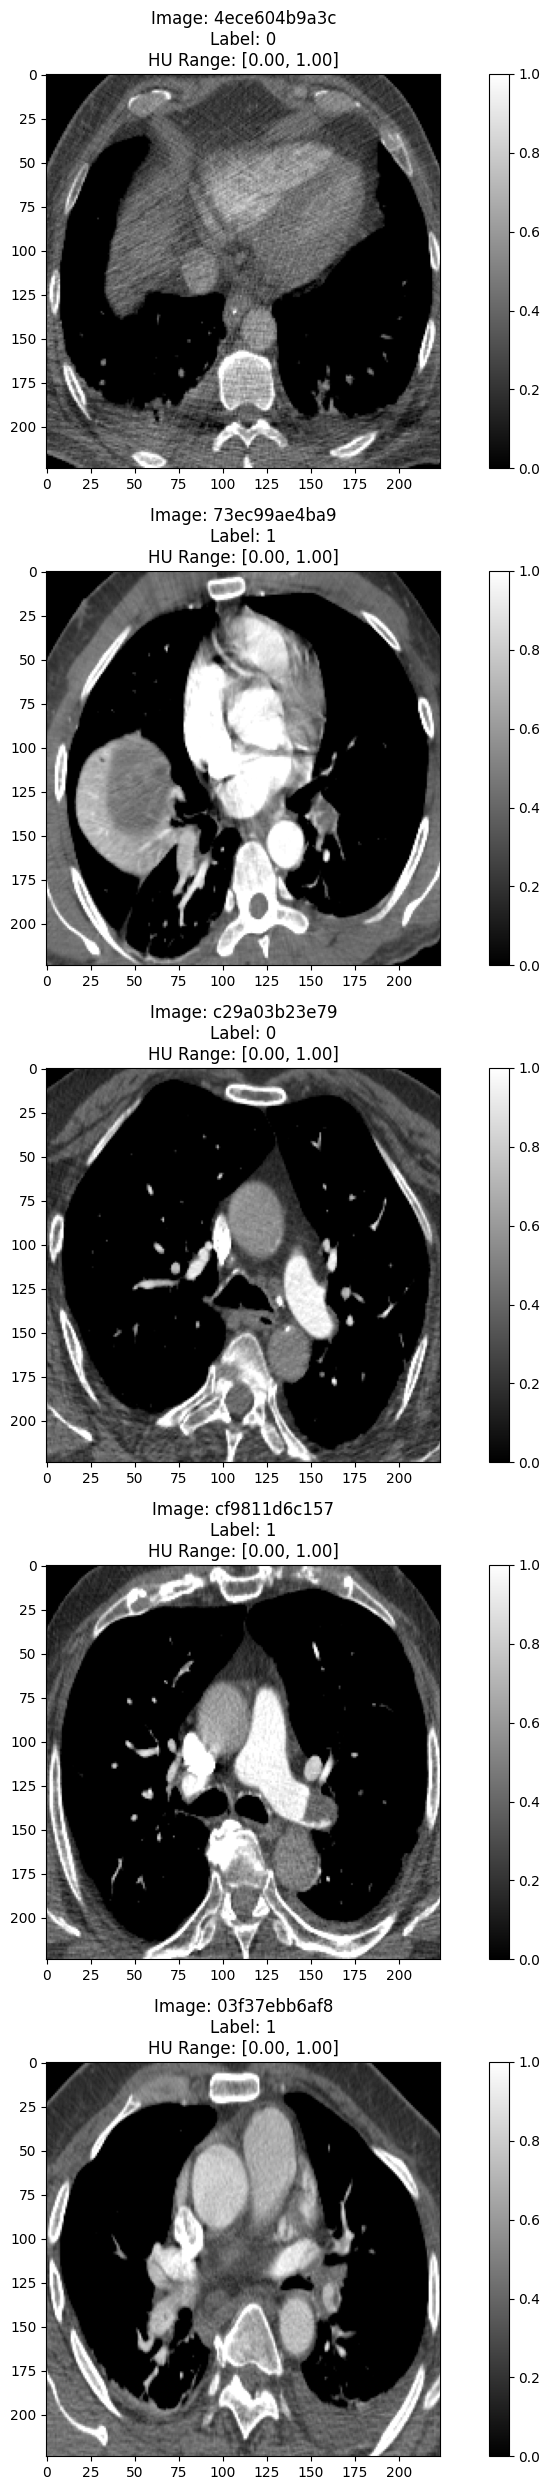

         index      study_id     series_id      image_id  \
0            0  6897fa9de148  2bfbb7fd2e8b  c1a5538bba20   
1            1  6897fa9de148  2bfbb7fd2e8b  fd9db7e0cffe   
2            2  6897fa9de148  2bfbb7fd2e8b  1f108fe8cae4   
3            3  6897fa9de148  2bfbb7fd2e8b  2a6b4c0ef0e5   
4            4  6897fa9de148  2bfbb7fd2e8b  21c2645ae16d   
...        ...           ...           ...           ...   
193074  193075  1ac673a65484  43e3fab0e6a7  e56b77eb8eb7   
193075  193076  1ac673a65484  43e3fab0e6a7  83f41c9ce74e   
193076  193077  1ac673a65484  43e3fab0e6a7  face08dc3638   
193077  193078  1ac673a65484  43e3fab0e6a7  231efa61e22b   
193078  193079  1ac673a65484  43e3fab0e6a7  9d21f45c06b6   

                                            original_path    processed_path  \
0       /storage/scratch2/sandaruwanh/rsna_lg/train/68...  c1a5538bba20.npy   
1       /storage/scratch2/sandaruwanh/rsna_lg/train/68...  fd9db7e0cffe.npy   
2       /storage/scratch2/sandaruwanh/rsna

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from pathlib import Path

def visualize_processed_samples(processed_dir='processed_pe_data_224', num_samples=10):
    """
    Visualize random samples from processed images
    """
    # Load processing info
    info_df = pd.read_csv('/storage/scratch2/sandaruwanh/processed_pe_data_224/processing_info.csv')
    
    # Get random samples
    samples = info_df.sample(n=num_samples)
    
    # Create subplot
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 5*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    # Plot each sample
    for idx, (_, row) in enumerate(samples.iterrows()):
        # Load numpy array
        img_path = Path('/storage/scratch2/sandaruwanh/processed_pe_data_224') / 'images' / row['processed_path']
        img = np.load(str(img_path))
        
        # Plot image
        ax = axes[idx]
        im = ax.imshow(img, cmap='gray')
        plt.colorbar(im, ax=ax)
        
        # Add title with information
        title = f"Image: {row['image_id']}\n"
        title += f"Label: {row['label']}\n"
        title += f"HU Range: [{row['hu_min']:.2f}, {row['hu_max']:.2f}]"
        ax.set_title(title)
        ax.axis('on')  # Show axes to see image dimensions
        
        # Add bbox if available
        if 'bbox' in row and row['bbox'] is not None:
            bbox = eval(str(row['bbox']))  # Convert string bbox to list
            h, w = img.shape
            rect = plt.Rectangle(
                (bbox[0]*w, bbox[1]*h),
                (bbox[2]-bbox[0])*w,
                (bbox[3]-bbox[1])*h,
                fill=False, color='r', linewidth=2
            )
            ax.add_patch(rect)
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_processed_samples(num_samples=5)

# Print some statistics about the processed images
def print_processed_stats(processed_dir='processed_pe_data_224'):
    """Print statistics about processed images"""
    info_df = pd.read_csv('/storage/scratch2/sandaruwanh/processed_pe_data_224/processing_info.csv')
    print(info_df)
    print("Dataset Statistics:")
    print(f"Total images: {len(info_df)}")
    print(f"Positive cases: {info_df['label'].sum()}")
    print(f"Negative cases: {len(info_df) - info_df['label'].sum()}")
    
    # HU value statistics
    print("\nHU Value Statistics:")
    print(f"Min HU: {info_df['hu_min'].min():.2f}")
    print(f"Max HU: {info_df['hu_max'].max():.2f}")
    print(f"Mean HU range: [{info_df['hu_min'].mean():.2f}, {info_df['hu_max'].mean():.2f}]")
    
    # Image size verification
    print("\nVerifying image sizes...")
    img_path = Path('/storage/scratch2/sandaruwanh/processed_pe_data_224') / 'images' / info_df.iloc[0]['processed_path']
    img = np.load(str(img_path))
    print(f"Image size: {img.shape}")

# Print statistics
print_processed_stats()